In [3]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:2"

In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.utils.data as utils


import pandas as pd
import glob
import os
import sys
from tqdm.notebook import tqdm

import random
import pickle


import numpy as np

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GroupKFold

# from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from fastdtw import fastdtw
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.ensemble import RandomForestClassifier

# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import GaussianNB
# from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

import copy
# import datetime
import itertools

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import matplotlib.ticker as ticker

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from natsort import natsorted

import utils.dtw as dtw
import utils.helper as hlp
import importlib

In [5]:
SENSORS_NUM = 16

# 1 関数

In [6]:
def fix_seed(seed):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    # Tensorflow
    torch.backends.cudnn.benchmark = False
#     torch.backends.cudnn.benchmark = True
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    torch.use_deterministic_algorithms = True

# SEED = 0
# fix_seed(SEED)

## 1.1 LSTM

In [7]:
def pipeline_lstm(train_list_df, test_list_df, DIR_OUT, count, pre_best_eval_acc, num_epochs, hidden_size, batch_size, num_layers, is_bi, mabiki_interval):
    
    num_classes = len(test_list_df[0]['Label'].unique())

#     hidden_size = 500 #lstmの出力次元

    input_dim = SENSORS_NUM
#     batch_size = 40 #バッチサイズ
    output_size = num_classes #fcの出力次元

    # 画像に直す
    # dataframeに直してるので時間かかる
    def sensor_to_image(list_df):
        data_list = []
        label_list = []
        for i in tqdm(range(len(list_df[0]))):
            time_series_list = []
            label_list.append(list_df[0].iloc[i]['Label'])

    #         for one_sensor_df in list_df:
    #             time_series_list.append(list(one_sensor_df.drop(['Label', 'Trial', 'Label_Trial'], axis=1).iloc[i]))
            # センサ順を直しながらデータ作成
            for j in [0, 1, 2,3,4,5,6,15,14,13,12,11,10,9,8,7]:
                one_sensor_df = list_df[j].copy()
                time_series_list.append(list(one_sensor_df.drop(['Label', 'Trial', 'Label_Trial'], axis=1).iloc[i]))

            data_list.append(np.array(time_series_list).T)       

        return np.array(data_list), np.array(label_list)

    train_image_list, train_label_list = sensor_to_image(train_list_df)
    test_image_list, test_label_list = sensor_to_image(test_list_df)



    def make_label(label_list):
        label_list = label_list.astype(object)
        label_dict = {}
        for i, label in enumerate(sorted(set(label_list), key=list(label_list).index)):
            label_dict[i] = label
            np.putmask(label_list, label_list == label, i)
        label_list = label_list.astype(int)

        return label_list, label_dict

    train_label_list, train_label_dict = make_label(np.array(train_label_list))
    test_label_list, test_label_dict = make_label(np.array(test_label_list))
    
    
    # データ拡張フラグ作成
    trial_list = train_list_df[0]['Trial'].astype(int).values
    aug_flag_list = np.where((1<=trial_list) & (trial_list<=10), 0, 1)
    

    # 間引く
    train_image_list = train_image_list[:,::mabiki_interval,:]
    test_image_list = test_image_list[:,::mabiki_interval,:]

    x_train_tensor = torch.from_numpy(train_image_list.astype(float))
    x_test_tensor = torch.from_numpy(test_image_list.astype(float))
    y_train_tensor = torch.from_numpy(train_label_list).to(dtype=torch.long)
    y_test_tensor = torch.from_numpy(test_label_list).to(dtype=torch.long)
    aug_flag_tensor = torch.from_numpy(aug_flag_list).to(dtype=torch.long)


    train_dataset = utils.TensorDataset(x_train_tensor,y_train_tensor, aug_flag_tensor)
    test_dataset = utils.TensorDataset(x_test_tensor,y_test_tensor)


    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size, 
                                               shuffle=True,
                                              num_workers=0)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               batch_size=batch_size, 
                                               shuffle=False,
                                             num_workers=0)


    class LstmClassifier(nn.Module):
        def __init__(self, input_dim, batch_size, hidden_size, output_size, num_layers, is_bi):
            super(LstmClassifier, self).__init__()
            self.input_dim = input_dim
            self.batch_size = batch_size
            self.hidden_size = hidden_size
            self.output_size = output_size
            self.num_layers = num_layers
            self.is_bi = is_bi

            self.lstm = nn.LSTM(input_dim, hidden_size, batch_first=True, num_layers=num_layers, bidirectional=is_bi) #batch_first=Trueにしてる
#             self.lstm = nn.GRU(input_dim, hidden_size, batch_first=True, num_layers=num_layers, bidirectional=is_bi) #batch_first=Trueにしてる
#         self.relu = nn.ReLU(inplace=True)
            self.fc = nn.Linear(hidden_size, output_size)

        def forward(self, x):
    #         x = self.embed(x)
            # 初期隠れ状態とセル状態を設定
            h0 = torch.zeros(1, self.batch_size, self.hidden_size).to(device)
            c0 = torch.zeros(1, self.batch_size, self.hidden_size).to(device)
            # LSTMを伝播する
            # output_seqの出力形状：（バッチサイズ、シーケンス長、出力次元）
    #         output_seq, (h_n, c_n) = self.lstm(x, (h0, c0)) 
            output_seq, (h_n, c_n) = self.lstm(x, None)        
#             output_seq, h_n = self.lstm(x, None) # GRU    

            # 最後のタイムステップの隠れ状態をデコード
    #         out = self.fc(self.relu(h_n[-1]))
            out = self.fc(h_n[-1])
            return out

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    net = LstmClassifier(input_dim, batch_size, hidden_size, output_size, num_layers, is_bi)
    net = net.to(device)

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(net.parameters(), lr=10**-5, momentum=0.9, weight_decay=5e-4)
#     optimizer = optim.SGD(net.parameters(), lr=10**-5, momentum=0.9)
#     optimizer = optim.SGD(net.parameters(), lr=10**-5)
    optimizer = optim.Adam(net.parameters(), lr=10**-5)
    # optimizer = optim.Adam(net.parameters(), lr=100)
    # optimizer = torch.optim.RMSprop(net.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)



#     num_epochs = 500

    train_loss_list = []
    train_acc_list = []
    train_f_list = []
    val_loss_list = []
    val_acc_list = []
    val_f_list = []
    origin_acc_list = []
    aug_acc_list = []

    best_eval_acc = 0
    not_up_counter = 0 

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        train_f = 0    
        val_loss = 0
        val_acc = 0
        val_f = 0
        origin_acc = 0
        aug_acc = 0
        tmp_pred_list_by_subject = []
        tmp_label_list_by_subject = []  

        #train
        net.train()
        for i, (images, labels, aug_flugs) in enumerate(train_loader):
            #view()での変換をしない
            images, labels, aug_flugs = images.to(device, dtype=torch.float), labels.to(device),  aug_flugs.to(device)

            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            train_acc += (outputs.max(1)[1] == labels).sum().item()
            train_f += f1_score(outputs.max(1)[1].cpu(), labels.cpu(), average='macro') * len(labels)
            
            origin_acc += (outputs.max(1)[1] == labels)[aug_flugs==0].sum().item()
            aug_acc += (outputs.max(1)[1] == labels)[aug_flugs==1].sum().item()
            
            loss.backward()
            optimizer.step()

        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_train_acc = train_acc / len(train_loader.dataset)
        avg_train_f = train_f / len(train_loader.dataset)
        avg_origin_acc = origin_acc / len(aug_flag_tensor[aug_flag_tensor==0])
        avg_aug_acc = aug_acc / len(aug_flag_tensor[aug_flag_tensor==1])

        #val
        net.eval()
        with torch.no_grad():
          for images, labels in test_loader:
            #view()での変換をしない
            images = images.to(device, dtype=torch.float)
            labels = labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
            val_f += f1_score(outputs.max(1)[1].cpu(), labels.cpu(), average='macro') * len(labels)

    #             if epoch == (num_epochs-1):
            tmp_pred_list_by_subject += [test_label_dict.get(x,x) for x in outputs.max(1)[1].tolist()]
            tmp_label_list_by_subject += [test_label_dict.get(x,x) for x in labels.tolist()]

        avg_val_loss = val_loss / len(test_loader.dataset)
        avg_val_acc = val_acc / len(test_loader.dataset)
        avg_val_f = val_f / len(test_loader.dataset)

        if (epoch % 10) == 0:
            print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}, val_f: {val_f:.4f}' 
                        .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc, val_f=avg_val_f))

        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        train_f_list.append(avg_train_f)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)
        val_f_list.append(avg_val_f)
        origin_acc_list.append(avg_origin_acc)
        aug_acc_list.append(avg_aug_acc)

        if avg_val_acc > best_eval_acc:
            best_eval_acc = avg_val_acc
            pred_list_by_subject = copy.copy(tmp_pred_list_by_subject)
            label_list_by_subject = copy.copy(tmp_label_list_by_subject)
            not_up_counter = 0  
        else:
            not_up_counter += 1
        # if not_up_counter == 100:
        #     break

    #     scheduler.step()

    
    net.eval()
    with torch.no_grad():
        outputs = net(x_train_tensor.to(device, dtype=torch.float))
    r_or_w = torch.where((outputs.max(1)[1].to('cpu') == y_train_tensor) == True, 1, 0)
    print(r_or_w)
    print(torch.flatten((r_or_w[aug_flag_list==1]==1).nonzero()))
    print(torch.flatten((r_or_w[aug_flag_list==1]==0).nonzero()))
    print(train_list_df[0]['Label'].values[((r_or_w==1)&(aug_flag_list==1)).to(torch.bool)])
    print(train_list_df[0]['Label'].values[((r_or_w==0)&(aug_flag_list==1)).to(torch.bool)])
#     print(train_list_df[0]['Label'].values)
#     print(train_list_df[0]['Label'].values[(r_or_w==1)])
#     print((r_or_w==1))
#     print(((r_or_w==1)&(aug_flag_list==1)))
    
    if best_eval_acc > pre_best_eval_acc:

        plt.figure()
        plt.plot(range(epoch+1), train_loss_list, color='blue', linestyle='-', label='train_loss')
        plt.plot(range(epoch+1), val_loss_list, color='green', linestyle='--', label='val_loss')
        plt.legend()
        plt.xlim(0, num_epochs)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.title('Training and validation loss')
        plt.grid()
        plt.savefig(DIR_OUT + "/" + "trial" + str(count+1) + "_loss.png")
        plt.close()

        plt.figure()
        plt.plot(range(epoch+1-100, epoch+1), train_loss_list[epoch+1-100:], color='blue', linestyle='-', label='train_loss')
        plt.plot(range(epoch+1-100, epoch+1), val_loss_list[epoch+1-100:], color='green', linestyle='--', label='val_loss')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.title('Training and validation loss (last 100 epock)')
        plt.grid()
        plt.savefig(DIR_OUT + "/" + "trial" + str(count+1) + "_miniloss.png")
        plt.close()

        plt.figure()
        plt.plot(range(epoch+1), train_f_list, color='blue', linestyle='-', label='train_f')
        plt.plot(range(epoch+1), val_f_list, color='green', linestyle='--', label='val_f')
        plt.legend()
        plt.xlim(0, num_epochs)
        plt.ylim(0, 1)
        plt.xlabel('epoch')
        plt.ylabel('f1-score')
        plt.title('Training and validation f1-score')
        plt.grid()
        plt.savefig(DIR_OUT + "/" + "trial" + str(count+1) + "_f1.png")
        plt.close()

        plt.figure()
        plt.plot(range(epoch+1), train_acc_list, color='blue', linestyle='-', label='train_acc')
        plt.plot(range(epoch+1), val_acc_list, color='green', linestyle='--', label='val_acc')
        plt.plot(range(epoch+1), origin_acc_list, color='yellow', linestyle='--', label='original_acc')
        plt.plot(range(epoch+1), aug_acc_list, color='orange', linestyle='--', label='augmentation_acc')
        plt.legend()
        plt.xlim(0, num_epochs)
        plt.ylim(0, 1)
        plt.xlabel('epoch')
        plt.ylabel('acc')
        plt.title('Training and validation accuracy')
        plt.grid()
        plt.savefig(DIR_OUT + "/" + "trial" + str(count+1) + "_acc.png")
        plt.show()
        plt.close()




    # return pred_list_by_subject, label_list_by_subject, best_eval_acc
    return tmp_pred_list_by_subject, tmp_label_list_by_subject, avg_val_acc

## 1.2 CNN

In [8]:
def pipeline_cnn(train_list_df, test_list_df, DIR_OUT, count, pre_best_eval_acc, conv_size):

    over_sensors_num = 4
    image_size_height = 16+over_sensors_num
    image_size_width = len([col for col in test_list_df[0].columns if str(col).isdecimal()])

    # 画像に直す
    # dataframeに直してるので時間かかる
    def sensor_to_image(list_df):
        data_list_df = []
        label_list = []
        for i in tqdm(range(len(list_df[0]))):
            temp_list_df = []
            label_list.append(list_df[0].iloc[i]['Label'])

            for df in list_df:
                temp_list_df.append(pd.DataFrame(df.iloc[i]).T.drop(['Label', 'Trial', 'Label_Trial'], axis=1))

            data_list_df.append(pd.concat(temp_list_df, sort=False))
            
        # センサ順を一周するよう入れ替え、over_sensors_num分上のセンサを下に延長
        for i in range(len(list_df[0])):
            data_list_df[i] = data_list_df[i].reset_index(drop=True).reindex(index=[0, 1, 2,3,4,5,6,15,14,13,12,11,10,9,8,7]).reset_index(drop=True)
            data_list_df[i] = pd.concat([data_list_df[i], data_list_df[i].iloc[:over_sensors_num]]).reset_index(drop=True)
 
        return data_list_df, label_list

    train_image_list, train_label_list = sensor_to_image(train_list_df)
    test_image_list, test_label_list = sensor_to_image(test_list_df)


    def df_to_nd(image_list):
        for i in range(len(image_list)):
            image_list[i] = image_list[i].values

        image_list = np.array(image_list)

        return image_list
    
    train_image_list = df_to_nd(train_image_list)
    train_image_list = np.reshape(train_image_list, (len(train_list_df[0]), 1, image_size_height, image_size_width), order='F')

    test_image_list = df_to_nd(test_image_list)
    test_image_list = np.reshape(test_image_list, (len(test_list_df[0]), 1, image_size_height, image_size_width), order='F')



    def make_label(label_list):
        label_list = label_list.astype(object)
        label_dict = {}
        for i, label in enumerate(sorted(set(label_list), key=list(label_list).index)):
            label_dict[i] = label
            np.putmask(label_list, label_list == label, i)
        label_list = label_list.astype(int)

        return label_list, label_dict

    train_label_list, train_label_dict = make_label(np.array(train_label_list))
    test_label_list, test_label_dict = make_label(np.array(test_label_list))


    x_train_tensor = torch.from_numpy(train_image_list.astype(float))
    x_test_tensor = torch.from_numpy(test_image_list.astype(float))
    y_train_tensor = torch.from_numpy(train_label_list).to(dtype=torch.long)
    y_test_tensor = torch.from_numpy(test_label_list).to(dtype=torch.long)


    train_dataset = utils.TensorDataset(x_train_tensor,y_train_tensor)
    test_dataset = utils.TensorDataset(x_test_tensor,y_test_tensor)


    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=60, 
                                               shuffle=True,
                                              num_workers=0)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               batch_size=60, 
                                               shuffle=False,
                                             num_workers=0)



    
    num_classes = len(test_list_df[0]['Label'].unique())

    class CNN(nn.Module):

        def __init__(self, num_classes, size_check, conv_size):
            super(CNN, self).__init__()
            self.features = nn.Sequential(
                nn.Conv2d(1, 512, kernel_size=(5, conv_size), padding=0),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                # nn.MaxPool2d(kernel_size=(1,2), stride=2),
#                 nn.Dropout(0.2),
                
#                 nn.Conv2d(512, 1024, kernel_size=(3, 5), padding=0),
#                 nn.ReLU(inplace=True),
#                 nn.MaxPool2d(kernel_size=2, stride=2),
            )
            self.liniear_input_size = self.features(size_check).size()
            self.liniear_input_size = self.liniear_input_size[1]*self.liniear_input_size[2]*self.liniear_input_size[3]
            self.classifier = nn.Sequential(
                nn.Linear(self.liniear_input_size, num_classes),
    #             nn.Softmax(dim=1),
            )

        def forward(self, x):
            x = self.features(x)
            x = x.view(x.size(0), -1)
            x = self.classifier(x)
            return x

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    net = CNN(num_classes, torch.FloatTensor(60, 1, image_size_height, image_size_width), conv_size).to(device)

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(net.parameters(), lr=10**-5, momentum=0.9, weight_decay=5e-4)
    optimizer = optim.SGD(net.parameters(), lr=10**-6, momentum=0.9)
    # optimizer = optim.Adam(net.parameters(), lr=10**-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)






    num_epochs =500

    train_loss_list = []
    train_acc_list = []
    train_f_list = []
    val_loss_list = []
    val_acc_list = []
    val_f_list = []
    
    best_eval_acc = 0
    not_up_counter = 0 

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        train_f = 0    
        val_loss = 0
        val_acc = 0
        val_f = 0
        tmp_pred_list_by_subject = []
        tmp_label_list_by_subject = []  
        
        #train
        net.train()
        for i, (images, labels) in enumerate(train_loader):
            #view()での変換をしない
            images, labels = images.to(device, dtype=torch.float), labels.to(device)

            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            train_acc += (outputs.max(1)[1] == labels).sum().item()
            train_f += f1_score(outputs.max(1)[1].cpu(), labels.cpu(), average='macro') * len(labels)
            #   print(outputs.max(1)[1])
            #   print(labels)
            loss.backward()
            optimizer.step()

        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_train_acc = train_acc / len(train_loader.dataset)
        avg_train_f = train_f / len(train_loader.dataset)

        #val
        net.eval()
        with torch.no_grad():
          for images, labels in test_loader:
            #view()での変換をしない
            images = images.to(device, dtype=torch.float)
            labels = labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
            val_f += f1_score(outputs.max(1)[1].cpu(), labels.cpu(), average='macro') * len(labels)

#             if epoch == (num_epochs-1):
            tmp_pred_list_by_subject += [test_label_dict.get(x,x) for x in outputs.max(1)[1].tolist()]
            tmp_label_list_by_subject += [test_label_dict.get(x,x) for x in labels.tolist()]

        avg_val_loss = val_loss / len(test_loader.dataset)
        avg_val_acc = val_acc / len(test_loader.dataset)
        avg_val_f = val_f / len(test_loader.dataset)

        if (epoch % 10) == 0:
            print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}, val_f: {val_f:.4f}' 
                        .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc, val_f=avg_val_f))
            
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        train_f_list.append(avg_train_f)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)
        val_f_list.append(avg_val_f)
        
        if avg_val_acc > best_eval_acc:
            best_eval_acc = avg_val_acc
            pred_list_by_subject = copy.copy(tmp_pred_list_by_subject)
            label_list_by_subject = copy.copy(tmp_label_list_by_subject)
            not_up_counter = 0  
        else:
            not_up_counter += 1
        # if not_up_counter == 100:
        #     break

    #     scheduler.step()



    if best_eval_acc > pre_best_eval_acc:

        plt.figure()
        plt.plot(range(epoch+1), train_loss_list, color='blue', linestyle='-', label='train_loss')
        plt.plot(range(epoch+1), val_loss_list, color='green', linestyle='--', label='val_loss')
        plt.legend()
        plt.xlim(0, num_epochs)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.title('Training and validation loss')
        plt.grid()
        plt.savefig(DIR_OUT + "/" + "trial" + str(count+1) + "_loss.png")
        plt.close()

        plt.figure()
        plt.plot(range(epoch+1-100, epoch+1), train_loss_list[epoch+1-100:], color='blue', linestyle='-', label='train_loss')
        plt.plot(range(epoch+1-100, epoch+1), val_loss_list[epoch+1-100:], color='green', linestyle='--', label='val_loss')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.title('Training and validation loss (last 100 epock)')
        plt.grid()
        plt.savefig(DIR_OUT + "/" + "trial" + str(count+1) + "_miniloss.png")
        plt.close()

        plt.figure()
        plt.plot(range(epoch+1), train_f_list, color='blue', linestyle='-', label='train_f')
        plt.plot(range(epoch+1), val_f_list, color='green', linestyle='--', label='val_f')
        plt.legend()
        plt.xlim(0, num_epochs)
        plt.ylim(0, 1)
        plt.xlabel('epoch')
        plt.ylabel('f1-score')
        plt.title('Training and validation f1-score')
        plt.grid()
        plt.savefig(DIR_OUT + "/" + "trial" + str(count+1) + "_f1.png")
        plt.close()

        plt.figure()
        plt.plot(range(epoch+1), train_acc_list, color='blue', linestyle='-', label='train_acc')
        plt.plot(range(epoch+1), val_acc_list, color='green', linestyle='--', label='val_acc')
        plt.legend()
        plt.xlim(0, num_epochs)
        plt.ylim(0, 1)
        plt.xlabel('epoch')
        plt.ylabel('acc')
        plt.title('Training and validation accuracy')
        plt.grid()
        plt.savefig(DIR_OUT + "/" + "trial" + str(count+1) + "_acc.png")
        plt.close()




    # return pred_list_by_subject, label_list_by_subject, best_eval_acc
    return tmp_pred_list_by_subject, tmp_label_list_by_subject, avg_val_acc

## 1.3 前処理

In [9]:
def make_input_data(DATA_PATH, moving_average_size, metric):

    All_Files = natsorted(glob.glob('{}/**/*.csv'.format(DATA_PATH),recursive=True))
    del_no_list = [] # センサ番号昇順
    #7,9,10


    list_df = [0]*SENSORS_NUM
    list_list_df = [[] for col in range(SENSORS_NUM)]

    # with open("rand_indexs_multi_dir.pkl", "rb") as f:
    #     rand_indexs = pickle.load(f) #読み出し
    # if len(All_Files) != (len(rand_indexs)*10):
    #     print(rand_indexsの長さがおかしいです)
    #     sys.exit()

    # df最長長探索    
    df_len = []
    for file in tqdm(All_Files):
        df = pd.read_csv(file, header=0)
        df = df.rolling(window=moving_average_size, min_periods=1).mean().dropna(how='all')
        df_len.append(len(df))
        max_len = np.max(df_len)

    # ファイル名順でtrial順
    for i, file in enumerate(tqdm(All_Files)):
        file_name = os.path.basename(file)
    #     print(file_name)
        df = pd.read_csv(file, header=0)
    #             print(file_name)


        # 移動平均
        df = df.rolling(window=moving_average_size, min_periods=1).mean().dropna(how='all')
    #     df.drop(['day', 'time'], axis=1, inplace=True)
    #             df.to_csv(file.replace('.csv', '') + '_MA' + '.csv', encoding='utf-8', index=False)

        # ウィンドウ作成
        for col in range(1, SENSORS_NUM+1): # sec除くため

#             pad_width = (0, max_len-len(df))
            # 16ジェスチャのためパディングをしないよう設定
            pad_width = (0, 0)

            if metric == "eq":
                list_df[col-1] = pd.DataFrame(np.pad(df.iloc[:, col], pad_width, 'edge')).T
            elif metric == "dtw":
                list_df[col-1] = pd.DataFrame(np.pad(df.iloc[:, col], pad_width, 'constant', constant_values=np.nan)).T
            else:
                print(metricがおかしいです)
                sys.exit()


        for col in range(len(list_df)):
            # ファイル名からジェスチャ列追加
            splited_name = os.path.basename(file).split('_')

            if len(splited_name) == 2:
                gesture = splited_name[0]
            else:
                print('ファイル名がおかしい')
                sys.exit()
            list_df[col].insert(0, 'Label', gesture)

            # ファイル名からTrial数列追加
            trial_num = int(splited_name[-1].replace('T', '').replace('.csv', ''))
            list_df[col].insert(1, 'Trial', trial_num)

    #         group_id = rand_indexs[int(i/10)][trial_num-1]
    #         list_df[col].insert(1, 'Trial', group_id)

        #     # label_trial追加
        #     gesture_trial = gesture + '_' + str(trial_num)
        #     df.insert(2, 'Label_Trial', gesture_trial)

            # ファイル名追加
            list_df[col].insert(2, 'Label_Trial', os.path.basename(file).replace('.csv', ''))

        # df追加
        for col in range(len(list_list_df)):
            list_list_df[col].append(list_df[col])

    for col in range(len(list_list_df)):
        list_df[col] = pd.concat(list_list_df[col], sort=False)


    # センサ削除
    if len(del_no_list) > 0:
        del_no_list.reverse()

        for del_no in del_no_list:
            del list_df[del_no-1]



    # センサ番号入れる
    if feats_num == 40:

        adj1_list = list(range(1, SENSORS_NUM))+[SENSORS_NUM]
        adj2_list = list(range(2, SENSORS_NUM+1))+[1]
        diag1_list = list(range(1, int((SENSORS_NUM/2))+1))
        diag2_list = list(range(int(SENSORS_NUM/2)+1, SENSORS_NUM+1))

        if (len(adj1_list) != len(adj2_list)) or (len(diag1_list) != len(diag2_list)):
            print(計算用リストの長さがおかしいです)
            sys.exit() 

        column_0_num = list_df[0].columns.get_loc(0)
        # label_df = list_df[0].iloc[:,:column_0_num] # 時間かかればこっち使う
        for adj1, adj2 in zip(adj1_list, adj2_list):
            label_df = list_df[adj1-1].iloc[:,:column_0_num]
            df = pd.concat([label_df, list_df[adj1-1].iloc[:,column_0_num:] - list_df[adj2-1].iloc[:,column_0_num:]], axis=1)
            list_df.append(df)

        for diag1, diag2 in zip(diag1_list, diag2_list):
            label_df = list_df[diag1-1].iloc[:,:column_0_num]
            df = pd.concat([label_df, list_df[diag1-1].iloc[:,column_0_num:] - list_df[diag2-1].iloc[:,column_0_num:]], axis=1)
            list_df.append(df)



    if gesutures_num == 5:
        # ジェスチャ絞る
        for i, df in enumerate(list_df):
            list_df[i] = df[df['Label'].str.contains('G1S|G3S|G5S|G7S|G10S')]
    elif gesutures_num == 10:
        for i, df in enumerate(list_df):
            list_df[i] = df[df['Label'].str.contains('S')]
    elif gesutures_num == 'houkou16':
        for i, df in enumerate(list_df):
            df = df[~df['Label'].str.contains('9') & ~df['Label'].str.contains('10')]
            df = df.dropna(how='all', axis=1)
            list_df[i] = df
    elif gesutures_num == 'houkou16s':
        for i, df in enumerate(list_df):
            df = df[~df['Label'].str.contains('9') & ~df['Label'].str.contains('10')]
            df = df[df['Label'].str.contains('S')]
            df = df.dropna(how='all', axis=1)
            list_df[i] = df


    # 前処理
    if prep != '生':
    #     for sensor_num in tqdm(range(1, SENSORS_NUM+1)):
        for sensor_num in tqdm(range(1, len(list_df)+1)):
            df = list_df[sensor_num-1]
            trial_list = df['Trial'].unique()
            scaled_feature_names = [col for col in df.columns if type(col) == int]

            df_list_by_trial = []
            for trial_num in trial_list:

                one_trial_df = df.query('Trial==@trial_num')

                scaled_features = one_trial_df.copy()
                features = scaled_features[scaled_feature_names]

                if prep == '標準化':
    #                             features = features - features.mean().mean()
                    features = (features - np.nanmean(features.values))/np.nanstd(features.values)

                elif prep == '最初0':
                    features = (features.T-features.iloc[:,0].values).T
                elif prep == '差':
                    first_df = features.T[::window_size-overlap_size].reset_index(drop=True)
                    last_df = features.T[window_size-1::window_size-overlap_size].reset_index(drop=True)
                    diff_df = (last_df - first_df).dropna(how='all')
                    features = diff_df.T
                else:
                    print('prepが存在しません')
                    sys.exit()

    #             scaled_features[scaled_feature_names] = features
                scaled_features = pd.concat([scaled_features.drop(scaled_feature_names, axis=1), features], axis=1)
                df_list_by_trial.append(scaled_features)

            list_df[sensor_num-1] = pd.concat(df_list_by_trial, sort=False)

    return list_df

## 1.4 データ拡張

In [57]:
def window_slice(x, reduce_ratio=0.9):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    target_len = np.ceil(reduce_ratio*x.shape[1]).astype(int)
    if target_len >= x.shape[1]:
        return x
    starts = np.random.randint(low=0, high=x.shape[1]-target_len, size=(x.shape[0])).astype(int)
    ends = (target_len + starts).astype(int)
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            ret[i,:,dim] = np.interp(np.linspace(0, target_len, num=x.shape[1]), np.arange(target_len), pat[starts[i]:ends[i],dim]).T
    return ret

def discriminative_guided_warp(x, labels, aug_times, batch_size=6, slope_constraint="symmetric", use_window=True, dtw_type="normal", use_variable_slice=True, verbose=0):
    # use verbose = -1 to turn off warnings
    # slope_constraint is for DTW. "symmetric" or "asymmetric"
    # dtw_type is for shapeDTW or DTW. "normal" or "shape"
    
    
    if use_window:
        window = np.ceil(x.shape[1] / 10.).astype(int)
    else:
        window = None
    orig_steps = np.arange(x.shape[1])
    l = np.argmax(labels, axis=1) if labels.ndim > 1 else labels
    
    positive_batch = np.ceil(batch_size / 2).astype(int)
    negative_batch = np.floor(batch_size / 2).astype(int)
        
    ret = np.zeros_like(x)
    warp_amount = np.zeros(x.shape[0])
    for i, pat in enumerate(tqdm(x)):
        # guarentees that same one isnt selected
        choices = np.delete(np.arange(x.shape[0]), i)
        
        # remove ones of different classes
        positive = np.where(l[choices] == l[i])[0]
        negative = np.where(l[choices] != l[i])[0]
        
        if positive.size > 0 and negative.size > 0:
            pos_k = min(positive.size, positive_batch)
            neg_k = min(negative.size, negative_batch)
            positive_prototypes = x[np.random.choice(positive, pos_k, replace=False)]
            negative_prototypes = x[np.random.choice(negative, neg_k, replace=False)]
                        
            # vector embedding and nearest prototype in one
            pos_aves = np.zeros((pos_k))
            neg_aves = np.zeros((pos_k))
            if dtw_type == "shape":
                for p, pos_prot in enumerate(positive_prototypes):
                    for ps, pos_samp in enumerate(positive_prototypes):
                        if p != ps:
                            pos_aves[p] += (1./(pos_k-1.))*dtw.shape_dtw(pos_prot, pos_samp, dtw.RETURN_VALUE, slope_constraint=slope_constraint, window=window)
                    for ns, neg_samp in enumerate(negative_prototypes):
                        neg_aves[p] += (1./neg_k)*dtw.shape_dtw(pos_prot, neg_samp, dtw.RETURN_VALUE, slope_constraint=slope_constraint, window=window)
                selected_id = np.argmax(neg_aves - pos_aves)
                path = dtw.shape_dtw(positive_prototypes[selected_id], pat, dtw.RETURN_PATH, slope_constraint=slope_constraint, window=window)
            else:
                for p, pos_prot in enumerate(positive_prototypes):
                    for ps, pos_samp in enumerate(positive_prototypes):
                        if p != ps:
                            pos_aves[p] += (1./(pos_k-1.))*dtw.dtw(pos_prot, pos_samp, dtw.RETURN_VALUE, slope_constraint=slope_constraint, window=window)
                    for ns, neg_samp in enumerate(negative_prototypes):
                        neg_aves[p] += (1./neg_k)*dtw.dtw(pos_prot, neg_samp, dtw.RETURN_VALUE, slope_constraint=slope_constraint, window=window)
                selected_id = np.argmax(neg_aves - pos_aves)
                path = dtw.dtw(positive_prototypes[selected_id], pat, dtw.RETURN_PATH, slope_constraint=slope_constraint, window=window)
                   
            # Time warp
            warped = pat[path[1]]
            warp_path_interp = np.interp(orig_steps, np.linspace(0, x.shape[1]-1., num=warped.shape[0]), path[1])
            warp_amount[i] = np.sum(np.abs(orig_steps-warp_path_interp))
            for dim in range(x.shape[2]):
                ret[i,:,dim] = np.interp(orig_steps, np.linspace(0, x.shape[1]-1., num=warped.shape[0]), warped[:,dim]).T
        else:
            if verbose > -1:
                print("There is only one pattern of class %d"%l[i])
            ret[i,:] = pat
            warp_amount[i] = 0.
        
#         hlp.plot1d(x=pat[:,10], x2=positive_prototypes[selected_id][:,10], x3=ret[i,:,10])
        
    if use_variable_slice:
        max_warp = np.max(warp_amount)
        if max_warp == 0:
            # unchanged
            ret = window_slice(ret, reduce_ratio=0.9)
        else:
            for i, pat in enumerate(ret):
                # Variable Sllicing
                ret[i] = window_slice(pat[np.newaxis,:,:], reduce_ratio=0.9+0.1*warp_amount[i]/max_warp)[0]
    
    return ret

def random_guided_warp(x, labels, aug_times, slope_constraint="symmetric", use_window=True, dtw_type="normal", verbose=0):
    # use verbose = -1 to turn off warnings
    # slope_constraint is for DTW. "symmetric" or "asymmetric"
    # dtw_type is for shapeDTW or DTW. "normal" or "shape"
    # 2倍以上作れるようにした
    # patとprottypeが被らないようにした
    
    if use_window:
        window = np.ceil(x.shape[1] / 10.).astype(int)
    else:
        window = None
    orig_steps = np.arange(x.shape[1])
    l = np.argmax(labels, axis=1) if labels.ndim > 1 else labels
    
#     ret = np.zeros_like(x)
    ret = np.zeros((x.shape[0]*(aug_times-1), x.shape[1], x.shape[2]))
    
    counter = 0
    for i, pat in enumerate(tqdm(x)):
        # guarentees that same one isnt selected
        choices1 = np.delete(np.arange(x.shape[0]), i)
        # remove ones of different classes
        choices2 = np.where(l[choices1] == l[i])[0]
        choices = choices1[choices2]
#         print(x.shape)
#         print(x.shape[0], i)
#         print(choices1)
#         print(choices)
        
        if (aug_times-1) > choices.size:
            aaaaerroraaa

        for chice_no in np.random.choice(choices, (aug_times-1), replace=False):
            if choices.size > 0:        
                # pick random intra-class pattern
                random_prototype = x[chice_no]

                if dtw_type == "shape":
                    path = dtw.shape_dtw(random_prototype, pat, dtw.RETURN_PATH, slope_constraint=slope_constraint, window=window)
                else:
                    path = dtw.dtw(random_prototype, pat, dtw.RETURN_PATH, slope_constraint=slope_constraint, window=window)

                # Time warp
                warped = pat[path[1]]
                for dim in range(x.shape[2]):
                    ret[counter,:,dim] = np.interp(orig_steps, np.linspace(0, x.shape[1]-1., num=warped.shape[0]), warped[:,dim]).T
            else:
                if verbose > -1:
                    print("There is only one pattern of class %d, skipping timewarping"%l[i])
                ret[counter,:] = pat
#             print(l[chice_no])
#             print(chice_no)
#             hlp.plot1d(x=pat[:,10], x2=random_prototype[:,10], x3=ret[counter,:,10]) 
#             hlp.plot1d(x=pat[:,:], x2=random_prototype[:,:], x3=ret[counter,:,:]) 
#             hlp.plot1d(x=pat[:,10], x2=random_prototype[:,10], x3=ret[counter,:,10], save_file='./{}/{}.png'.format('aug_images', counter)) 
#             hlp.plot1d(x=pat[:,:], x2=random_prototype[:,:], x3=ret[counter,:,:], save_file='./{}/{}.png'.format('aug_images', counter)) 
            counter += 1
    return ret

def augmentation(list_df, aug_times, method, dtw_type="normal"):
    list_nd = np.zeros((list_df[0].shape[0], 200, SENSORS_NUM))
    for i, df in enumerate(list_df):
        list_nd[:, :, i] = df.iloc[:, 3:].values.reshape((-1, 200))
    label = list_df[0]['Label'].values

    # 拡張
    if method=='rgw':
        aug_list_nd = random_guided_warp(list_nd, label, aug_times=aug_times, dtw_type=dtw_type)
    elif method=='dgw':
        aug_list_nd = discriminative_guided_warp(list_nd, label, aug_times=aug_times, dtw_type=dtw_type)

    # 結合
#     aug_times = 2 #何倍に拡張するか
    aug_label = [label for label in list_df[0]['Label'].values for i in range(aug_times-1)]
    aug_trial_n = 100
    aug_trial = [aug_trial_n]*len(aug_label)
    aug_label_tiral = [label +'_T'+ str(aug_trial_n) for label in aug_label]

    aug_list_nd = aug_list_nd.transpose(2, 0, 1)
   
    # デバッグ用グラフ化
#     for i, data in enumerate(aug_list_nd[10]):
#         print(i)
#         hlp.plot1d(x=data)

    aug_list_df = [0]*SENSORS_NUM
    for i, data in enumerate(aug_list_nd):
        aug_df = pd.DataFrame(columns=list_df[0].columns)
        aug_df['Label'] = aug_label
        aug_df['Trial'] = aug_trial
        aug_df['Label_Trial'] = aug_label_tiral
        aug_df.iloc[:, 3:] = data

        aug_list_df[i] = pd.concat((list_df[i], aug_df))
        
    return aug_list_df

# 2 実行

## 2.1 ユーザ適応性能検証

In [31]:
%%time

SEED = 0
fix_seed(SEED)

model_name = 'knn'

# LSTM
num_epochs = 500
hidden_size = 512
batch_size = 60
num_layers = 3
is_bi = True
mabiki_interval = 8

# CNN
conv_size = 20

# kNN
metric = "dtw" # "dtw" or "eq"

# moving_average_size_list = [1, 5, 10, 15, 20]
moving_average_size_list = [10]

window_size = 20
overlap_size = 19

all_acc_list = []
for moving_average_size in tqdm(moving_average_size_list):

    # prep_list = ['生', '最初0', '差', '標準化']
    # feats_num_list = [16, 40]
    # INPUT_FOLDER_list = ['nagasima_split', 'Sub.5_split', 'hirayama_split', 'tabuchi_split', 'okamotomasa_split', 'yosida_split', 'okuda_split', 'okamotomarina_split']

    prep_list = ['生']
#     prep_list = ['生', '最初0', '差', '標準化']
    gesutures_num_list = ['houkou16'] # 5or10or20
    feats_num_list = [16]

    # INPUT_FOLDER_list = ['nagasima_split', 'hirayama_split', 'tabuchi_split', 'okamotomasa_split', 'yosida_split', 'okuda_split', 'okamotomarina_split']

#     INPUT_FOLDER_train_list = [['Sub.5_split', 'hirayama_split', 'tabuchi_split', 
#                          'okamotomasa_split', 'yosida_split', 'okuda_split', 
#                          'okamotomarina_split', 'nagasima_split', 'isobe_split', 
#                         'igarashi_split', 'hotta_split', 'watanabe_split', 
#                          'takayama_split']]
#     INPUT_FOLDER_train_list = [['isobe_split', 'hirayama_split', 'nagasima_split', 'okamotomasa_split']] #2Dlist
#     INPUT_FOLDER_train_list = [['isobe_split', 'hirayama_split']] #2Dlist
#     INPUT_FOLDER_test_list = ['yamashita_split']


#     INPUT_FOLDER_train_list = [['yamashita_split', 'hirayama_split', 'nagasima_split', 'okamotomasa_split']] #2Dlist
#     INPUT_FOLDER_test_list = ['isobe_split']        

    # ユーザ適応7人
    INPUT_FOLDER_train_list = [['Sub.5_split', 'tabuchi_split', 'yosida_split', 'okamotomarina_split', 'yamashita_split', 'hotta_split', 'watanabe_split']]*7 #2Dlist
    INPUT_FOLDER_test_list = ['hirayama_split', 'okamotomasa_split', 'okuda_split', 'nagasima_split', 'igarashi_split', 'takayama_split', 'isobe_split']

#     nSplit = 10
    for INPUT_FOLDER_train, INPUT_FOLDER_test in zip(INPUT_FOLDER_train_list, INPUT_FOLDER_test_list):
        for gesutures_num in gesutures_num_list:
            for prep in prep_list:
                for feats_num in feats_num_list:

                    train_subs_name = []
                    for i, sub in enumerate(INPUT_FOLDER_train):
                        if i == 0:
                            DATA_PATH_train = '.' + "./data_split/" + sub + "/3. STEP3/3-1 条件(照明：普通、表情：無、振動：静止)、タスク：ジェスチャ"
                            train_list_df = make_input_data(DATA_PATH_train, moving_average_size, metric)
                        else:
                            DATA_PATH_train = '.' + "./data_split/" + sub + "/3. STEP3/3-1 条件(照明：普通、表情：無、振動：静止)、タスク：ジェスチャ"
                            train_list_df_temp = make_input_data(DATA_PATH_train, moving_average_size, metric)
                            for j in range(len(train_list_df)):
                                train_list_df[j] = pd.concat([train_list_df[j], train_list_df_temp[j]],0)
                        train_subs_name.append(sub.replace('_split', ''))
                    train_subs_name = 'train-'+','.join(sorted(train_subs_name))
                    

                    DATA_PATH_test = '.' + "./data_split/" + INPUT_FOLDER_test + "/3. STEP3/3-1 条件(照明：普通、表情：無、振動：静止)、タスク：ジェスチャ"
                    test_list_df = make_input_data(DATA_PATH_test, moving_average_size, metric)
                    
                    if model_name=='knn':
                        DIR_OUT = './' + 'ジェスチャ通常環境' + '/' + INPUT_FOLDER_test.replace('_split', '') +'/'+ train_subs_name + '/１普通状態_' + str(gesutures_num) + 'G_' + str(feats_num) + 'feats_' + prep + '_' + str(moving_average_size)+'sma' + '_'+model_name+metric
                    else:
                        DIR_OUT = './' + 'ジェスチャ通常環境' + '/' + INPUT_FOLDER_test.replace('_split', '') +'/'+ train_subs_name + '/１普通状態_' + str(gesutures_num) + 'G_' + str(feats_num) + 'feats_' + prep + '_' + str(moving_average_size)+'sma' + '_'+model_name

                    os.makedirs(DIR_OUT, exist_ok=True)
                    

                    df = train_list_df[0]
                    class_num = len(set(df["Label"]))

                    
                    if model_name == 'knn':
                        def DTW(a, b):
                            return fastdtw(a, b)[0]

                    #     clf = Pipeline([("scaler", StandardScaler()), ("svc", SVC())])
                    #     clf = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=5, n_jobs=-1))])

                        if metric == "eq":
                            clf = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)
                    #         , weights='distance'
                        elif metric == "dtw":
                            clf = KNeighborsTimeSeriesClassifier(n_neighbors=7, metric="dtw", n_jobs=-1)
                    #         , weights='distance'
                    #         clf = KNeighborsClassifier(metric=DTW, n_neighbors=11, n_jobs=-1)
                        else:
                            print('metricがおかしいです')
                            sys.exit()

                    #     param_grid = [{'knn__n_neighbors': [3]}]


                    # kf = KFold(n_splits=nSplit, shuffle=False)
                    # kf_grid = KFold(n_splits=nSplit_grid, shuffle=True)
                    # kf_grid = KFold(n_splits=nSplit-1)

#                     kf = GroupKFold(n_splits=nSplit)
#                     kf_grid = GroupKFold(n_splits=nSplit-1)


                    param_list = []
                    accuracy_list = []
                    test_df_list = []
                    # テスト
#                     for count, (train_index, test_index) in enumerate(tqdm(kf.split(df.drop(['Label', 'Trial', 'Label_Trial'], axis=1), df['Label'], df['Trial']), total=nSplit)):                    
                    count = 0

                    if model_name != 'knn':
#                         # train, test分割   
#                         train_list_df = []
#                         test_list_df = []
#                         for df in list_df:
#                             train_list_df.append(df.iloc[train_index])
#                             test_list_df.append(df.iloc[test_index])

#                       # l_p_df用、エラー出さないため
                        test_df = test_list_df[0].copy()

    #                     tmp_Y_pred, tmp_Y_test, tmp_best_eval_acc = pipeline(train_list_df, test_list_df, DIR_OUT, count)
                        pre_best_eval_acc = 0
                        best_eval_acc_list = []
                        for random_counter in range(1):

                            if model_name == 'cnn':
                                tmp_Y_pred, tmp_Y_test, tmp_best_eval_acc = pipeline_cnn(train_list_df, test_list_df, 
                                                                                     DIR_OUT, count, pre_best_eval_acc, 
                                                                                    conv_size)
                            elif model_name == 'lstm':
                                tmp_Y_pred, tmp_Y_test, tmp_best_eval_acc = pipeline_lstm(train_list_df, test_list_df, 
                                                                                     DIR_OUT, count, pre_best_eval_acc, 
                                                                                    num_epochs, hidden_size, batch_size, 
                                                                                    num_layers, is_bi, mabiki_interval)
                            if tmp_best_eval_acc > pre_best_eval_acc:
                                best_eval_acc = tmp_best_eval_acc
                                Y_pred = copy.copy(tmp_Y_pred)
                                Y_test = copy.copy(tmp_Y_test)
                            best_eval_acc_list.append(tmp_best_eval_acc)
                            pre_best_eval_acc = tmp_best_eval_acc
                        print(best_eval_acc_list) 
                        
                        test_df_list.append(test_df)            

                    elif model_name == 'knn':
                        Y_proba = np.zeros((len(test_list_df[0]), class_num))
                        for train_df, test_df in tqdm(zip(train_list_df, test_list_df), total=len(test_list_df)):
    #                         train_df = df.iloc[train_index]
    #                         test_df = df.iloc[test_index]
                            data_train = train_df.drop(['Label', 'Trial', 'Label_Trial'], axis=1)
                            label_train = train_df.loc[:, 'Label']
                            group_train = train_df.loc[:, 'Trial']
                            data_test = test_df.drop(['Label', 'Trial', 'Label_Trial'], axis=1)
                            label_test = test_df.loc[:, 'Label']

                            if model_name == 'knn':
                                clf.fit(data_train, label_train)
                    #             Y_pred = clf.predict(data_test)
                                Y_proba += clf.predict_proba(data_test.values)

                        Y_pred = Y_proba.argmax(axis = 1).astype(object)
                        for class_i in range(class_num):
                            np.putmask(Y_pred, Y_pred == class_i, clf.classes_[class_i])
                        Y_test = label_test
                        test_df_list.append(test_df)
                    
                    

                    warnings.filterwarnings('ignore')
                    recall = recall_score(Y_test, Y_pred, average="weighted")
                    precision = precision_score(Y_test, Y_pred, average="weighted")
                    fMeasure = f1_score(Y_test, Y_pred, average="weighted")
                    labels = natsorted(list(set(Y_test)))
                    cmx_data = confusion_matrix(Y_test, Y_pred, labels=labels)
                    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
                    report = classification_report(Y_test, Y_pred, target_names=labels, labels=labels, output_dict=True)
                    df_report = pd.DataFrame(report)

                    if count == 0:
                        mean_df_report = df_report
                        sum_df_cmx = df_cmx
                        all_Y_pred = Y_pred
                    else:
                        mean_df_report += df_report
                        sum_df_cmx += df_cmx
                        all_Y_pred = np.append(all_Y_pred, Y_pred)

                    os.makedirs(DIR_OUT, exist_ok=True)
#                     df_report.to_csv(DIR_OUT + "/" + "trial" + str(count+1) + ".csv", encoding='utf-8')
#                     df_cmx.to_csv(DIR_OUT + "/" + "trial" + str(count+1) + "_cmx.csv", encoding='utf-8')
                    plt.figure(figsize=(10, 7))
                #     sns.set(font='MS Gothic') #ラベルが日本語の場合
                    sns.heatmap(df_cmx, annot=True, cmap='Blues', fmt='g')
                    #plt.show()
#                     plt.savefig(DIR_OUT + "/" + "trial" + str(count+1) + "_cmx.png", bbox_inches='tight')
                    plt.close()
                    #df_report.to_csv(DIR_OUT + "/" + "trial" + str(count+1) + ".csv", encoding='utf-8',mode='x')

                        
                        
                        
                    mean_df_report /= count+1
                    mean_df_report.to_csv(DIR_OUT + "/" + "trialAll.csv", encoding='utf-8')

#                     with open(DIR_OUT + '/F1score.txt', mode='w') as f:
#                         s = str(mean_df_report.loc['f1-score', 'macro avg'])
#                         f.write(s)
#                     with open("./ジェスチャ通常環境" + '/' + 'ジェスチャ通常環境' + 'F1score.txt', mode='a') as f:
#                         s = DIR_OUT + '\n'
#                         s += str(mean_df_report.loc['f1-score', 'macro avg']) + '\n\n'
#                         f.write(s)
                    with open(DIR_OUT + '/accuracy.txt', mode='w') as f:
                        s = str(mean_df_report.loc['f1-score', 'accuracy'])
                        f.write(s)
                    all_acc_list.append(mean_df_report.loc['f1-score', 'accuracy'])
                    with open("./ジェスチャ通常環境" + '/' + 'ジェスチャ通常環境' + 'accuracy.txt', mode='a') as f:
                        s = DIR_OUT + '\n'
                        s += str(mean_df_report.loc['f1-score', 'accuracy']) + '\n\n'
                        f.write(s)
                        
                    # result_list.append(mean_df_report['macro avg'].loc['precision'])
                    # result_list.append(mean_df_report['macro avg'].loc['recall'])
                    # result_list.append(mean_df_report['macro avg'].loc['f1-score'])

                    plt.figure(figsize=(10, 7))
                    sns.heatmap(sum_df_cmx, annot=True, cmap='Blues', fmt='g')
                    plt.savefig(DIR_OUT + "/" + "trialAll_cmx.png", bbox_inches='tight')
                    plt.close()
                    sum_df_cmx.to_csv(DIR_OUT + "/" + "trialAll_cmx.csv", encoding='utf-8')

#                     if model_name != 'knn':
#                         with open(DIR_OUT + '/param.txt', mode='w') as f:
#                             for i in range(nSplit):
#                                 s = "trial" +str(i+1) + '\n' + 'param : ' + str(param_list[i]) + '\n' + 'accuracy : ' + str(accuracy_list[i]) + '\n\n'
#                                 f.write(s)

                    l_p_df = pd.concat(test_df_list, sort=False)
                    label = l_p_df['Label']
                    l_p_df = l_p_df.drop('Label', axis=1)
                    l_p_df.insert(2, 'Label', label)
                    l_p_df.insert(3, 'prediction_label', all_Y_pred)
                    l_p_df.to_csv(DIR_OUT + "/" + "prediction.csv", encoding='utf-8')



with open("./ジェスチャ通常環境" + '/' + 'ジェスチャ通常環境' + 'accuracy.txt', mode='a') as f:
    s = 'all_mean' + '\n'
    s += str(np.mean(all_acc_list)) + '\n\n'
    f.write(s)



Wall time: 37.2 s


## 2.2 環境適応性能検証

In [57]:
%%time

SEED = 0
fix_seed(SEED)

model_name = 'lstm'

# LSTM
num_epochs = 500
hidden_size = 512
batch_size = 60
num_layers = 3
is_bi = True
mabiki_interval = 8

# CNN
conv_size = 20

# kNN
metric = "eq" # "dtw" or "eq"

# moving_average_size_list = [1, 5, 10, 15, 20]
moving_average_size_list = [10]



env_dec_train = {'name':'通常', 'path':"/3. STEP3/3-1 条件(照明：普通、表情：無、振動：静止)、タスク：ジェスチャ"}

# env_dec_test = {'name':'暗い', 'path':"/3. STEP3/3-2 条件(照明：暗い、表情：無、振動：静止)、タスク：ジェスチャ"}
# env_dec_test = {'name':'再装着', 'path':"/3. STEP3/3-5　条件(照明：普通、表情：無、振動：静止、※再装着)、タスク：ジェスチャ"}
env_dec_test = {'name':'笑顔', 'path':"/3. STEP3/3-4　条件(照明：普通、表情：笑顔、振動：静止)、タスク：ジェスチャ"}
# env_dec_test = {'name':'歩行', 'path':"/3. STEP3/3-3　条件(照明：普通、表情：無、振動：歩行)、タスク：ジェスチャ"}


window_size = 20
overlap_size = 19

all_acc_list = []
for moving_average_size in tqdm(moving_average_size_list):

    # prep_list = ['生', '最初0', '差', '標準化']
    # feats_num_list = [16, 40]
    # INPUT_FOLDER_list = ['nagasima_split', 'Sub.5_split', 'hirayama_split', 'tabuchi_split', 'okamotomasa_split', 'yosida_split', 'okuda_split', 'okamotomarina_split']

    prep_list = ['生', '最初0']
#     prep_list = ['生', '最初0', '差', '標準化']
    gesutures_num_list = ['houkou16s'] # 5or10or20, houkou16, houkou16s
    feats_num_list = [16]

    # INPUT_FOLDER_list = ['nagasima_split', 'hirayama_split', 'tabuchi_split', 'okamotomasa_split', 'yosida_split', 'okuda_split', 'okamotomarina_split']

    INPUT_FOLDER_list = ['Sub.5_split', 'hirayama_split', 'tabuchi_split', 
                         'okamotomasa_split', 'yosida_split', 'okuda_split', 
                         'okamotomarina_split', 'nagasima_split', 'isobe_split', 
                        'igarashi_split', 'hotta_split', 'watanabe_split', 
                         'yamashita_split', 'takayama_split']
#     INPUT_FOLDER_list = ['hirayama_split', 'tabuchi_split', 
#                          'okamotomasa_split', 'yosida_split', 'okuda_split', 
#                          'okamotomarina_split', 'nagasima_split', 'isobe_split', 
#                         'igarashi_split', 'hotta_split', 'watanabe_split', 
#                          'yamashita_split', 'takayama_split']
#     INPUT_FOLDER_train_list = [['isobe_split', 'hirayama_split', 'nagasima_split', 'okamotomasa_split']] #2Dlist
#     INPUT_FOLDER_train_list = [['isobe_split', 'hirayama_split']] #2Dlist
#     INPUT_FOLDER_list = ['yamashita_split', 'isobe_split']


#     INPUT_FOLDER_train_list = [['yamashita_split', 'hirayama_split', 'nagasima_split', 'okamotomasa_split']] #2Dlist
#     INPUT_FOLDER_test_list = ['isobe_split']        

    # ユーザ適応7人
#     INPUT_FOLDER_train_list = [['Sub.5_split', 'tabuchi_split', 'yosida_split', 'okamotomarina_split', 'yamashita_split', 'hotta_split', 'watanabe_split']]*7 #2Dlist
#     INPUT_FOLDER_test_list = ['hirayama_split', 'okamotomasa_split', 'okuda_split', 'nagasima_split', 'igarashi_split', 'takayama_split', 'isobe_split']


#     nSplit = 10
    
    for gesutures_num in gesutures_num_list:
        for prep in prep_list:
            for feats_num in feats_num_list:
                for INPUT_FOLDER in INPUT_FOLDER_list:

                    train_subs_name = []
                    # 環境用に変える
                    
                    # 環境にする
                    DATA_PATH_train = '.' + "./data_split/" + INPUT_FOLDER + env_dec_train['path']
                    train_list_df = make_input_data(DATA_PATH_train, moving_average_size, metric)

                    DATA_PATH_test = '.' + "./data_split/" + INPUT_FOLDER + env_dec_test['path']
                    test_list_df = make_input_data(DATA_PATH_test, moving_average_size, metric)
                    
                    if model_name=='knn':
                        DIR_OUT = './' + 'ジェスチャ'+ env_dec_train['name']+'-'+env_dec_test['name'] + '/' + str(gesutures_num) + 'G_' + str(feats_num) + 'feats_' + prep + '_' + str(moving_average_size)+'sma' + '_'+model_name+metric +'/'+ INPUT_FOLDER.replace('_split', '')
                    else:
                        DIR_OUT = './' + 'ジェスチャ'+ env_dec_train['name']+'-'+env_dec_test['name'] + '/' + str(gesutures_num) + 'G_' + str(feats_num) + 'feats_' + prep + '_' + str(moving_average_size)+'sma' + '_'+model_name +'/'+ INPUT_FOLDER.replace('_split', '')
                    os.makedirs(DIR_OUT, exist_ok=True)
                    

                    df = train_list_df[0]
                    class_num = len(set(df["Label"]))

                    
                    if model_name == 'knn':
                        def DTW(a, b):
                            return fastdtw(a, b)[0]

                    #     clf = Pipeline([("scaler", StandardScaler()), ("svc", SVC())])
                    #     clf = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=5, n_jobs=-1))])

                        if metric == "eq":
                            clf = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)
                    #         , weights='distance'
                        elif metric == "dtw":
                            clf = KNeighborsTimeSeriesClassifier(n_neighbors=7, metric="dtw", n_jobs=-1)
                    #         , weights='distance'
                    #         clf = KNeighborsClassifier(metric=DTW, n_neighbors=11, n_jobs=-1)
                        else:
                            print('metricがおかしいです')
                            sys.exit()

                    #     param_grid = [{'knn__n_neighbors': [3]}]


                    # kf = KFold(n_splits=nSplit, shuffle=False)
                    # kf_grid = KFold(n_splits=nSplit_grid, shuffle=True)
                    # kf_grid = KFold(n_splits=nSplit-1)

#                     kf = GroupKFold(n_splits=nSplit)
#                     kf_grid = GroupKFold(n_splits=nSplit-1)


                    param_list = []
                    accuracy_list = []
                    test_df_list = []
                    # テスト
#                     for count, (train_index, test_index) in enumerate(tqdm(kf.split(df.drop(['Label', 'Trial', 'Label_Trial'], axis=1), df['Label'], df['Trial']), total=nSplit)):                    
                    count = 0

                    if model_name != 'knn':
#                         # train, test分割   
#                         train_list_df = []
#                         test_list_df = []
#                         for df in list_df:
#                             train_list_df.append(df.iloc[train_index])
#                             test_list_df.append(df.iloc[test_index])

#                       # l_p_df用、エラー出さないため
                        test_df = test_list_df[0].copy()

    #                     tmp_Y_pred, tmp_Y_test, tmp_best_eval_acc = pipeline(train_list_df, test_list_df, DIR_OUT, count)
                        pre_best_eval_acc = 0
                        best_eval_acc_list = []
                        for random_counter in range(1):

                            if model_name == 'cnn':
                                tmp_Y_pred, tmp_Y_test, tmp_best_eval_acc = pipeline_cnn(train_list_df, test_list_df, 
                                                                                     DIR_OUT, count, pre_best_eval_acc, 
                                                                                    conv_size)
                            elif model_name == 'lstm':
                                tmp_Y_pred, tmp_Y_test, tmp_best_eval_acc = pipeline_lstm(train_list_df, test_list_df, 
                                                                                     DIR_OUT, count, pre_best_eval_acc, 
                                                                                    num_epochs, hidden_size, batch_size, 
                                                                                    num_layers, is_bi, mabiki_interval)
                            if tmp_best_eval_acc > pre_best_eval_acc:
                                best_eval_acc = tmp_best_eval_acc
                                Y_pred = copy.copy(tmp_Y_pred)
                                Y_test = copy.copy(tmp_Y_test)
                            best_eval_acc_list.append(tmp_best_eval_acc)
                            pre_best_eval_acc = tmp_best_eval_acc
                        print(best_eval_acc_list) 
                        
                        test_df_list.append(test_df)            

                    elif model_name == 'knn':
                        Y_proba = np.zeros((len(test_list_df[0]), class_num))
                        for train_df, test_df in tqdm(zip(train_list_df, test_list_df), total=len(test_list_df)):
    #                         train_df = df.iloc[train_index]
    #                         test_df = df.iloc[test_index]
                            data_train = train_df.drop(['Label', 'Trial', 'Label_Trial'], axis=1)
                            label_train = train_df.loc[:, 'Label']
                            group_train = train_df.loc[:, 'Trial']
                            data_test = test_df.drop(['Label', 'Trial', 'Label_Trial'], axis=1)
                            label_test = test_df.loc[:, 'Label']

                            if model_name == 'knn':
                                clf.fit(data_train, label_train)
                    #             Y_pred = clf.predict(data_test)
                                Y_proba += clf.predict_proba(data_test.values)

                        Y_pred = Y_proba.argmax(axis = 1).astype(object)
                        for class_i in range(class_num):
                            np.putmask(Y_pred, Y_pred == class_i, clf.classes_[class_i])
                        Y_test = label_test
                        test_df_list.append(test_df)
                    
                    

                    warnings.filterwarnings('ignore')
                    recall = recall_score(Y_test, Y_pred, average="weighted")
                    precision = precision_score(Y_test, Y_pred, average="weighted")
                    fMeasure = f1_score(Y_test, Y_pred, average="weighted")
                    labels = natsorted(list(set(Y_test)))
                    cmx_data = confusion_matrix(Y_test, Y_pred, labels=labels)
                    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
                    report = classification_report(Y_test, Y_pred, target_names=labels, labels=labels, output_dict=True)
                    df_report = pd.DataFrame(report)

                    if count == 0:
                        mean_df_report = df_report
                        sum_df_cmx = df_cmx
                        all_Y_pred = Y_pred
                    else:
                        mean_df_report += df_report
                        sum_df_cmx += df_cmx
                        all_Y_pred = np.append(all_Y_pred, Y_pred)

                    os.makedirs(DIR_OUT, exist_ok=True)
#                     df_report.to_csv(DIR_OUT + "/" + "trial" + str(count+1) + ".csv", encoding='utf-8')
#                     df_cmx.to_csv(DIR_OUT + "/" + "trial" + str(count+1) + "_cmx.csv", encoding='utf-8')
                    plt.figure(figsize=(10, 7))
                #     sns.set(font='MS Gothic') #ラベルが日本語の場合
                    sns.heatmap(df_cmx, annot=True, cmap='Blues', fmt='g')
                    #plt.show()
#                     plt.savefig(DIR_OUT + "/" + "trial" + str(count+1) + "_cmx.png", bbox_inches='tight')
                    plt.close()
                    #df_report.to_csv(DIR_OUT + "/" + "trial" + str(count+1) + ".csv", encoding='utf-8',mode='x')

                        
                        
                        
                    mean_df_report /= count+1
                    mean_df_report.to_csv(DIR_OUT + "/" + "trialAll.csv", encoding='utf-8')

#                     with open(DIR_OUT + '/F1score.txt', mode='w') as f:
#                         s = str(mean_df_report.loc['f1-score', 'macro avg'])
#                         f.write(s)
#                     with open("./ジェスチャ通常環境" + '/' + 'ジェスチャ通常環境' + 'F1score.txt', mode='a') as f:
#                         s = DIR_OUT + '\n'
#                         s += str(mean_df_report.loc['f1-score', 'macro avg']) + '\n\n'
#                         f.write(s)
                    with open(DIR_OUT + '/accuracy.txt', mode='w') as f:
                        s = str(mean_df_report.loc['f1-score', 'accuracy'])
                        f.write(s)
                    all_acc_list.append(mean_df_report.loc['f1-score', 'accuracy'])
                    with open("./ジェスチャ"+ env_dec_train['name']+'-'+env_dec_test['name'] + '/' + 'accuracy_log.txt', mode='a') as f:
                        s = DIR_OUT + '\n'
                        s += str(mean_df_report.loc['f1-score', 'accuracy']) + '\n\n'
                        f.write(s)
                        
                    # result_list.append(mean_df_report['macro avg'].loc['precision'])
                    # result_list.append(mean_df_report['macro avg'].loc['recall'])
                    # result_list.append(mean_df_report['macro avg'].loc['f1-score'])

                    plt.figure(figsize=(10, 7))
                    sns.heatmap(sum_df_cmx, annot=True, cmap='Blues', fmt='g')
                    plt.savefig(DIR_OUT + "/" + "trialAll_cmx.png", bbox_inches='tight')
                    plt.close()
                    sum_df_cmx.to_csv(DIR_OUT + "/" + "trialAll_cmx.csv", encoding='utf-8')

#                     if model_name != 'knn':
#                         with open(DIR_OUT + '/param.txt', mode='w') as f:
#                             for i in range(nSplit):
#                                 s = "trial" +str(i+1) + '\n' + 'param : ' + str(param_list[i]) + '\n' + 'accuracy : ' + str(accuracy_list[i]) + '\n\n'
#                                 f.write(s)

                    l_p_df = pd.concat(test_df_list, sort=False)
                    label = l_p_df['Label']
                    l_p_df = l_p_df.drop('Label', axis=1)
                    l_p_df.insert(2, 'Label', label)
                    l_p_df.insert(3, 'prediction_label', all_Y_pred)
                    l_p_df.to_csv(DIR_OUT + "/" + "prediction.csv", encoding='utf-8')



with open("./ジェスチャ"+ env_dec_train['name']+'-'+env_dec_test['name'] + '/' + 'accuracy_log.txt', mode='a') as f:
    s = 'all_mean' + '\n'
    s += str(np.mean(all_acc_list)) + '\n\n'
    f.write(s)


Epoch [1/500], Loss: 0.0522, val_loss: 0.0520, val_acc: 0.1250, val_f: 0.0278
Epoch [11/500], Loss: 0.0510, val_loss: 0.0520, val_acc: 0.1250, val_f: 0.0278
Epoch [21/500], Loss: 0.0498, val_loss: 0.0521, val_acc: 0.1250, val_f: 0.0278
Epoch [31/500], Loss: 0.0483, val_loss: 0.0525, val_acc: 0.1250, val_f: 0.0278
Epoch [41/500], Loss: 0.0453, val_loss: 0.0543, val_acc: 0.1250, val_f: 0.0278
Epoch [51/500], Loss: 0.0434, val_loss: 0.0615, val_acc: 0.1250, val_f: 0.0278
Epoch [61/500], Loss: 0.0386, val_loss: 0.0766, val_acc: 0.1250, val_f: 0.0278
Epoch [71/500], Loss: 0.0304, val_loss: 0.0916, val_acc: 0.1250, val_f: 0.0278
Epoch [81/500], Loss: 0.0241, val_loss: 0.1046, val_acc: 0.1250, val_f: 0.0278
Epoch [91/500], Loss: 0.0148, val_loss: 0.1151, val_acc: 0.1250, val_f: 0.0278
Epoch [101/500], Loss: 0.0070, val_loss: 0.1243, val_acc: 0.1250, val_f: 0.0278
Epoch [111/500], Loss: 0.0030, val_loss: 0.1312, val_acc: 0.1250, val_f: 0.0278
Epoch [121/500], Loss: 0.0016, val_loss: 0.1362, v


Epoch [1/500], Loss: 0.0520, val_loss: 0.0520, val_acc: 0.1250, val_f: 0.0278
Epoch [11/500], Loss: 0.0513, val_loss: 0.0519, val_acc: 0.1250, val_f: 0.0284
Epoch [21/500], Loss: 0.0505, val_loss: 0.0519, val_acc: 0.1250, val_f: 0.0312
Epoch [31/500], Loss: 0.0496, val_loss: 0.0518, val_acc: 0.1250, val_f: 0.0463
Epoch [41/500], Loss: 0.0474, val_loss: 0.0517, val_acc: 0.1500, val_f: 0.0922
Epoch [51/500], Loss: 0.0437, val_loss: 0.0516, val_acc: 0.1500, val_f: 0.1098
Epoch [61/500], Loss: 0.0380, val_loss: 0.0519, val_acc: 0.1750, val_f: 0.1061
Epoch [71/500], Loss: 0.0315, val_loss: 0.0537, val_acc: 0.1000, val_f: 0.0568
Epoch [81/500], Loss: 0.0238, val_loss: 0.0589, val_acc: 0.0250, val_f: 0.0104
Epoch [91/500], Loss: 0.0164, val_loss: 0.0631, val_acc: 0.0500, val_f: 0.0513
Epoch [101/500], Loss: 0.0093, val_loss: 0.0668, val_acc: 0.0500, val_f: 0.0185
Epoch [111/500], Loss: 0.0051, val_loss: 0.0704, val_acc: 0.0750, val_f: 0.0268
Epoch [121/500], Loss: 0.0026, val_loss: 0.0755, v


Epoch [1/500], Loss: 0.0520, val_loss: 0.0520, val_acc: 0.1000, val_f: 0.0233
Epoch [11/500], Loss: 0.0517, val_loss: 0.0518, val_acc: 0.1750, val_f: 0.0690
Epoch [21/500], Loss: 0.0514, val_loss: 0.0516, val_acc: 0.1500, val_f: 0.0641
Epoch [31/500], Loss: 0.0510, val_loss: 0.0514, val_acc: 0.2500, val_f: 0.1352
Epoch [41/500], Loss: 0.0504, val_loss: 0.0510, val_acc: 0.2500, val_f: 0.1198
Epoch [51/500], Loss: 0.0488, val_loss: 0.0502, val_acc: 0.2750, val_f: 0.1655
Epoch [61/500], Loss: 0.0457, val_loss: 0.0482, val_acc: 0.4500, val_f: 0.3537
Epoch [71/500], Loss: 0.0377, val_loss: 0.0429, val_acc: 0.4750, val_f: 0.3519
Epoch [81/500], Loss: 0.0277, val_loss: 0.0378, val_acc: 0.6000, val_f: 0.4742
Epoch [91/500], Loss: 0.0181, val_loss: 0.0315, val_acc: 0.5750, val_f: 0.4864
Epoch [101/500], Loss: 0.0111, val_loss: 0.0282, val_acc: 0.6500, val_f: 0.5833
Epoch [111/500], Loss: 0.0063, val_loss: 0.0279, val_acc: 0.6750, val_f: 0.6037
Epoch [121/500], Loss: 0.0040, val_loss: 0.0278, v


Epoch [1/500], Loss: 0.0520, val_loss: 0.0520, val_acc: 0.1250, val_f: 0.0278
Epoch [11/500], Loss: 0.0518, val_loss: 0.0519, val_acc: 0.1250, val_f: 0.0278
Epoch [21/500], Loss: 0.0517, val_loss: 0.0519, val_acc: 0.1000, val_f: 0.0472
Epoch [31/500], Loss: 0.0512, val_loss: 0.0517, val_acc: 0.0500, val_f: 0.0152
Epoch [41/500], Loss: 0.0508, val_loss: 0.0515, val_acc: 0.0500, val_f: 0.0161
Epoch [51/500], Loss: 0.0499, val_loss: 0.0512, val_acc: 0.3250, val_f: 0.2027
Epoch [61/500], Loss: 0.0481, val_loss: 0.0506, val_acc: 0.2500, val_f: 0.1690
Epoch [71/500], Loss: 0.0442, val_loss: 0.0493, val_acc: 0.2250, val_f: 0.1354
Epoch [81/500], Loss: 0.0350, val_loss: 0.0488, val_acc: 0.2500, val_f: 0.1152
Epoch [91/500], Loss: 0.0225, val_loss: 0.0521, val_acc: 0.3250, val_f: 0.1902
Epoch [101/500], Loss: 0.0153, val_loss: 0.0517, val_acc: 0.3500, val_f: 0.2158
Epoch [111/500], Loss: 0.0095, val_loss: 0.0577, val_acc: 0.3250, val_f: 0.1991
Epoch [121/500], Loss: 0.0051, val_loss: 0.0590, v


Epoch [1/500], Loss: 0.0520, val_loss: 0.0520, val_acc: 0.1250, val_f: 0.0278
Epoch [11/500], Loss: 0.0518, val_loss: 0.0520, val_acc: 0.1250, val_f: 0.0278
Epoch [21/500], Loss: 0.0514, val_loss: 0.0520, val_acc: 0.1250, val_f: 0.0278
Epoch [31/500], Loss: 0.0508, val_loss: 0.0520, val_acc: 0.1250, val_f: 0.0379
Epoch [41/500], Loss: 0.0497, val_loss: 0.0520, val_acc: 0.0000, val_f: 0.0000
Epoch [51/500], Loss: 0.0473, val_loss: 0.0518, val_acc: 0.0000, val_f: 0.0000
Epoch [61/500], Loss: 0.0429, val_loss: 0.0512, val_acc: 0.0000, val_f: 0.0000
Epoch [71/500], Loss: 0.0348, val_loss: 0.0525, val_acc: 0.0000, val_f: 0.0000
Epoch [81/500], Loss: 0.0268, val_loss: 0.0611, val_acc: 0.0000, val_f: 0.0000
Epoch [91/500], Loss: 0.0185, val_loss: 0.0787, val_acc: 0.0000, val_f: 0.0000
Epoch [101/500], Loss: 0.0129, val_loss: 0.0934, val_acc: 0.0000, val_f: 0.0000
Epoch [111/500], Loss: 0.0095, val_loss: 0.1023, val_acc: 0.0000, val_f: 0.0000
Epoch [121/500], Loss: 0.0060, val_loss: 0.1084, v


Epoch [1/500], Loss: 0.0521, val_loss: 0.0520, val_acc: 0.1250, val_f: 0.0305
Epoch [11/500], Loss: 0.0515, val_loss: 0.0519, val_acc: 0.1500, val_f: 0.0585
Epoch [21/500], Loss: 0.0511, val_loss: 0.0519, val_acc: 0.2500, val_f: 0.1114
Epoch [31/500], Loss: 0.0502, val_loss: 0.0518, val_acc: 0.1250, val_f: 0.0431
Epoch [41/500], Loss: 0.0486, val_loss: 0.0515, val_acc: 0.1250, val_f: 0.0338
Epoch [51/500], Loss: 0.0454, val_loss: 0.0511, val_acc: 0.1250, val_f: 0.0329
Epoch [61/500], Loss: 0.0390, val_loss: 0.0508, val_acc: 0.1250, val_f: 0.0338
Epoch [71/500], Loss: 0.0301, val_loss: 0.0531, val_acc: 0.2250, val_f: 0.1568
Epoch [81/500], Loss: 0.0205, val_loss: 0.0591, val_acc: 0.2500, val_f: 0.1283
Epoch [91/500], Loss: 0.0130, val_loss: 0.0654, val_acc: 0.1250, val_f: 0.0347
Epoch [101/500], Loss: 0.0076, val_loss: 0.0679, val_acc: 0.2250, val_f: 0.1094
Epoch [111/500], Loss: 0.0048, val_loss: 0.0742, val_acc: 0.2000, val_f: 0.0938
Epoch [121/500], Loss: 0.0029, val_loss: 0.0782, v


Epoch [1/500], Loss: 0.0522, val_loss: 0.0520, val_acc: 0.1250, val_f: 0.0278
Epoch [11/500], Loss: 0.0517, val_loss: 0.0519, val_acc: 0.1250, val_f: 0.0278
Epoch [21/500], Loss: 0.0516, val_loss: 0.0518, val_acc: 0.2250, val_f: 0.0967
Epoch [31/500], Loss: 0.0511, val_loss: 0.0516, val_acc: 0.2000, val_f: 0.0883
Epoch [41/500], Loss: 0.0502, val_loss: 0.0512, val_acc: 0.2500, val_f: 0.1325
Epoch [51/500], Loss: 0.0486, val_loss: 0.0502, val_acc: 0.2750, val_f: 0.1825
Epoch [61/500], Loss: 0.0449, val_loss: 0.0477, val_acc: 0.2500, val_f: 0.1422
Epoch [71/500], Loss: 0.0387, val_loss: 0.0423, val_acc: 0.2750, val_f: 0.1831
Epoch [81/500], Loss: 0.0340, val_loss: 0.0389, val_acc: 0.2750, val_f: 0.1575
Epoch [91/500], Loss: 0.0267, val_loss: 0.0390, val_acc: 0.2750, val_f: 0.1777
Epoch [101/500], Loss: 0.0178, val_loss: 0.0442, val_acc: 0.3500, val_f: 0.2595
Epoch [111/500], Loss: 0.0106, val_loss: 0.0526, val_acc: 0.3000, val_f: 0.2034
Epoch [121/500], Loss: 0.0072, val_loss: 0.0551, v


Epoch [1/500], Loss: 0.0520, val_loss: 0.0520, val_acc: 0.1250, val_f: 0.0278
Epoch [11/500], Loss: 0.0516, val_loss: 0.0519, val_acc: 0.1500, val_f: 0.0648
Epoch [21/500], Loss: 0.0514, val_loss: 0.0517, val_acc: 0.1250, val_f: 0.0321
Epoch [31/500], Loss: 0.0508, val_loss: 0.0515, val_acc: 0.1500, val_f: 0.0625
Epoch [41/500], Loss: 0.0498, val_loss: 0.0511, val_acc: 0.2250, val_f: 0.1528
Epoch [51/500], Loss: 0.0476, val_loss: 0.0499, val_acc: 0.2750, val_f: 0.1789
Epoch [61/500], Loss: 0.0431, val_loss: 0.0479, val_acc: 0.2750, val_f: 0.1723
Epoch [71/500], Loss: 0.0369, val_loss: 0.0458, val_acc: 0.3250, val_f: 0.2095
Epoch [81/500], Loss: 0.0291, val_loss: 0.0459, val_acc: 0.3250, val_f: 0.2350
Epoch [91/500], Loss: 0.0207, val_loss: 0.0450, val_acc: 0.4750, val_f: 0.3872
Epoch [101/500], Loss: 0.0128, val_loss: 0.0442, val_acc: 0.4500, val_f: 0.3763
Epoch [111/500], Loss: 0.0079, val_loss: 0.0447, val_acc: 0.3750, val_f: 0.3065
Epoch [121/500], Loss: 0.0047, val_loss: 0.0439, v


Epoch [1/500], Loss: 0.0520, val_loss: 0.0520, val_acc: 0.1000, val_f: 0.0500
Epoch [11/500], Loss: 0.0515, val_loss: 0.0519, val_acc: 0.1750, val_f: 0.0930
Epoch [21/500], Loss: 0.0509, val_loss: 0.0518, val_acc: 0.2250, val_f: 0.1162
Epoch [31/500], Loss: 0.0498, val_loss: 0.0517, val_acc: 0.2250, val_f: 0.1224
Epoch [41/500], Loss: 0.0482, val_loss: 0.0515, val_acc: 0.2750, val_f: 0.1842
Epoch [51/500], Loss: 0.0453, val_loss: 0.0512, val_acc: 0.1500, val_f: 0.0799
Epoch [61/500], Loss: 0.0392, val_loss: 0.0504, val_acc: 0.1250, val_f: 0.0590
Epoch [71/500], Loss: 0.0274, val_loss: 0.0499, val_acc: 0.1000, val_f: 0.0227
Epoch [81/500], Loss: 0.0148, val_loss: 0.0596, val_acc: 0.1000, val_f: 0.0227
Epoch [91/500], Loss: 0.0068, val_loss: 0.0733, val_acc: 0.1250, val_f: 0.0278
Epoch [101/500], Loss: 0.0034, val_loss: 0.0840, val_acc: 0.1250, val_f: 0.0278
Epoch [111/500], Loss: 0.0019, val_loss: 0.0923, val_acc: 0.1250, val_f: 0.0278
Epoch [121/500], Loss: 0.0013, val_loss: 0.0987, v


Epoch [1/500], Loss: 0.0520, val_loss: 0.0520, val_acc: 0.1250, val_f: 0.0278
Epoch [11/500], Loss: 0.0517, val_loss: 0.0519, val_acc: 0.2500, val_f: 0.1061
Epoch [21/500], Loss: 0.0515, val_loss: 0.0516, val_acc: 0.3500, val_f: 0.1960
Epoch [31/500], Loss: 0.0510, val_loss: 0.0512, val_acc: 0.3750, val_f: 0.2223
Epoch [41/500], Loss: 0.0499, val_loss: 0.0506, val_acc: 0.2750, val_f: 0.1607
Epoch [51/500], Loss: 0.0484, val_loss: 0.0492, val_acc: 0.3250, val_f: 0.1944
Epoch [61/500], Loss: 0.0437, val_loss: 0.0459, val_acc: 0.2500, val_f: 0.1378
Epoch [71/500], Loss: 0.0371, val_loss: 0.0412, val_acc: 0.2250, val_f: 0.1178
Epoch [81/500], Loss: 0.0301, val_loss: 0.0397, val_acc: 0.2500, val_f: 0.2131
Epoch [91/500], Loss: 0.0229, val_loss: 0.0390, val_acc: 0.1250, val_f: 0.1110
Epoch [101/500], Loss: 0.0178, val_loss: 0.0419, val_acc: 0.2750, val_f: 0.2494
Epoch [111/500], Loss: 0.0132, val_loss: 0.0515, val_acc: 0.1000, val_f: 0.0839
Epoch [121/500], Loss: 0.0084, val_loss: 0.0533, v


Epoch [1/500], Loss: 0.0519, val_loss: 0.0521, val_acc: 0.1250, val_f: 0.0312
Epoch [11/500], Loss: 0.0516, val_loss: 0.0520, val_acc: 0.1250, val_f: 0.0278
Epoch [21/500], Loss: 0.0510, val_loss: 0.0519, val_acc: 0.2250, val_f: 0.0900
Epoch [31/500], Loss: 0.0506, val_loss: 0.0518, val_acc: 0.2250, val_f: 0.1217
Epoch [41/500], Loss: 0.0491, val_loss: 0.0516, val_acc: 0.1750, val_f: 0.0873
Epoch [51/500], Loss: 0.0468, val_loss: 0.0512, val_acc: 0.2750, val_f: 0.1475
Epoch [61/500], Loss: 0.0428, val_loss: 0.0506, val_acc: 0.1500, val_f: 0.0772
Epoch [71/500], Loss: 0.0329, val_loss: 0.0487, val_acc: 0.2500, val_f: 0.1302
Epoch [81/500], Loss: 0.0200, val_loss: 0.0479, val_acc: 0.2250, val_f: 0.1201
Epoch [91/500], Loss: 0.0118, val_loss: 0.0530, val_acc: 0.2500, val_f: 0.1268
Epoch [101/500], Loss: 0.0063, val_loss: 0.0601, val_acc: 0.2500, val_f: 0.1056
Epoch [111/500], Loss: 0.0041, val_loss: 0.0637, val_acc: 0.2500, val_f: 0.1056
Epoch [121/500], Loss: 0.0021, val_loss: 0.0684, v


Epoch [1/500], Loss: 0.0520, val_loss: 0.0520, val_acc: 0.1250, val_f: 0.0284
Epoch [11/500], Loss: 0.0517, val_loss: 0.0518, val_acc: 0.2750, val_f: 0.1569
Epoch [21/500], Loss: 0.0512, val_loss: 0.0517, val_acc: 0.2500, val_f: 0.1021
Epoch [31/500], Loss: 0.0507, val_loss: 0.0514, val_acc: 0.3250, val_f: 0.2002
Epoch [41/500], Loss: 0.0494, val_loss: 0.0508, val_acc: 0.3750, val_f: 0.2085
Epoch [51/500], Loss: 0.0477, val_loss: 0.0496, val_acc: 0.3750, val_f: 0.2135
Epoch [61/500], Loss: 0.0433, val_loss: 0.0464, val_acc: 0.4750, val_f: 0.3201
Epoch [71/500], Loss: 0.0352, val_loss: 0.0390, val_acc: 0.5500, val_f: 0.4643
Epoch [81/500], Loss: 0.0257, val_loss: 0.0316, val_acc: 0.6750, val_f: 0.6010
Epoch [91/500], Loss: 0.0153, val_loss: 0.0279, val_acc: 0.5500, val_f: 0.4404
Epoch [101/500], Loss: 0.0078, val_loss: 0.0297, val_acc: 0.4250, val_f: 0.3325
Epoch [111/500], Loss: 0.0042, val_loss: 0.0329, val_acc: 0.4000, val_f: 0.2872
Epoch [121/500], Loss: 0.0023, val_loss: 0.0379, v


Epoch [1/500], Loss: 0.0519, val_loss: 0.0519, val_acc: 0.1250, val_f: 0.0278
Epoch [11/500], Loss: 0.0515, val_loss: 0.0518, val_acc: 0.0000, val_f: 0.0000
Epoch [21/500], Loss: 0.0512, val_loss: 0.0517, val_acc: 0.1000, val_f: 0.0498
Epoch [31/500], Loss: 0.0505, val_loss: 0.0516, val_acc: 0.2000, val_f: 0.1203
Epoch [41/500], Loss: 0.0492, val_loss: 0.0515, val_acc: 0.2000, val_f: 0.1072
Epoch [51/500], Loss: 0.0472, val_loss: 0.0513, val_acc: 0.1250, val_f: 0.0305
Epoch [61/500], Loss: 0.0423, val_loss: 0.0519, val_acc: 0.1250, val_f: 0.0338
Epoch [71/500], Loss: 0.0338, val_loss: 0.0568, val_acc: 0.2250, val_f: 0.1083
Epoch [81/500], Loss: 0.0222, val_loss: 0.0639, val_acc: 0.2000, val_f: 0.1004
Epoch [91/500], Loss: 0.0130, val_loss: 0.0746, val_acc: 0.2000, val_f: 0.0968
Epoch [101/500], Loss: 0.0067, val_loss: 0.0889, val_acc: 0.1250, val_f: 0.0305
Epoch [111/500], Loss: 0.0036, val_loss: 0.0936, val_acc: 0.1250, val_f: 0.0321
Epoch [121/500], Loss: 0.0023, val_loss: 0.0961, v


Epoch [1/500], Loss: 0.0520, val_loss: 0.0519, val_acc: 0.1250, val_f: 0.0298
Epoch [11/500], Loss: 0.0517, val_loss: 0.0518, val_acc: 0.1750, val_f: 0.0690
Epoch [21/500], Loss: 0.0513, val_loss: 0.0516, val_acc: 0.1750, val_f: 0.0708
Epoch [31/500], Loss: 0.0506, val_loss: 0.0513, val_acc: 0.2000, val_f: 0.1128
Epoch [41/500], Loss: 0.0498, val_loss: 0.0508, val_acc: 0.2500, val_f: 0.1761
Epoch [51/500], Loss: 0.0472, val_loss: 0.0497, val_acc: 0.3000, val_f: 0.2091
Epoch [61/500], Loss: 0.0432, val_loss: 0.0475, val_acc: 0.3000, val_f: 0.1960
Epoch [71/500], Loss: 0.0370, val_loss: 0.0437, val_acc: 0.3250, val_f: 0.2125
Epoch [81/500], Loss: 0.0289, val_loss: 0.0441, val_acc: 0.2500, val_f: 0.1349
Epoch [91/500], Loss: 0.0227, val_loss: 0.0486, val_acc: 0.2500, val_f: 0.1618
Epoch [101/500], Loss: 0.0153, val_loss: 0.0554, val_acc: 0.2000, val_f: 0.0956
Epoch [111/500], Loss: 0.0116, val_loss: 0.0643, val_acc: 0.2000, val_f: 0.0879
Epoch [121/500], Loss: 0.0068, val_loss: 0.0643, v


Epoch [1/500], Loss: 0.0520, val_loss: 0.0519, val_acc: 0.2500, val_f: 0.1775
Epoch [11/500], Loss: 0.0513, val_loss: 0.0514, val_acc: 0.3500, val_f: 0.2166
Epoch [21/500], Loss: 0.0504, val_loss: 0.0509, val_acc: 0.4750, val_f: 0.3830
Epoch [31/500], Loss: 0.0491, val_loss: 0.0501, val_acc: 0.4750, val_f: 0.4041
Epoch [41/500], Loss: 0.0479, val_loss: 0.0489, val_acc: 0.4750, val_f: 0.4105
Epoch [51/500], Loss: 0.0447, val_loss: 0.0468, val_acc: 0.4500, val_f: 0.3831
Epoch [61/500], Loss: 0.0410, val_loss: 0.0434, val_acc: 0.4250, val_f: 0.3687
Epoch [71/500], Loss: 0.0358, val_loss: 0.0396, val_acc: 0.4250, val_f: 0.3710
Epoch [81/500], Loss: 0.0329, val_loss: 0.0365, val_acc: 0.4750, val_f: 0.4465
Epoch [91/500], Loss: 0.0282, val_loss: 0.0334, val_acc: 0.6000, val_f: 0.5829
Epoch [101/500], Loss: 0.0246, val_loss: 0.0301, val_acc: 0.6250, val_f: 0.6005
Epoch [111/500], Loss: 0.0200, val_loss: 0.0267, val_acc: 0.6500, val_f: 0.6142
Epoch [121/500], Loss: 0.0168, val_loss: 0.0227, v


Epoch [1/500], Loss: 0.0519, val_loss: 0.0518, val_acc: 0.3500, val_f: 0.2710
Epoch [11/500], Loss: 0.0509, val_loss: 0.0511, val_acc: 0.3500, val_f: 0.2326
Epoch [21/500], Loss: 0.0497, val_loss: 0.0504, val_acc: 0.3500, val_f: 0.2091
Epoch [31/500], Loss: 0.0483, val_loss: 0.0492, val_acc: 0.3750, val_f: 0.2526
Epoch [41/500], Loss: 0.0457, val_loss: 0.0474, val_acc: 0.4000, val_f: 0.2843
Epoch [51/500], Loss: 0.0417, val_loss: 0.0445, val_acc: 0.4000, val_f: 0.2866
Epoch [61/500], Loss: 0.0377, val_loss: 0.0405, val_acc: 0.4500, val_f: 0.3308
Epoch [71/500], Loss: 0.0301, val_loss: 0.0360, val_acc: 0.4750, val_f: 0.3851
Epoch [81/500], Loss: 0.0251, val_loss: 0.0308, val_acc: 0.7500, val_f: 0.7250
Epoch [91/500], Loss: 0.0178, val_loss: 0.0252, val_acc: 0.8000, val_f: 0.7970
Epoch [101/500], Loss: 0.0126, val_loss: 0.0199, val_acc: 0.8500, val_f: 0.8487
Epoch [111/500], Loss: 0.0084, val_loss: 0.0155, val_acc: 0.8750, val_f: 0.8737
Epoch [121/500], Loss: 0.0052, val_loss: 0.0128, v


Epoch [1/500], Loss: 0.0520, val_loss: 0.0519, val_acc: 0.1750, val_f: 0.0813
Epoch [11/500], Loss: 0.0516, val_loss: 0.0514, val_acc: 0.3250, val_f: 0.2214
Epoch [21/500], Loss: 0.0507, val_loss: 0.0507, val_acc: 0.5250, val_f: 0.4144
Epoch [31/500], Loss: 0.0499, val_loss: 0.0496, val_acc: 0.6250, val_f: 0.5397
Epoch [41/500], Loss: 0.0481, val_loss: 0.0478, val_acc: 0.7000, val_f: 0.6472
Epoch [51/500], Loss: 0.0450, val_loss: 0.0443, val_acc: 0.6750, val_f: 0.6305
Epoch [61/500], Loss: 0.0402, val_loss: 0.0391, val_acc: 0.5750, val_f: 0.5236
Epoch [71/500], Loss: 0.0337, val_loss: 0.0338, val_acc: 0.5000, val_f: 0.4271
Epoch [81/500], Loss: 0.0281, val_loss: 0.0293, val_acc: 0.6500, val_f: 0.5882
Epoch [91/500], Loss: 0.0213, val_loss: 0.0255, val_acc: 0.6750, val_f: 0.6439
Epoch [101/500], Loss: 0.0176, val_loss: 0.0226, val_acc: 0.6750, val_f: 0.6439
Epoch [111/500], Loss: 0.0135, val_loss: 0.0204, val_acc: 0.6750, val_f: 0.6439
Epoch [121/500], Loss: 0.0105, val_loss: 0.0202, v


Epoch [1/500], Loss: 0.0521, val_loss: 0.0519, val_acc: 0.1250, val_f: 0.0278
Epoch [11/500], Loss: 0.0511, val_loss: 0.0508, val_acc: 0.2500, val_f: 0.1333
Epoch [21/500], Loss: 0.0500, val_loss: 0.0495, val_acc: 0.3750, val_f: 0.2646
Epoch [31/500], Loss: 0.0483, val_loss: 0.0475, val_acc: 0.3250, val_f: 0.2097
Epoch [41/500], Loss: 0.0456, val_loss: 0.0445, val_acc: 0.3500, val_f: 0.2146
Epoch [51/500], Loss: 0.0417, val_loss: 0.0406, val_acc: 0.3500, val_f: 0.2236
Epoch [61/500], Loss: 0.0372, val_loss: 0.0370, val_acc: 0.3500, val_f: 0.2236
Epoch [71/500], Loss: 0.0333, val_loss: 0.0331, val_acc: 0.3500, val_f: 0.2588
Epoch [81/500], Loss: 0.0289, val_loss: 0.0288, val_acc: 0.5750, val_f: 0.5355
Epoch [91/500], Loss: 0.0220, val_loss: 0.0243, val_acc: 0.6750, val_f: 0.6420
Epoch [101/500], Loss: 0.0183, val_loss: 0.0208, val_acc: 0.7750, val_f: 0.7375
Epoch [111/500], Loss: 0.0136, val_loss: 0.0183, val_acc: 0.7750, val_f: 0.7375
Epoch [121/500], Loss: 0.0113, val_loss: 0.0167, v


Epoch [1/500], Loss: 0.0520, val_loss: 0.0520, val_acc: 0.1250, val_f: 0.0305
Epoch [11/500], Loss: 0.0512, val_loss: 0.0514, val_acc: 0.3500, val_f: 0.2171
Epoch [21/500], Loss: 0.0504, val_loss: 0.0506, val_acc: 0.3750, val_f: 0.2389
Epoch [31/500], Loss: 0.0491, val_loss: 0.0495, val_acc: 0.4000, val_f: 0.2684
Epoch [41/500], Loss: 0.0458, val_loss: 0.0475, val_acc: 0.4500, val_f: 0.3580
Epoch [51/500], Loss: 0.0425, val_loss: 0.0446, val_acc: 0.5250, val_f: 0.4425
Epoch [61/500], Loss: 0.0382, val_loss: 0.0405, val_acc: 0.4750, val_f: 0.3930
Epoch [71/500], Loss: 0.0329, val_loss: 0.0365, val_acc: 0.4250, val_f: 0.3404
Epoch [81/500], Loss: 0.0257, val_loss: 0.0323, val_acc: 0.5000, val_f: 0.4242
Epoch [91/500], Loss: 0.0205, val_loss: 0.0290, val_acc: 0.6000, val_f: 0.5248
Epoch [101/500], Loss: 0.0152, val_loss: 0.0257, val_acc: 0.6000, val_f: 0.5353
Epoch [111/500], Loss: 0.0132, val_loss: 0.0240, val_acc: 0.7000, val_f: 0.6846
Epoch [121/500], Loss: 0.0095, val_loss: 0.0220, v


Epoch [1/500], Loss: 0.0520, val_loss: 0.0520, val_acc: 0.0500, val_f: 0.0132
Epoch [11/500], Loss: 0.0514, val_loss: 0.0518, val_acc: 0.1500, val_f: 0.1083
Epoch [21/500], Loss: 0.0507, val_loss: 0.0515, val_acc: 0.1500, val_f: 0.1042
Epoch [31/500], Loss: 0.0495, val_loss: 0.0511, val_acc: 0.2000, val_f: 0.1300
Epoch [41/500], Loss: 0.0475, val_loss: 0.0504, val_acc: 0.1750, val_f: 0.1083
Epoch [51/500], Loss: 0.0459, val_loss: 0.0489, val_acc: 0.1500, val_f: 0.0884
Epoch [61/500], Loss: 0.0410, val_loss: 0.0465, val_acc: 0.1750, val_f: 0.1296
Epoch [71/500], Loss: 0.0350, val_loss: 0.0436, val_acc: 0.2000, val_f: 0.1588
Epoch [81/500], Loss: 0.0317, val_loss: 0.0404, val_acc: 0.2750, val_f: 0.1852
Epoch [91/500], Loss: 0.0249, val_loss: 0.0374, val_acc: 0.3000, val_f: 0.1942
Epoch [101/500], Loss: 0.0186, val_loss: 0.0357, val_acc: 0.3750, val_f: 0.2711
Epoch [111/500], Loss: 0.0140, val_loss: 0.0347, val_acc: 0.4250, val_f: 0.3175
Epoch [121/500], Loss: 0.0099, val_loss: 0.0350, v


Epoch [1/500], Loss: 0.0520, val_loss: 0.0520, val_acc: 0.0500, val_f: 0.0135
Epoch [11/500], Loss: 0.0512, val_loss: 0.0516, val_acc: 0.3000, val_f: 0.1770
Epoch [21/500], Loss: 0.0506, val_loss: 0.0511, val_acc: 0.3250, val_f: 0.2179
Epoch [31/500], Loss: 0.0493, val_loss: 0.0503, val_acc: 0.3750, val_f: 0.3042
Epoch [41/500], Loss: 0.0468, val_loss: 0.0488, val_acc: 0.4250, val_f: 0.3235
Epoch [51/500], Loss: 0.0437, val_loss: 0.0463, val_acc: 0.5000, val_f: 0.3601
Epoch [61/500], Loss: 0.0415, val_loss: 0.0432, val_acc: 0.4750, val_f: 0.3777
Epoch [71/500], Loss: 0.0389, val_loss: 0.0406, val_acc: 0.4750, val_f: 0.3425
Epoch [81/500], Loss: 0.0346, val_loss: 0.0381, val_acc: 0.3750, val_f: 0.2500
Epoch [91/500], Loss: 0.0321, val_loss: 0.0344, val_acc: 0.3500, val_f: 0.2401
Epoch [101/500], Loss: 0.0256, val_loss: 0.0303, val_acc: 0.4250, val_f: 0.3194
Epoch [111/500], Loss: 0.0257, val_loss: 0.0282, val_acc: 0.5000, val_f: 0.4103
Epoch [121/500], Loss: 0.0207, val_loss: 0.0261, v


Epoch [1/500], Loss: 0.0522, val_loss: 0.0521, val_acc: 0.0000, val_f: 0.0000
Epoch [11/500], Loss: 0.0511, val_loss: 0.0512, val_acc: 0.4000, val_f: 0.3190
Epoch [21/500], Loss: 0.0499, val_loss: 0.0501, val_acc: 0.6250, val_f: 0.5772
Epoch [31/500], Loss: 0.0479, val_loss: 0.0486, val_acc: 0.6250, val_f: 0.5849
Epoch [41/500], Loss: 0.0452, val_loss: 0.0464, val_acc: 0.5000, val_f: 0.4342
Epoch [51/500], Loss: 0.0412, val_loss: 0.0430, val_acc: 0.4750, val_f: 0.4088
Epoch [61/500], Loss: 0.0379, val_loss: 0.0387, val_acc: 0.5000, val_f: 0.4367
Epoch [71/500], Loss: 0.0327, val_loss: 0.0342, val_acc: 0.6500, val_f: 0.6013
Epoch [81/500], Loss: 0.0265, val_loss: 0.0297, val_acc: 0.7000, val_f: 0.6667
Epoch [91/500], Loss: 0.0217, val_loss: 0.0252, val_acc: 0.7750, val_f: 0.7420
Epoch [101/500], Loss: 0.0168, val_loss: 0.0215, val_acc: 0.7750, val_f: 0.7355
Epoch [111/500], Loss: 0.0125, val_loss: 0.0189, val_acc: 0.8250, val_f: 0.8181
Epoch [121/500], Loss: 0.0101, val_loss: 0.0167, v


Epoch [1/500], Loss: 0.0519, val_loss: 0.0520, val_acc: 0.1250, val_f: 0.0278
Epoch [11/500], Loss: 0.0510, val_loss: 0.0513, val_acc: 0.2750, val_f: 0.1473
Epoch [21/500], Loss: 0.0500, val_loss: 0.0506, val_acc: 0.3500, val_f: 0.2223
Epoch [31/500], Loss: 0.0482, val_loss: 0.0494, val_acc: 0.3750, val_f: 0.2664
Epoch [41/500], Loss: 0.0456, val_loss: 0.0475, val_acc: 0.3750, val_f: 0.2664
Epoch [51/500], Loss: 0.0413, val_loss: 0.0444, val_acc: 0.4250, val_f: 0.3452
Epoch [61/500], Loss: 0.0371, val_loss: 0.0406, val_acc: 0.3750, val_f: 0.2762
Epoch [71/500], Loss: 0.0337, val_loss: 0.0372, val_acc: 0.3750, val_f: 0.2470
Epoch [81/500], Loss: 0.0303, val_loss: 0.0342, val_acc: 0.5000, val_f: 0.4455
Epoch [91/500], Loss: 0.0259, val_loss: 0.0312, val_acc: 0.5750, val_f: 0.5186
Epoch [101/500], Loss: 0.0224, val_loss: 0.0281, val_acc: 0.5750, val_f: 0.5180
Epoch [111/500], Loss: 0.0184, val_loss: 0.0252, val_acc: 0.6500, val_f: 0.5882
Epoch [121/500], Loss: 0.0138, val_loss: 0.0227, v


Epoch [1/500], Loss: 0.0520, val_loss: 0.0518, val_acc: 0.1750, val_f: 0.1180
Epoch [11/500], Loss: 0.0511, val_loss: 0.0509, val_acc: 0.5000, val_f: 0.3582
Epoch [21/500], Loss: 0.0503, val_loss: 0.0498, val_acc: 0.6250, val_f: 0.5422
Epoch [31/500], Loss: 0.0488, val_loss: 0.0481, val_acc: 0.6500, val_f: 0.5892
Epoch [41/500], Loss: 0.0461, val_loss: 0.0451, val_acc: 0.6000, val_f: 0.5406
Epoch [51/500], Loss: 0.0420, val_loss: 0.0406, val_acc: 0.4250, val_f: 0.3166
Epoch [61/500], Loss: 0.0372, val_loss: 0.0360, val_acc: 0.4000, val_f: 0.2964
Epoch [71/500], Loss: 0.0316, val_loss: 0.0317, val_acc: 0.4750, val_f: 0.3889
Epoch [81/500], Loss: 0.0274, val_loss: 0.0274, val_acc: 0.7000, val_f: 0.6711
Epoch [91/500], Loss: 0.0231, val_loss: 0.0237, val_acc: 0.8000, val_f: 0.7768
Epoch [101/500], Loss: 0.0181, val_loss: 0.0204, val_acc: 0.8750, val_f: 0.8333
Epoch [111/500], Loss: 0.0139, val_loss: 0.0177, val_acc: 0.8750, val_f: 0.8333
Epoch [121/500], Loss: 0.0115, val_loss: 0.0156, v


Epoch [1/500], Loss: 0.0519, val_loss: 0.0520, val_acc: 0.1250, val_f: 0.0347
Epoch [11/500], Loss: 0.0510, val_loss: 0.0516, val_acc: 0.2750, val_f: 0.1967
Epoch [21/500], Loss: 0.0499, val_loss: 0.0512, val_acc: 0.4000, val_f: 0.3260
Epoch [31/500], Loss: 0.0489, val_loss: 0.0506, val_acc: 0.3750, val_f: 0.2889
Epoch [41/500], Loss: 0.0468, val_loss: 0.0496, val_acc: 0.3750, val_f: 0.2800
Epoch [51/500], Loss: 0.0436, val_loss: 0.0481, val_acc: 0.3000, val_f: 0.2204
Epoch [61/500], Loss: 0.0396, val_loss: 0.0454, val_acc: 0.3000, val_f: 0.2196
Epoch [71/500], Loss: 0.0341, val_loss: 0.0416, val_acc: 0.3750, val_f: 0.2986
Epoch [81/500], Loss: 0.0258, val_loss: 0.0380, val_acc: 0.3750, val_f: 0.2917
Epoch [91/500], Loss: 0.0203, val_loss: 0.0347, val_acc: 0.4250, val_f: 0.3342
Epoch [101/500], Loss: 0.0149, val_loss: 0.0322, val_acc: 0.4500, val_f: 0.3556
Epoch [111/500], Loss: 0.0107, val_loss: 0.0308, val_acc: 0.5000, val_f: 0.4668
Epoch [121/500], Loss: 0.0067, val_loss: 0.0314, v


Epoch [1/500], Loss: 0.0519, val_loss: 0.0518, val_acc: 0.3250, val_f: 0.2433
Epoch [11/500], Loss: 0.0507, val_loss: 0.0508, val_acc: 0.5000, val_f: 0.4757
Epoch [21/500], Loss: 0.0493, val_loss: 0.0497, val_acc: 0.6000, val_f: 0.5478
Epoch [31/500], Loss: 0.0476, val_loss: 0.0482, val_acc: 0.6750, val_f: 0.6543
Epoch [41/500], Loss: 0.0447, val_loss: 0.0460, val_acc: 0.7250, val_f: 0.6984
Epoch [51/500], Loss: 0.0411, val_loss: 0.0425, val_acc: 0.8000, val_f: 0.7628
Epoch [61/500], Loss: 0.0349, val_loss: 0.0376, val_acc: 0.8000, val_f: 0.7628
Epoch [71/500], Loss: 0.0279, val_loss: 0.0323, val_acc: 0.8000, val_f: 0.7628
Epoch [81/500], Loss: 0.0216, val_loss: 0.0272, val_acc: 0.8000, val_f: 0.7597
Epoch [91/500], Loss: 0.0168, val_loss: 0.0229, val_acc: 0.8000, val_f: 0.7597
Epoch [101/500], Loss: 0.0126, val_loss: 0.0192, val_acc: 0.8500, val_f: 0.8081
Epoch [111/500], Loss: 0.0092, val_loss: 0.0165, val_acc: 0.8500, val_f: 0.8081
Epoch [121/500], Loss: 0.0066, val_loss: 0.0153, v


Epoch [1/500], Loss: 0.0520, val_loss: 0.0520, val_acc: 0.1250, val_f: 0.0471
Epoch [11/500], Loss: 0.0511, val_loss: 0.0515, val_acc: 0.2750, val_f: 0.2045
Epoch [21/500], Loss: 0.0501, val_loss: 0.0509, val_acc: 0.3750, val_f: 0.2730
Epoch [31/500], Loss: 0.0488, val_loss: 0.0501, val_acc: 0.4250, val_f: 0.3112
Epoch [41/500], Loss: 0.0466, val_loss: 0.0487, val_acc: 0.5500, val_f: 0.4542
Epoch [51/500], Loss: 0.0434, val_loss: 0.0465, val_acc: 0.5500, val_f: 0.4611
Epoch [61/500], Loss: 0.0384, val_loss: 0.0436, val_acc: 0.5250, val_f: 0.4381
Epoch [71/500], Loss: 0.0338, val_loss: 0.0408, val_acc: 0.5000, val_f: 0.4598
Epoch [81/500], Loss: 0.0303, val_loss: 0.0383, val_acc: 0.5500, val_f: 0.5049
Epoch [91/500], Loss: 0.0262, val_loss: 0.0352, val_acc: 0.5500, val_f: 0.5082
Epoch [101/500], Loss: 0.0203, val_loss: 0.0325, val_acc: 0.6250, val_f: 0.6018
Epoch [111/500], Loss: 0.0168, val_loss: 0.0299, val_acc: 0.6500, val_f: 0.6235
Epoch [121/500], Loss: 0.0127, val_loss: 0.0269, v


Epoch [1/500], Loss: 0.0519, val_loss: 0.0518, val_acc: 0.1500, val_f: 0.0583
Epoch [11/500], Loss: 0.0511, val_loss: 0.0513, val_acc: 0.3000, val_f: 0.1967
Epoch [21/500], Loss: 0.0502, val_loss: 0.0506, val_acc: 0.2500, val_f: 0.1533
Epoch [31/500], Loss: 0.0486, val_loss: 0.0496, val_acc: 0.2500, val_f: 0.1669
Epoch [41/500], Loss: 0.0460, val_loss: 0.0482, val_acc: 0.2500, val_f: 0.1632
Epoch [51/500], Loss: 0.0435, val_loss: 0.0465, val_acc: 0.2000, val_f: 0.1356
Epoch [61/500], Loss: 0.0418, val_loss: 0.0456, val_acc: 0.2250, val_f: 0.1272
Epoch [71/500], Loss: 0.0366, val_loss: 0.0451, val_acc: 0.2000, val_f: 0.0876
Epoch [81/500], Loss: 0.0360, val_loss: 0.0443, val_acc: 0.1750, val_f: 0.0793
Epoch [91/500], Loss: 0.0348, val_loss: 0.0433, val_acc: 0.2500, val_f: 0.1859
Epoch [101/500], Loss: 0.0315, val_loss: 0.0428, val_acc: 0.2500, val_f: 0.1795
Epoch [111/500], Loss: 0.0308, val_loss: 0.0416, val_acc: 0.3500, val_f: 0.2782
Epoch [121/500], Loss: 0.0250, val_loss: 0.0411, v

## 2.3 10分割交差検証


Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.0625, val_f: 0.0089
Epoch [11/500], Loss: 0.0433, val_loss: 0.1586, val_acc: 0.3750, val_f: 0.2760
Epoch [21/500], Loss: 0.0133, val_loss: 0.0530, val_acc: 1.0000, val_f: 1.0000
Epoch [31/500], Loss: 0.0038, val_loss: 0.0203, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0015, val_loss: 0.0145, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0009, val_loss: 0.0153, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0006, val_loss: 0.0131, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0004, val_loss: 0.0141, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0003, val_loss: 0.0135, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0003, val_loss: 0.0132, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0002, val_loss: 0.0144, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0002, val_loss: 0.0144, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0002, val_loss: 0.0146, v

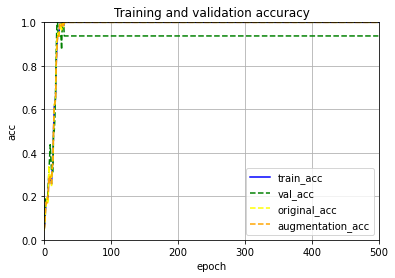

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1732, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0439, val_loss: 0.1618, val_acc: 0.2500, val_f: 0.1158
Epoch [21/500], Loss: 0.0150, val_loss: 0.0577, val_acc: 0.8125, val_f: 0.7500
Epoch [31/500], Loss: 0.0040, val_loss: 0.0280, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0016, val_loss: 0.0192, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0011, val_loss: 0.0175, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0007, val_loss: 0.0172, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0005, val_loss: 0.0168, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0004, val_loss: 0.0169, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0003, val_loss: 0.0170, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0003, val_loss: 0.0167, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0002, val_loss: 0.0181, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0002, val_loss: 0.0187, v

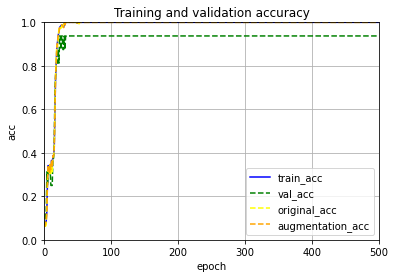

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0432, val_loss: 0.1590, val_acc: 0.4375, val_f: 0.3000
Epoch [21/500], Loss: 0.0144, val_loss: 0.0503, val_acc: 0.8750, val_f: 0.8333
Epoch [31/500], Loss: 0.0038, val_loss: 0.0223, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0018, val_loss: 0.0073, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0010, val_loss: 0.0042, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0007, val_loss: 0.0030, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0005, val_loss: 0.0022, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0004, val_loss: 0.0017, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0003, val_loss: 0.0014, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0003, val_loss: 0.0011, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0002, val_loss: 0.0009, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0002, val_loss: 0.0008, v

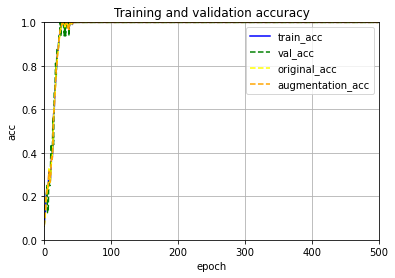

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0430, val_loss: 0.1573, val_acc: 0.3750, val_f: 0.2708
Epoch [21/500], Loss: 0.0133, val_loss: 0.0477, val_acc: 0.9375, val_f: 0.9167
Epoch [31/500], Loss: 0.0040, val_loss: 0.0222, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0019, val_loss: 0.0117, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0011, val_loss: 0.0099, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0007, val_loss: 0.0057, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0005, val_loss: 0.0039, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0004, val_loss: 0.0031, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0003, val_loss: 0.0025, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0003, val_loss: 0.0022, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0002, val_loss: 0.0018, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0002, val_loss: 0.0016, v

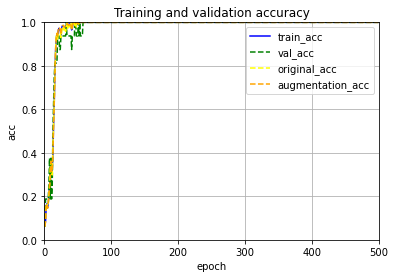

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0435, val_loss: 0.1596, val_acc: 0.2500, val_f: 0.1354
Epoch [21/500], Loss: 0.0148, val_loss: 0.0520, val_acc: 0.9375, val_f: 0.9167
Epoch [31/500], Loss: 0.0040, val_loss: 0.0140, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0016, val_loss: 0.0058, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0009, val_loss: 0.0034, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0006, val_loss: 0.0023, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0005, val_loss: 0.0017, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0004, val_loss: 0.0013, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0003, val_loss: 0.0011, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0002, val_loss: 0.0009, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0002, val_loss: 0.0008, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0002, val_loss: 0.0006, v

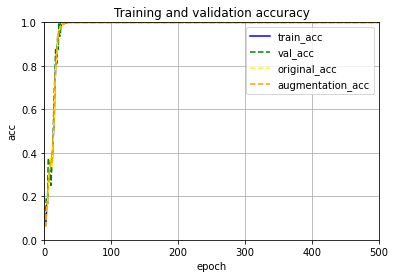

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1729, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0430, val_loss: 0.1574, val_acc: 0.3750, val_f: 0.2437
Epoch [21/500], Loss: 0.0142, val_loss: 0.0500, val_acc: 0.8750, val_f: 0.8333
Epoch [31/500], Loss: 0.0049, val_loss: 0.0165, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0018, val_loss: 0.0068, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0010, val_loss: 0.0042, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0015, val_loss: 0.0047, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0005, val_loss: 0.0020, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0004, val_loss: 0.0016, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0003, val_loss: 0.0013, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0003, val_loss: 0.0011, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0002, val_loss: 0.0009, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0002, val_loss: 0.0008, v

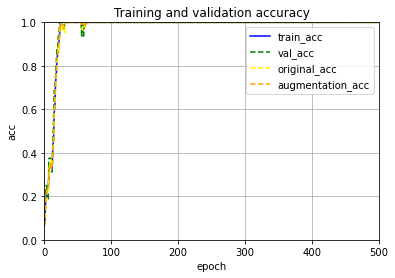

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0436, val_loss: 0.1606, val_acc: 0.3750, val_f: 0.2929
Epoch [21/500], Loss: 0.0148, val_loss: 0.0514, val_acc: 0.8750, val_f: 0.8333
Epoch [31/500], Loss: 0.0039, val_loss: 0.0153, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0018, val_loss: 0.0097, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0016, val_loss: 0.0076, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0007, val_loss: 0.0036, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0005, val_loss: 0.0029, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0004, val_loss: 0.0022, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0003, val_loss: 0.0018, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0003, val_loss: 0.0014, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0002, val_loss: 0.0013, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0002, val_loss: 0.0011, v

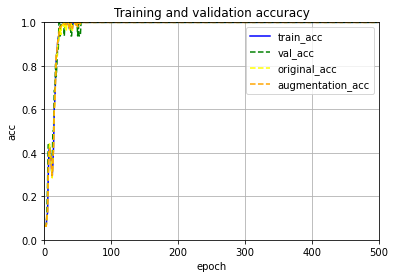

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.0625, val_f: 0.0089
Epoch [11/500], Loss: 0.0428, val_loss: 0.1578, val_acc: 0.3750, val_f: 0.2792
Epoch [21/500], Loss: 0.0141, val_loss: 0.0498, val_acc: 0.9375, val_f: 0.9167
Epoch [31/500], Loss: 0.0050, val_loss: 0.0229, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0022, val_loss: 0.0134, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0012, val_loss: 0.0089, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0008, val_loss: 0.0070, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0006, val_loss: 0.0054, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0004, val_loss: 0.0055, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0003, val_loss: 0.0040, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0003, val_loss: 0.0052, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0002, val_loss: 0.0036, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0002, val_loss: 0.0030, v

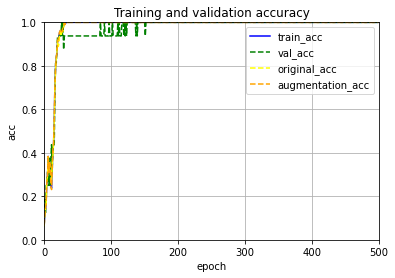

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0431, val_loss: 0.1593, val_acc: 0.4375, val_f: 0.3167
Epoch [21/500], Loss: 0.0137, val_loss: 0.0458, val_acc: 1.0000, val_f: 1.0000
Epoch [31/500], Loss: 0.0036, val_loss: 0.0128, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0021, val_loss: 0.0073, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0010, val_loss: 0.0041, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0007, val_loss: 0.0029, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0005, val_loss: 0.0022, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0004, val_loss: 0.0018, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0003, val_loss: 0.0014, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0003, val_loss: 0.0012, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0002, val_loss: 0.0010, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0002, val_loss: 0.0009, v

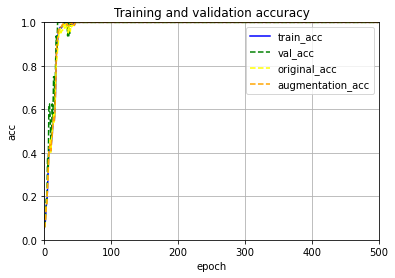

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1733, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0433, val_loss: 0.1661, val_acc: 0.1875, val_f: 0.0917
Epoch [21/500], Loss: 0.0160, val_loss: 0.0750, val_acc: 0.5000, val_f: 0.3958
Epoch [31/500], Loss: 0.0051, val_loss: 0.0421, val_acc: 0.8125, val_f: 0.7500
Epoch [41/500], Loss: 0.0019, val_loss: 0.0261, val_acc: 0.8125, val_f: 0.7500
Epoch [51/500], Loss: 0.0011, val_loss: 0.0203, val_acc: 0.8750, val_f: 0.8333
Epoch [61/500], Loss: 0.0007, val_loss: 0.0185, val_acc: 0.8125, val_f: 0.7500
Epoch [71/500], Loss: 0.0005, val_loss: 0.0163, val_acc: 0.8125, val_f: 0.7500
Epoch [81/500], Loss: 0.0004, val_loss: 0.0153, val_acc: 0.8750, val_f: 0.8333
Epoch [91/500], Loss: 0.0003, val_loss: 0.0156, val_acc: 0.8750, val_f: 0.8333
Epoch [101/500], Loss: 0.0003, val_loss: 0.0152, val_acc: 0.8125, val_f: 0.7500
Epoch [111/500], Loss: 0.0002, val_loss: 0.0148, val_acc: 0.8125, val_f: 0.7500
Epoch [121/500], Loss: 0.0002, val_loss: 0.0149, v

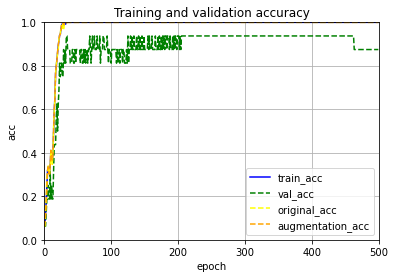

[0.875]




Epoch [1/500], Loss: 0.0461, val_loss: 0.1727, val_acc: 0.1250, val_f: 0.0875
Epoch [11/500], Loss: 0.0395, val_loss: 0.1488, val_acc: 0.3125, val_f: 0.1917
Epoch [21/500], Loss: 0.0079, val_loss: 0.0359, val_acc: 0.9375, val_f: 0.9167
Epoch [31/500], Loss: 0.0013, val_loss: 0.0190, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0006, val_loss: 0.0211, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0004, val_loss: 0.0205, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0003, val_loss: 0.0210, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0002, val_loss: 0.0221, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0002, val_loss: 0.0227, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0001, val_loss: 0.0236, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0001, val_loss: 0.0241, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0001, val_loss: 0.0247, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0001, val_loss: 0.0252, v

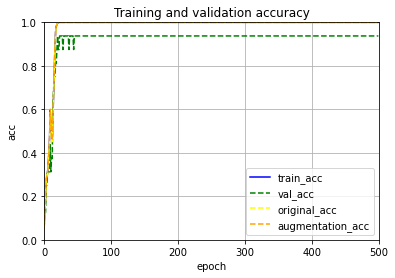

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1726, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0403, val_loss: 0.1464, val_acc: 0.4375, val_f: 0.3095
Epoch [21/500], Loss: 0.0083, val_loss: 0.0284, val_acc: 1.0000, val_f: 1.0000
Epoch [31/500], Loss: 0.0017, val_loss: 0.0065, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0008, val_loss: 0.0032, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0005, val_loss: 0.0020, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0004, val_loss: 0.0014, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0003, val_loss: 0.0010, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0002, val_loss: 0.0008, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0002, val_loss: 0.0007, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0001, val_loss: 0.0006, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0001, val_loss: 0.0005, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0001, val_loss: 0.0004, v

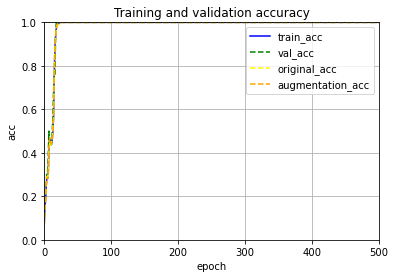

[1.0]



Epoch [1/500], Loss: 0.0461, val_loss: 0.1723, val_acc: 0.1875, val_f: 0.1076
Epoch [11/500], Loss: 0.0398, val_loss: 0.1437, val_acc: 0.6250, val_f: 0.5208
Epoch [21/500], Loss: 0.0069, val_loss: 0.0229, val_acc: 1.0000, val_f: 1.0000
Epoch [31/500], Loss: 0.0013, val_loss: 0.0046, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0006, val_loss: 0.0023, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0004, val_loss: 0.0015, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0003, val_loss: 0.0011, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0002, val_loss: 0.0009, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0002, val_loss: 0.0007, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0001, val_loss: 0.0006, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0001, val_loss: 0.0005, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0001, val_loss: 0.0004, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0001, val_loss: 0.0004, v

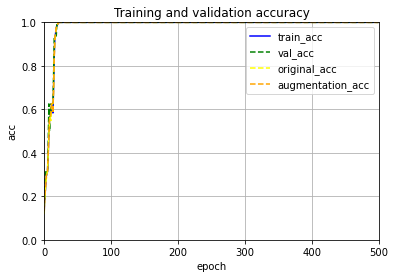

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1728, val_acc: 0.1250, val_f: 0.0703
Epoch [11/500], Loss: 0.0405, val_loss: 0.1474, val_acc: 0.6250, val_f: 0.5312
Epoch [21/500], Loss: 0.0080, val_loss: 0.0246, val_acc: 1.0000, val_f: 1.0000
Epoch [31/500], Loss: 0.0015, val_loss: 0.0053, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0007, val_loss: 0.0026, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0005, val_loss: 0.0017, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0003, val_loss: 0.0012, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0002, val_loss: 0.0009, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0002, val_loss: 0.0007, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0002, val_loss: 0.0006, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0001, val_loss: 0.0005, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0001, val_loss: 0.0004, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0001, val_loss: 0.0004, v

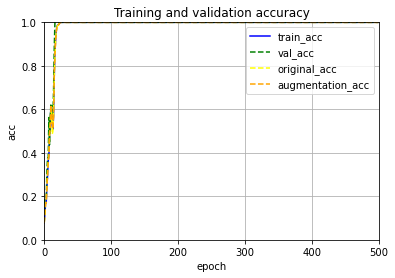

[1.0]



Epoch [1/500], Loss: 0.0461, val_loss: 0.1726, val_acc: 0.1250, val_f: 0.0708
Epoch [11/500], Loss: 0.0412, val_loss: 0.1510, val_acc: 0.6250, val_f: 0.5521
Epoch [21/500], Loss: 0.0074, val_loss: 0.0253, val_acc: 1.0000, val_f: 1.0000
Epoch [31/500], Loss: 0.0014, val_loss: 0.0057, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0007, val_loss: 0.0029, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0004, val_loss: 0.0019, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0003, val_loss: 0.0014, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0002, val_loss: 0.0011, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0002, val_loss: 0.0009, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0001, val_loss: 0.0008, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0001, val_loss: 0.0006, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0001, val_loss: 0.0005, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0001, val_loss: 0.0004, v

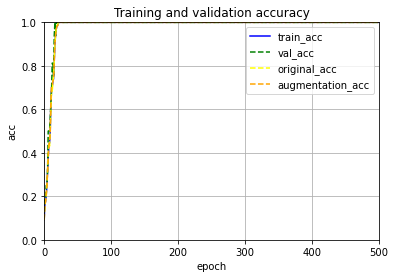

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1726, val_acc: 0.1250, val_f: 0.0703
Epoch [11/500], Loss: 0.0392, val_loss: 0.1416, val_acc: 0.6250, val_f: 0.5208
Epoch [21/500], Loss: 0.0057, val_loss: 0.0302, val_acc: 0.9375, val_f: 0.9167
Epoch [31/500], Loss: 0.0012, val_loss: 0.0206, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0006, val_loss: 0.0193, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0004, val_loss: 0.0190, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0003, val_loss: 0.0185, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0002, val_loss: 0.0181, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0002, val_loss: 0.0180, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0001, val_loss: 0.0179, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0001, val_loss: 0.0182, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0001, val_loss: 0.0184, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0001, val_loss: 0.0186, v

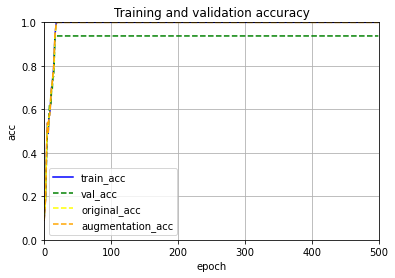

[0.9375]



Epoch [1/500], Loss: 0.0461, val_loss: 0.1724, val_acc: 0.1250, val_f: 0.0703
Epoch [11/500], Loss: 0.0396, val_loss: 0.1422, val_acc: 0.5625, val_f: 0.4521
Epoch [21/500], Loss: 0.0081, val_loss: 0.0268, val_acc: 1.0000, val_f: 1.0000
Epoch [31/500], Loss: 0.0014, val_loss: 0.0058, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0007, val_loss: 0.0030, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0004, val_loss: 0.0018, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0003, val_loss: 0.0013, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0002, val_loss: 0.0010, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0002, val_loss: 0.0008, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0002, val_loss: 0.0007, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0001, val_loss: 0.0006, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0001, val_loss: 0.0005, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0001, val_loss: 0.0004, v

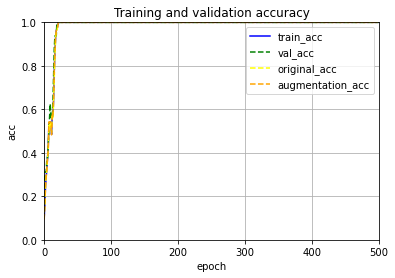

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1725, val_acc: 0.1250, val_f: 0.0703
Epoch [11/500], Loss: 0.0400, val_loss: 0.1453, val_acc: 0.6875, val_f: 0.5833
Epoch [21/500], Loss: 0.0057, val_loss: 0.0175, val_acc: 1.0000, val_f: 1.0000
Epoch [31/500], Loss: 0.0011, val_loss: 0.0040, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0005, val_loss: 0.0021, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0003, val_loss: 0.0013, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0002, val_loss: 0.0010, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0002, val_loss: 0.0008, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0001, val_loss: 0.0006, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0001, val_loss: 0.0005, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0001, val_loss: 0.0004, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0001, val_loss: 0.0004, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0001, val_loss: 0.0003, v

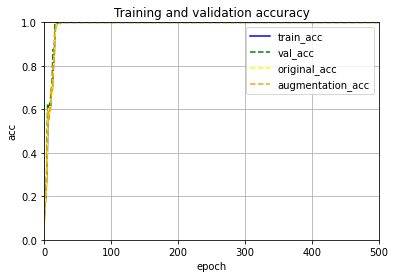

[1.0]



Epoch [1/500], Loss: 0.0461, val_loss: 0.1725, val_acc: 0.1250, val_f: 0.0703
Epoch [11/500], Loss: 0.0395, val_loss: 0.1454, val_acc: 0.6250, val_f: 0.5250
Epoch [21/500], Loss: 0.0069, val_loss: 0.0306, val_acc: 0.8750, val_f: 0.8333
Epoch [31/500], Loss: 0.0014, val_loss: 0.0082, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0006, val_loss: 0.0042, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0004, val_loss: 0.0027, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0003, val_loss: 0.0022, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0002, val_loss: 0.0017, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0002, val_loss: 0.0013, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0001, val_loss: 0.0011, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0001, val_loss: 0.0009, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0001, val_loss: 0.0007, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0001, val_loss: 0.0007, v

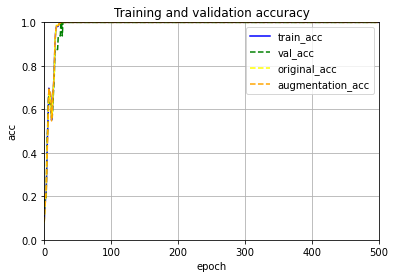

[1.0]



Epoch [1/500], Loss: 0.0461, val_loss: 0.1727, val_acc: 0.1250, val_f: 0.0703
Epoch [11/500], Loss: 0.0389, val_loss: 0.1465, val_acc: 0.4375, val_f: 0.3167
Epoch [21/500], Loss: 0.0054, val_loss: 0.0434, val_acc: 0.8750, val_f: 0.8542
Epoch [31/500], Loss: 0.0011, val_loss: 0.0255, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0005, val_loss: 0.0215, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0003, val_loss: 0.0194, val_acc: 0.8750, val_f: 0.8542
Epoch [61/500], Loss: 0.0002, val_loss: 0.0178, val_acc: 0.8750, val_f: 0.8542
Epoch [71/500], Loss: 0.0002, val_loss: 0.0172, val_acc: 0.8750, val_f: 0.8542
Epoch [81/500], Loss: 0.0001, val_loss: 0.0172, val_acc: 0.8750, val_f: 0.8542
Epoch [91/500], Loss: 0.0001, val_loss: 0.0161, val_acc: 0.8750, val_f: 0.8542
Epoch [101/500], Loss: 0.0001, val_loss: 0.0160, val_acc: 0.8750, val_f: 0.8542
Epoch [111/500], Loss: 0.0001, val_loss: 0.0155, val_acc: 0.8750, val_f: 0.8542
Epoch [121/500], Loss: 0.0001, val_loss: 0.0153, v

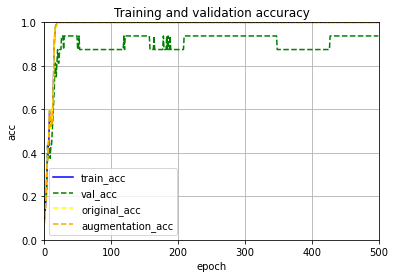

[0.9375]




Epoch [1/500], Loss: 0.0461, val_loss: 0.1726, val_acc: 0.1250, val_f: 0.0703
Epoch [11/500], Loss: 0.0383, val_loss: 0.1391, val_acc: 0.3125, val_f: 0.1708
Epoch [21/500], Loss: 0.0126, val_loss: 0.0470, val_acc: 0.8125, val_f: 0.7500
Epoch [31/500], Loss: 0.0053, val_loss: 0.0235, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0029, val_loss: 0.0157, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0017, val_loss: 0.0075, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0014, val_loss: 0.0065, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0008, val_loss: 0.0101, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0006, val_loss: 0.0061, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0005, val_loss: 0.0072, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0004, val_loss: 0.0072, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0003, val_loss: 0.0080, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0003, val_loss: 0.0083, v

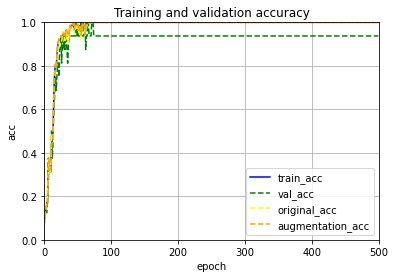

[0.9375]



Epoch [1/500], Loss: 0.0461, val_loss: 0.1726, val_acc: 0.1875, val_f: 0.0920
Epoch [11/500], Loss: 0.0381, val_loss: 0.1387, val_acc: 0.1875, val_f: 0.0647
Epoch [21/500], Loss: 0.0096, val_loss: 0.0331, val_acc: 0.8750, val_f: 0.8333
Epoch [31/500], Loss: 0.0043, val_loss: 0.0158, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0028, val_loss: 0.0125, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0031, val_loss: 0.0101, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0009, val_loss: 0.0038, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0015, val_loss: 0.0061, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0011, val_loss: 0.0066, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0010, val_loss: 0.0066, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0005, val_loss: 0.0017, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0003, val_loss: 0.0013, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0003, val_loss: 0.0013, v

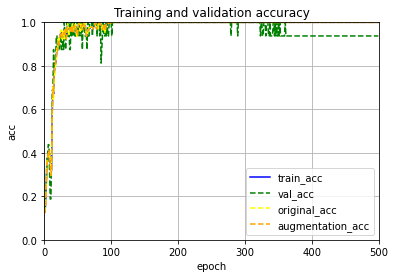

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1726, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0384, val_loss: 0.1400, val_acc: 0.5000, val_f: 0.3792
Epoch [21/500], Loss: 0.0116, val_loss: 0.0408, val_acc: 0.8750, val_f: 0.8333
Epoch [31/500], Loss: 0.0044, val_loss: 0.0220, val_acc: 0.8750, val_f: 0.8333
Epoch [41/500], Loss: 0.0022, val_loss: 0.0124, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0013, val_loss: 0.0079, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0008, val_loss: 0.0039, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0005, val_loss: 0.0029, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0004, val_loss: 0.0023, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0003, val_loss: 0.0019, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0003, val_loss: 0.0016, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0002, val_loss: 0.0014, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0002, val_loss: 0.0012, v

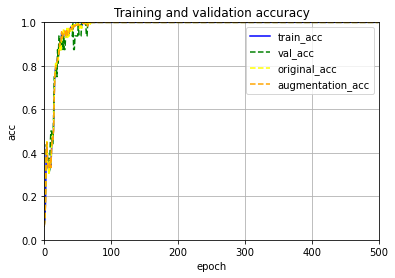

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1727, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0393, val_loss: 0.1430, val_acc: 0.5000, val_f: 0.3583
Epoch [21/500], Loss: 0.0141, val_loss: 0.0511, val_acc: 0.7500, val_f: 0.6667
Epoch [31/500], Loss: 0.0057, val_loss: 0.0219, val_acc: 0.8750, val_f: 0.8333
Epoch [41/500], Loss: 0.0035, val_loss: 0.0178, val_acc: 0.8750, val_f: 0.8333
Epoch [51/500], Loss: 0.0021, val_loss: 0.0163, val_acc: 0.8750, val_f: 0.8333
Epoch [61/500], Loss: 0.0016, val_loss: 0.0179, val_acc: 0.8750, val_f: 0.8333
Epoch [71/500], Loss: 0.0010, val_loss: 0.0281, val_acc: 0.8750, val_f: 0.8333
Epoch [81/500], Loss: 0.0009, val_loss: 0.0125, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0008, val_loss: 0.0198, val_acc: 0.8750, val_f: 0.8333
Epoch [101/500], Loss: 0.0004, val_loss: 0.0181, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0003, val_loss: 0.0180, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0003, val_loss: 0.0185, v

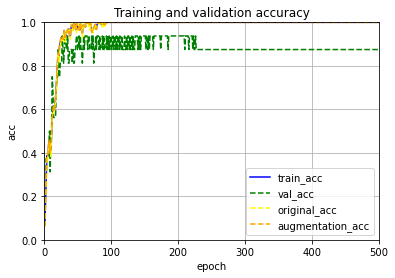

[0.875]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1728, val_acc: 0.1250, val_f: 0.0281
Epoch [11/500], Loss: 0.0384, val_loss: 0.1394, val_acc: 0.3750, val_f: 0.2417
Epoch [21/500], Loss: 0.0099, val_loss: 0.0349, val_acc: 0.7500, val_f: 0.7083
Epoch [31/500], Loss: 0.0041, val_loss: 0.0189, val_acc: 0.8750, val_f: 0.8333
Epoch [41/500], Loss: 0.0026, val_loss: 0.0128, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0014, val_loss: 0.0052, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0018, val_loss: 0.0146, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0007, val_loss: 0.0026, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0009, val_loss: 0.0055, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0005, val_loss: 0.0019, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0004, val_loss: 0.0015, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0003, val_loss: 0.0013, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0003, val_loss: 0.0011, v

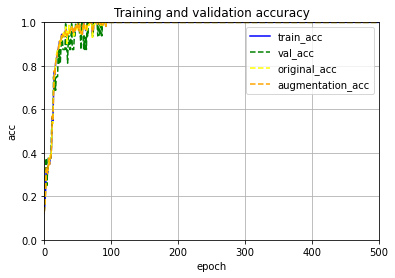

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1728, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0398, val_loss: 0.1452, val_acc: 0.3750, val_f: 0.2574
Epoch [21/500], Loss: 0.0128, val_loss: 0.0477, val_acc: 0.8125, val_f: 0.7500
Epoch [31/500], Loss: 0.0048, val_loss: 0.0243, val_acc: 0.8750, val_f: 0.8333
Epoch [41/500], Loss: 0.0033, val_loss: 0.0262, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0021, val_loss: 0.0096, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0014, val_loss: 0.0064, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0010, val_loss: 0.0047, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0006, val_loss: 0.0037, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0005, val_loss: 0.0029, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0004, val_loss: 0.0029, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0003, val_loss: 0.0022, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0003, val_loss: 0.0019, v

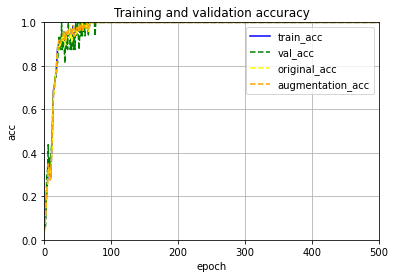

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1729, val_acc: 0.1250, val_f: 0.0500
Epoch [11/500], Loss: 0.0395, val_loss: 0.1440, val_acc: 0.1250, val_f: 0.0469
Epoch [21/500], Loss: 0.0171, val_loss: 0.0635, val_acc: 0.7500, val_f: 0.6771
Epoch [31/500], Loss: 0.0077, val_loss: 0.0313, val_acc: 0.8750, val_f: 0.8333
Epoch [41/500], Loss: 0.0048, val_loss: 0.0178, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0050, val_loss: 0.0191, val_acc: 0.8750, val_f: 0.8333
Epoch [61/500], Loss: 0.0022, val_loss: 0.0068, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0026, val_loss: 0.0052, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0014, val_loss: 0.0088, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0011, val_loss: 0.0033, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0008, val_loss: 0.0025, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0011, val_loss: 0.0030, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0009, val_loss: 0.0019, v

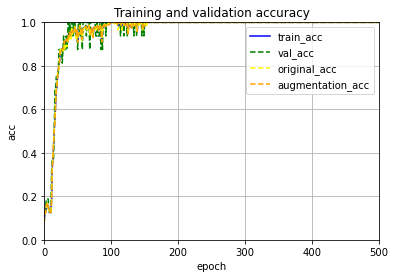

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1728, val_acc: 0.1250, val_f: 0.0281
Epoch [11/500], Loss: 0.0396, val_loss: 0.1441, val_acc: 0.3125, val_f: 0.1917
Epoch [21/500], Loss: 0.0137, val_loss: 0.0477, val_acc: 0.9375, val_f: 0.9167
Epoch [31/500], Loss: 0.0057, val_loss: 0.0199, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0027, val_loss: 0.0110, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0023, val_loss: 0.0089, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0010, val_loss: 0.0040, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0007, val_loss: 0.0029, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0006, val_loss: 0.0023, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0005, val_loss: 0.0019, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0004, val_loss: 0.0016, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0003, val_loss: 0.0013, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0003, val_loss: 0.0011, v

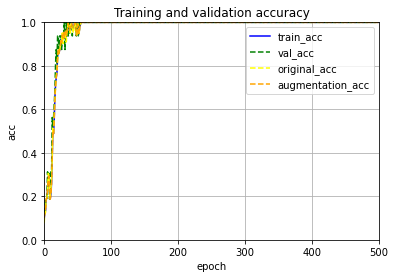

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0401, val_loss: 0.1464, val_acc: 0.3750, val_f: 0.2574
Epoch [21/500], Loss: 0.0132, val_loss: 0.0492, val_acc: 0.8750, val_f: 0.8333
Epoch [31/500], Loss: 0.0053, val_loss: 0.0232, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0029, val_loss: 0.0221, val_acc: 0.8750, val_f: 0.8333
Epoch [51/500], Loss: 0.0016, val_loss: 0.0098, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0011, val_loss: 0.0047, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0009, val_loss: 0.0066, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0006, val_loss: 0.0149, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0015, val_loss: 0.0203, val_acc: 0.8750, val_f: 0.8333
Epoch [101/500], Loss: 0.0013, val_loss: 0.0047, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0003, val_loss: 0.0019, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0003, val_loss: 0.0016, v

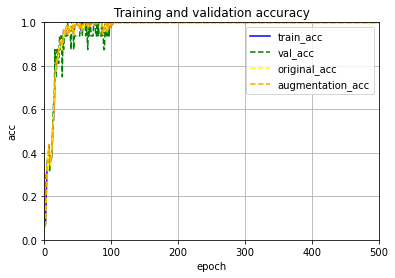

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1727, val_acc: 0.1875, val_f: 0.0979
Epoch [11/500], Loss: 0.0390, val_loss: 0.1426, val_acc: 0.3125, val_f: 0.1708
Epoch [21/500], Loss: 0.0141, val_loss: 0.0647, val_acc: 0.5000, val_f: 0.4062
Epoch [31/500], Loss: 0.0073, val_loss: 0.0432, val_acc: 0.6875, val_f: 0.5833
Epoch [41/500], Loss: 0.0043, val_loss: 0.0341, val_acc: 0.8750, val_f: 0.8333
Epoch [51/500], Loss: 0.0032, val_loss: 0.0402, val_acc: 0.7500, val_f: 0.6667
Epoch [61/500], Loss: 0.0032, val_loss: 0.0502, val_acc: 0.6250, val_f: 0.5625
Epoch [71/500], Loss: 0.0009, val_loss: 0.0441, val_acc: 0.8125, val_f: 0.7500
Epoch [81/500], Loss: 0.0007, val_loss: 0.0390, val_acc: 0.8750, val_f: 0.8333
Epoch [91/500], Loss: 0.0006, val_loss: 0.0398, val_acc: 0.8750, val_f: 0.8333
Epoch [101/500], Loss: 0.0005, val_loss: 0.0401, val_acc: 0.8750, val_f: 0.8333
Epoch [111/500], Loss: 0.0004, val_loss: 0.0409, val_acc: 0.8750, val_f: 0.8333
Epoch [121/500], Loss: 0.0003, val_loss: 0.0417, v

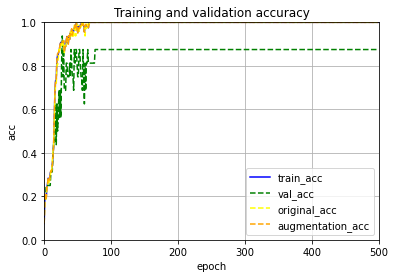

[0.875]




Epoch [1/500], Loss: 0.0462, val_loss: 0.1732, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0444, val_loss: 0.1649, val_acc: 0.6250, val_f: 0.5104
Epoch [21/500], Loss: 0.0150, val_loss: 0.0558, val_acc: 0.8125, val_f: 0.7500
Epoch [31/500], Loss: 0.0059, val_loss: 0.0263, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0042, val_loss: 0.0244, val_acc: 0.8750, val_f: 0.8333
Epoch [51/500], Loss: 0.0027, val_loss: 0.0172, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0026, val_loss: 0.0163, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0014, val_loss: 0.0086, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0010, val_loss: 0.0127, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0007, val_loss: 0.0118, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0009, val_loss: 0.0123, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0004, val_loss: 0.0114, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0004, val_loss: 0.0107, v

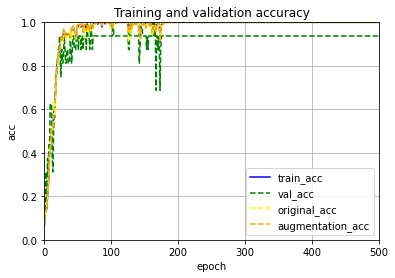

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1732, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0443, val_loss: 0.1646, val_acc: 0.5000, val_f: 0.3896
Epoch [21/500], Loss: 0.0165, val_loss: 0.0565, val_acc: 0.8750, val_f: 0.8333
Epoch [31/500], Loss: 0.0060, val_loss: 0.0200, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0035, val_loss: 0.0120, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0031, val_loss: 0.0069, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0027, val_loss: 0.0060, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0017, val_loss: 0.0037, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0018, val_loss: 0.0036, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0009, val_loss: 0.0026, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0014, val_loss: 0.0025, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0006, val_loss: 0.0019, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0009, val_loss: 0.0018, v

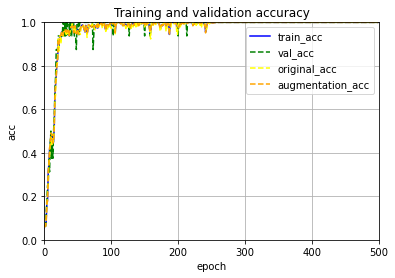

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1733, val_acc: 0.1250, val_f: 0.0346
Epoch [11/500], Loss: 0.0449, val_loss: 0.1674, val_acc: 0.3750, val_f: 0.2167
Epoch [21/500], Loss: 0.0189, val_loss: 0.0690, val_acc: 0.6875, val_f: 0.5938
Epoch [31/500], Loss: 0.0068, val_loss: 0.0227, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0039, val_loss: 0.0131, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0023, val_loss: 0.0067, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0014, val_loss: 0.0044, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0011, val_loss: 0.0035, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0007, val_loss: 0.0027, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0006, val_loss: 0.0023, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0005, val_loss: 0.0019, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0004, val_loss: 0.0016, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0003, val_loss: 0.0014, v

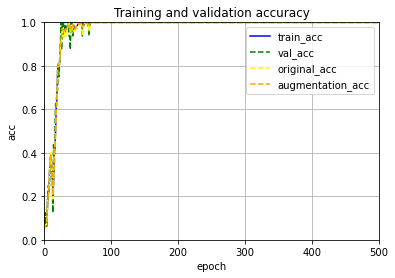

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1732, val_acc: 0.1250, val_f: 0.0500
Epoch [11/500], Loss: 0.0450, val_loss: 0.1681, val_acc: 0.3750, val_f: 0.2639
Epoch [21/500], Loss: 0.0172, val_loss: 0.0606, val_acc: 0.9375, val_f: 0.9167
Epoch [31/500], Loss: 0.0071, val_loss: 0.0294, val_acc: 0.8750, val_f: 0.8333
Epoch [41/500], Loss: 0.0043, val_loss: 0.0155, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0026, val_loss: 0.0152, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0022, val_loss: 0.0068, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0021, val_loss: 0.0088, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0013, val_loss: 0.0060, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0014, val_loss: 0.0049, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0023, val_loss: 0.0082, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0012, val_loss: 0.0041, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0012, val_loss: 0.0154, v

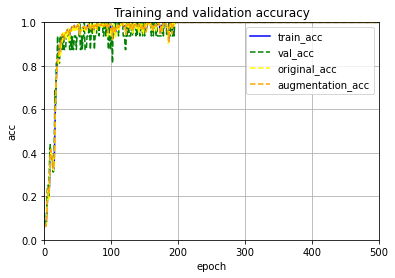

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1733, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0453, val_loss: 0.1687, val_acc: 0.4375, val_f: 0.3095
Epoch [21/500], Loss: 0.0160, val_loss: 0.0566, val_acc: 0.8750, val_f: 0.8333
Epoch [31/500], Loss: 0.0062, val_loss: 0.0336, val_acc: 0.8125, val_f: 0.7604
Epoch [41/500], Loss: 0.0027, val_loss: 0.0236, val_acc: 0.8750, val_f: 0.8333
Epoch [51/500], Loss: 0.0016, val_loss: 0.0183, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0041, val_loss: 0.0396, val_acc: 0.6875, val_f: 0.5938
Epoch [71/500], Loss: 0.0010, val_loss: 0.0162, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0007, val_loss: 0.0149, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0006, val_loss: 0.0139, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0005, val_loss: 0.0158, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0004, val_loss: 0.0155, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0003, val_loss: 0.0154, v

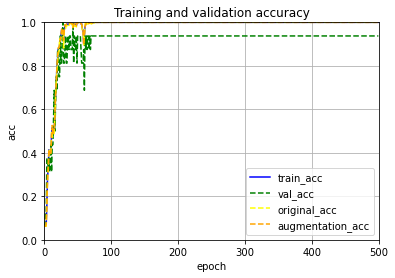

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.1250, val_f: 0.0304
Epoch [11/500], Loss: 0.0446, val_loss: 0.1655, val_acc: 0.3125, val_f: 0.1783
Epoch [21/500], Loss: 0.0189, val_loss: 0.0722, val_acc: 0.6250, val_f: 0.5000
Epoch [31/500], Loss: 0.0070, val_loss: 0.0332, val_acc: 0.8750, val_f: 0.8333
Epoch [41/500], Loss: 0.0035, val_loss: 0.0165, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0044, val_loss: 0.0262, val_acc: 0.8125, val_f: 0.7500
Epoch [61/500], Loss: 0.0017, val_loss: 0.0161, val_acc: 0.8750, val_f: 0.8333
Epoch [71/500], Loss: 0.0021, val_loss: 0.0155, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0013, val_loss: 0.0191, val_acc: 0.8750, val_f: 0.8333
Epoch [91/500], Loss: 0.0011, val_loss: 0.0120, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0010, val_loss: 0.0218, val_acc: 0.8750, val_f: 0.8333
Epoch [111/500], Loss: 0.0008, val_loss: 0.0133, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0017, val_loss: 0.0129, v

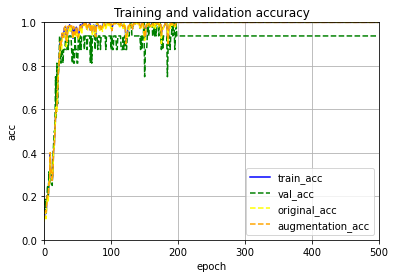

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1732, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0446, val_loss: 0.1655, val_acc: 0.3750, val_f: 0.2125
Epoch [21/500], Loss: 0.0176, val_loss: 0.0638, val_acc: 0.8125, val_f: 0.7500
Epoch [31/500], Loss: 0.0068, val_loss: 0.0269, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0035, val_loss: 0.0160, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0028, val_loss: 0.0078, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0017, val_loss: 0.0057, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0011, val_loss: 0.0197, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0008, val_loss: 0.0032, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0006, val_loss: 0.0031, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0005, val_loss: 0.0026, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0004, val_loss: 0.0023, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0004, val_loss: 0.0020, v

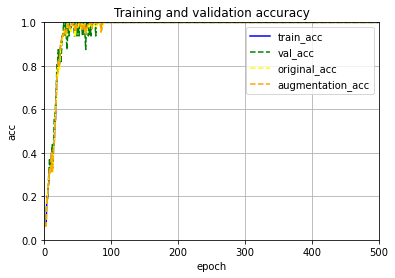

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1732, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0445, val_loss: 0.1655, val_acc: 0.3750, val_f: 0.2437
Epoch [21/500], Loss: 0.0158, val_loss: 0.0545, val_acc: 0.8750, val_f: 0.8333
Epoch [31/500], Loss: 0.0055, val_loss: 0.0282, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0029, val_loss: 0.0125, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0032, val_loss: 0.0118, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0022, val_loss: 0.0059, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0012, val_loss: 0.0039, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0012, val_loss: 0.0034, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0006, val_loss: 0.0031, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0005, val_loss: 0.0019, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0004, val_loss: 0.0016, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0003, val_loss: 0.0014, v

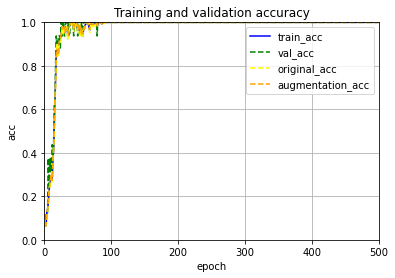

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.0625, val_f: 0.0078
Epoch [11/500], Loss: 0.0441, val_loss: 0.1632, val_acc: 0.5000, val_f: 0.3896
Epoch [21/500], Loss: 0.0159, val_loss: 0.0539, val_acc: 0.8125, val_f: 0.7500
Epoch [31/500], Loss: 0.0056, val_loss: 0.0264, val_acc: 0.8125, val_f: 0.7500
Epoch [41/500], Loss: 0.0037, val_loss: 0.0277, val_acc: 0.8125, val_f: 0.7500
Epoch [51/500], Loss: 0.0035, val_loss: 0.0203, val_acc: 0.8750, val_f: 0.8333
Epoch [61/500], Loss: 0.0014, val_loss: 0.0145, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0025, val_loss: 0.0244, val_acc: 0.8750, val_f: 0.8333
Epoch [81/500], Loss: 0.0016, val_loss: 0.0065, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0006, val_loss: 0.0143, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0011, val_loss: 0.0163, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0004, val_loss: 0.0026, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0004, val_loss: 0.0024, v

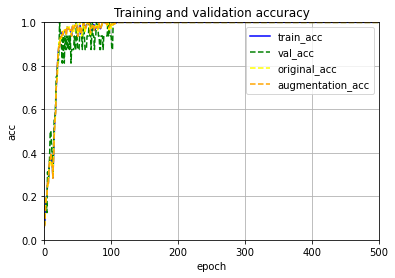

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1733, val_acc: 0.0625, val_f: 0.0078
Epoch [11/500], Loss: 0.0448, val_loss: 0.1666, val_acc: 0.3125, val_f: 0.2031
Epoch [21/500], Loss: 0.0190, val_loss: 0.0734, val_acc: 0.7500, val_f: 0.6667
Epoch [31/500], Loss: 0.0091, val_loss: 0.0542, val_acc: 0.7500, val_f: 0.7083
Epoch [41/500], Loss: 0.0044, val_loss: 0.0229, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0027, val_loss: 0.0245, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0030, val_loss: 0.0182, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0020, val_loss: 0.0107, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0011, val_loss: 0.0221, val_acc: 0.8125, val_f: 0.7500
Epoch [91/500], Loss: 0.0007, val_loss: 0.0147, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0006, val_loss: 0.0145, val_acc: 0.8750, val_f: 0.8333
Epoch [111/500], Loss: 0.0005, val_loss: 0.0154, val_acc: 0.8750, val_f: 0.8333
Epoch [121/500], Loss: 0.0004, val_loss: 0.0138, v

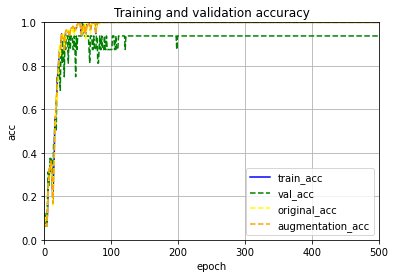

[0.9375]




Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.0625, val_f: 0.0179
Epoch [11/500], Loss: 0.0436, val_loss: 0.1620, val_acc: 0.4375, val_f: 0.2854
Epoch [21/500], Loss: 0.0153, val_loss: 0.0622, val_acc: 0.6875, val_f: 0.6250
Epoch [31/500], Loss: 0.0055, val_loss: 0.0306, val_acc: 0.8750, val_f: 0.8333
Epoch [41/500], Loss: 0.0034, val_loss: 0.0311, val_acc: 0.8125, val_f: 0.7500
Epoch [51/500], Loss: 0.0014, val_loss: 0.0164, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0010, val_loss: 0.0183, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0006, val_loss: 0.0142, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0005, val_loss: 0.0149, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0004, val_loss: 0.0140, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0003, val_loss: 0.0157, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0003, val_loss: 0.0132, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0002, val_loss: 0.0143, v

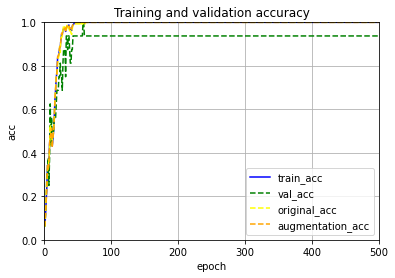

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.1250, val_f: 0.0703
Epoch [11/500], Loss: 0.0434, val_loss: 0.1606, val_acc: 0.5000, val_f: 0.3929
Epoch [21/500], Loss: 0.0164, val_loss: 0.0678, val_acc: 0.7500, val_f: 0.6875
Epoch [31/500], Loss: 0.0054, val_loss: 0.0242, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0021, val_loss: 0.0121, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0012, val_loss: 0.0094, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0008, val_loss: 0.0097, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0006, val_loss: 0.0065, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0004, val_loss: 0.0049, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0003, val_loss: 0.0044, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0003, val_loss: 0.0028, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0002, val_loss: 0.0028, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0002, val_loss: 0.0024, v

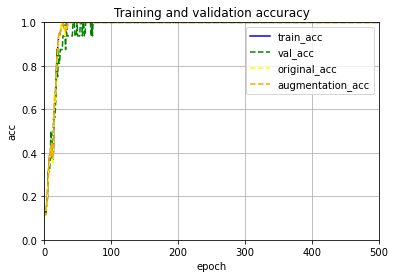

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1732, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0435, val_loss: 0.1610, val_acc: 0.3750, val_f: 0.2271
Epoch [21/500], Loss: 0.0159, val_loss: 0.0569, val_acc: 0.7500, val_f: 0.6667
Epoch [31/500], Loss: 0.0069, val_loss: 0.0302, val_acc: 0.8750, val_f: 0.8333
Epoch [41/500], Loss: 0.0036, val_loss: 0.0206, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0017, val_loss: 0.0064, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0013, val_loss: 0.0045, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0007, val_loss: 0.0029, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0006, val_loss: 0.0023, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0005, val_loss: 0.0018, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0004, val_loss: 0.0015, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0003, val_loss: 0.0013, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0003, val_loss: 0.0011, v

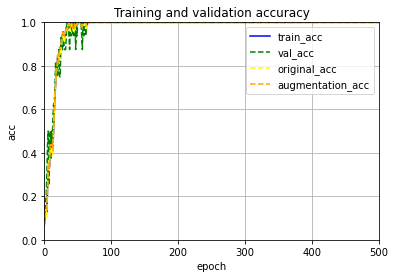

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.0625, val_f: 0.0089
Epoch [11/500], Loss: 0.0430, val_loss: 0.1584, val_acc: 0.3125, val_f: 0.2396
Epoch [21/500], Loss: 0.0155, val_loss: 0.0607, val_acc: 0.7500, val_f: 0.6667
Epoch [31/500], Loss: 0.0051, val_loss: 0.0240, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0034, val_loss: 0.0181, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0044, val_loss: 0.0204, val_acc: 0.8750, val_f: 0.8333
Epoch [61/500], Loss: 0.0015, val_loss: 0.0059, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0008, val_loss: 0.0060, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0006, val_loss: 0.0033, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0005, val_loss: 0.0026, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0004, val_loss: 0.0022, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0003, val_loss: 0.0019, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0003, val_loss: 0.0016, v

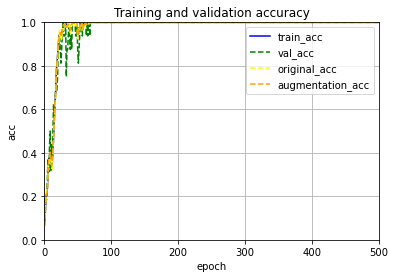

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1732, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0434, val_loss: 0.1608, val_acc: 0.6250, val_f: 0.5417
Epoch [21/500], Loss: 0.0169, val_loss: 0.0622, val_acc: 0.7500, val_f: 0.6771
Epoch [31/500], Loss: 0.0052, val_loss: 0.0248, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0022, val_loss: 0.0142, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0014, val_loss: 0.0160, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0024, val_loss: 0.0095, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0008, val_loss: 0.0105, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0006, val_loss: 0.0068, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0005, val_loss: 0.0075, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0004, val_loss: 0.0064, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0003, val_loss: 0.0067, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0003, val_loss: 0.0056, v

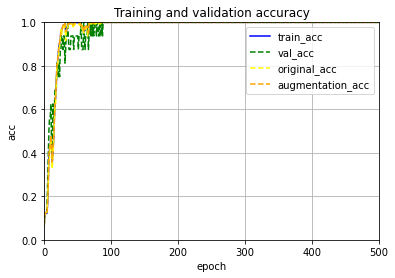

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1732, val_acc: 0.1250, val_f: 0.0703
Epoch [11/500], Loss: 0.0443, val_loss: 0.1648, val_acc: 0.3750, val_f: 0.2479
Epoch [21/500], Loss: 0.0174, val_loss: 0.0583, val_acc: 0.8750, val_f: 0.8333
Epoch [31/500], Loss: 0.0060, val_loss: 0.0204, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0026, val_loss: 0.0118, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0016, val_loss: 0.0053, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0009, val_loss: 0.0060, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0007, val_loss: 0.0034, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0005, val_loss: 0.0048, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0026, val_loss: 0.0055, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0006, val_loss: 0.0026, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0006, val_loss: 0.0021, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0003, val_loss: 0.0014, v

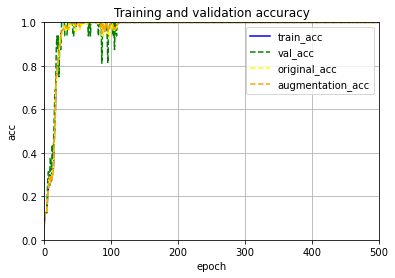

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1732, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0439, val_loss: 0.1626, val_acc: 0.3750, val_f: 0.2847
Epoch [21/500], Loss: 0.0185, val_loss: 0.0678, val_acc: 0.8750, val_f: 0.8438
Epoch [31/500], Loss: 0.0065, val_loss: 0.0246, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0027, val_loss: 0.0172, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0014, val_loss: 0.0186, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0009, val_loss: 0.0170, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0006, val_loss: 0.0167, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0005, val_loss: 0.0172, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0004, val_loss: 0.0172, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0003, val_loss: 0.0165, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0003, val_loss: 0.0175, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0002, val_loss: 0.0171, v

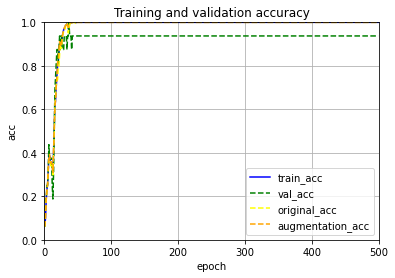

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.0625, val_f: 0.0078
Epoch [11/500], Loss: 0.0433, val_loss: 0.1594, val_acc: 0.4375, val_f: 0.3375
Epoch [21/500], Loss: 0.0138, val_loss: 0.0468, val_acc: 0.9375, val_f: 0.9167
Epoch [31/500], Loss: 0.0047, val_loss: 0.0173, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0018, val_loss: 0.0075, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0011, val_loss: 0.0042, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0007, val_loss: 0.0030, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0005, val_loss: 0.0022, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0004, val_loss: 0.0017, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0003, val_loss: 0.0013, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0003, val_loss: 0.0011, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0002, val_loss: 0.0009, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0002, val_loss: 0.0008, v

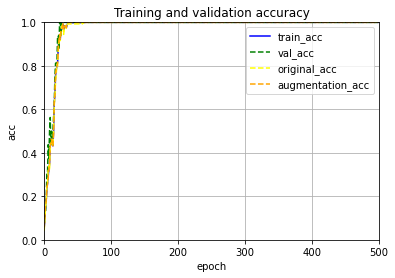

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1729, val_acc: 0.1875, val_f: 0.0688
Epoch [11/500], Loss: 0.0431, val_loss: 0.1584, val_acc: 0.2500, val_f: 0.1333
Epoch [21/500], Loss: 0.0142, val_loss: 0.0555, val_acc: 0.8750, val_f: 0.8333
Epoch [31/500], Loss: 0.0054, val_loss: 0.0240, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0034, val_loss: 0.0149, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0014, val_loss: 0.0062, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0033, val_loss: 0.0114, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0007, val_loss: 0.0042, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0006, val_loss: 0.0037, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0005, val_loss: 0.0032, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0004, val_loss: 0.0024, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0003, val_loss: 0.0020, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0003, val_loss: 0.0017, v

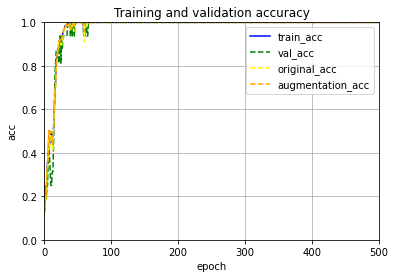

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.1250, val_f: 0.0292
Epoch [11/500], Loss: 0.0444, val_loss: 0.1657, val_acc: 0.2500, val_f: 0.1607
Epoch [21/500], Loss: 0.0206, val_loss: 0.0922, val_acc: 0.5625, val_f: 0.4583
Epoch [31/500], Loss: 0.0070, val_loss: 0.0552, val_acc: 0.8125, val_f: 0.7604
Epoch [41/500], Loss: 0.0026, val_loss: 0.0416, val_acc: 0.8125, val_f: 0.7604
Epoch [51/500], Loss: 0.0032, val_loss: 0.0478, val_acc: 0.7500, val_f: 0.6771
Epoch [61/500], Loss: 0.0011, val_loss: 0.0458, val_acc: 0.7500, val_f: 0.6771
Epoch [71/500], Loss: 0.0008, val_loss: 0.0464, val_acc: 0.8125, val_f: 0.7604
Epoch [81/500], Loss: 0.0006, val_loss: 0.0459, val_acc: 0.8125, val_f: 0.7604
Epoch [91/500], Loss: 0.0005, val_loss: 0.0470, val_acc: 0.8125, val_f: 0.7604
Epoch [101/500], Loss: 0.0004, val_loss: 0.0471, val_acc: 0.8125, val_f: 0.7604
Epoch [111/500], Loss: 0.0004, val_loss: 0.0476, val_acc: 0.8125, val_f: 0.7604
Epoch [121/500], Loss: 0.0003, val_loss: 0.0486, v

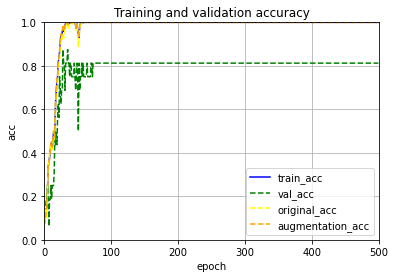

[0.8125]




Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0426, val_loss: 0.1579, val_acc: 0.3750, val_f: 0.2833
Epoch [21/500], Loss: 0.0157, val_loss: 0.0745, val_acc: 0.6250, val_f: 0.5625
Epoch [31/500], Loss: 0.0059, val_loss: 0.0482, val_acc: 0.8125, val_f: 0.7917
Epoch [41/500], Loss: 0.0029, val_loss: 0.0462, val_acc: 0.7500, val_f: 0.7292
Epoch [51/500], Loss: 0.0014, val_loss: 0.0450, val_acc: 0.7500, val_f: 0.7292
Epoch [61/500], Loss: 0.0014, val_loss: 0.0393, val_acc: 0.8125, val_f: 0.7500
Epoch [71/500], Loss: 0.0014, val_loss: 0.0599, val_acc: 0.6875, val_f: 0.6250
Epoch [81/500], Loss: 0.0006, val_loss: 0.0472, val_acc: 0.8125, val_f: 0.7708
Epoch [91/500], Loss: 0.0005, val_loss: 0.0494, val_acc: 0.7500, val_f: 0.7083
Epoch [101/500], Loss: 0.0004, val_loss: 0.0514, val_acc: 0.7500, val_f: 0.7083
Epoch [111/500], Loss: 0.0004, val_loss: 0.0513, val_acc: 0.7500, val_f: 0.7083
Epoch [121/500], Loss: 0.0003, val_loss: 0.0521, v

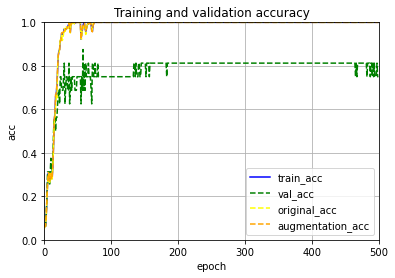

[0.75]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1727, val_acc: 0.1875, val_f: 0.0615
Epoch [11/500], Loss: 0.0397, val_loss: 0.1445, val_acc: 0.3750, val_f: 0.2679
Epoch [21/500], Loss: 0.0136, val_loss: 0.0505, val_acc: 0.8750, val_f: 0.8333
Epoch [31/500], Loss: 0.0059, val_loss: 0.0257, val_acc: 0.8750, val_f: 0.8333
Epoch [41/500], Loss: 0.0030, val_loss: 0.0093, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0014, val_loss: 0.0132, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0016, val_loss: 0.0047, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0007, val_loss: 0.0033, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0006, val_loss: 0.0027, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0005, val_loss: 0.0022, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0004, val_loss: 0.0020, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0003, val_loss: 0.0018, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0003, val_loss: 0.0016, v

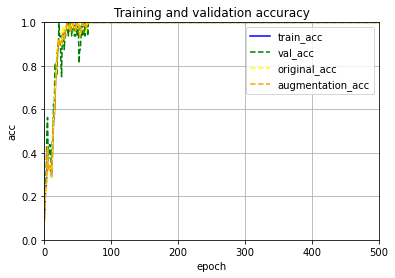

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0416, val_loss: 0.1520, val_acc: 0.2500, val_f: 0.1326
Epoch [21/500], Loss: 0.0152, val_loss: 0.0568, val_acc: 0.7500, val_f: 0.6875
Epoch [31/500], Loss: 0.0076, val_loss: 0.0456, val_acc: 0.8125, val_f: 0.7500
Epoch [41/500], Loss: 0.0029, val_loss: 0.0177, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0017, val_loss: 0.0178, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0015, val_loss: 0.0177, val_acc: 0.8750, val_f: 0.8542
Epoch [71/500], Loss: 0.0016, val_loss: 0.0142, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0008, val_loss: 0.0128, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0012, val_loss: 0.0047, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0008, val_loss: 0.0149, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0004, val_loss: 0.0125, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0003, val_loss: 0.0101, v

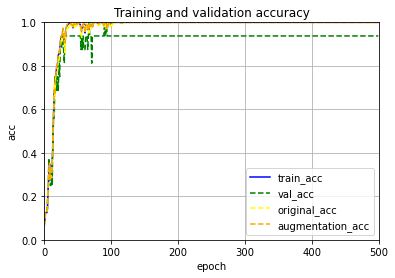

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0404, val_loss: 0.1465, val_acc: 0.3125, val_f: 0.1750
Epoch [21/500], Loss: 0.0168, val_loss: 0.0594, val_acc: 0.7500, val_f: 0.7083
Epoch [31/500], Loss: 0.0074, val_loss: 0.0279, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0036, val_loss: 0.0171, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0026, val_loss: 0.0154, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0020, val_loss: 0.0143, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0010, val_loss: 0.0098, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0007, val_loss: 0.0067, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0005, val_loss: 0.0058, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0004, val_loss: 0.0054, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0004, val_loss: 0.0053, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0003, val_loss: 0.0047, v

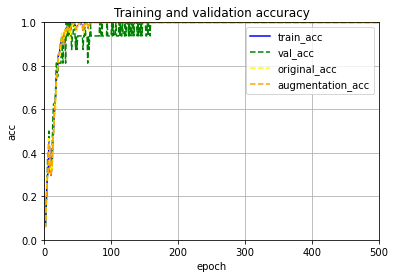

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1732, val_acc: 0.1250, val_f: 0.0317
Epoch [11/500], Loss: 0.0420, val_loss: 0.1537, val_acc: 0.1250, val_f: 0.0347
Epoch [21/500], Loss: 0.0191, val_loss: 0.0701, val_acc: 0.7500, val_f: 0.7083
Epoch [31/500], Loss: 0.0069, val_loss: 0.0288, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0027, val_loss: 0.0208, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0017, val_loss: 0.0162, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0009, val_loss: 0.0142, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0007, val_loss: 0.0150, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0005, val_loss: 0.0138, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0004, val_loss: 0.0135, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0003, val_loss: 0.0136, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0003, val_loss: 0.0137, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0002, val_loss: 0.0129, v

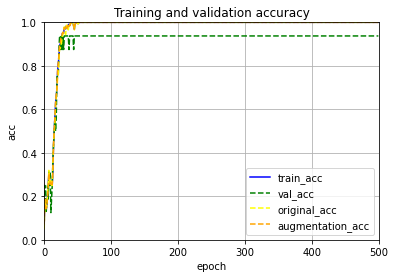

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.0625, val_f: 0.0179
Epoch [11/500], Loss: 0.0415, val_loss: 0.1514, val_acc: 0.1875, val_f: 0.0701
Epoch [21/500], Loss: 0.0179, val_loss: 0.0690, val_acc: 0.6250, val_f: 0.5208
Epoch [31/500], Loss: 0.0085, val_loss: 0.0427, val_acc: 0.6875, val_f: 0.6250
Epoch [41/500], Loss: 0.0042, val_loss: 0.0396, val_acc: 0.7500, val_f: 0.6875
Epoch [51/500], Loss: 0.0028, val_loss: 0.0318, val_acc: 0.7500, val_f: 0.6875
Epoch [61/500], Loss: 0.0017, val_loss: 0.0345, val_acc: 0.8750, val_f: 0.8333
Epoch [71/500], Loss: 0.0021, val_loss: 0.0328, val_acc: 0.8750, val_f: 0.8333
Epoch [81/500], Loss: 0.0018, val_loss: 0.0310, val_acc: 0.8125, val_f: 0.7500
Epoch [91/500], Loss: 0.0012, val_loss: 0.0299, val_acc: 0.8750, val_f: 0.8333
Epoch [101/500], Loss: 0.0011, val_loss: 0.0290, val_acc: 0.8750, val_f: 0.8333
Epoch [111/500], Loss: 0.0006, val_loss: 0.0318, val_acc: 0.8750, val_f: 0.8333
Epoch [121/500], Loss: 0.0010, val_loss: 0.0288, v

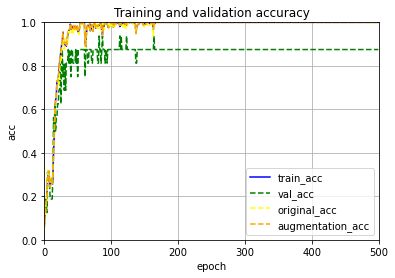

[0.875]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.1250, val_f: 0.0312
Epoch [11/500], Loss: 0.0403, val_loss: 0.1461, val_acc: 0.2500, val_f: 0.1222
Epoch [21/500], Loss: 0.0162, val_loss: 0.0591, val_acc: 0.7500, val_f: 0.6667
Epoch [31/500], Loss: 0.0066, val_loss: 0.0422, val_acc: 0.6875, val_f: 0.5833
Epoch [41/500], Loss: 0.0038, val_loss: 0.0344, val_acc: 0.7500, val_f: 0.6667
Epoch [51/500], Loss: 0.0018, val_loss: 0.0136, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0016, val_loss: 0.0121, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0008, val_loss: 0.0147, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0007, val_loss: 0.0151, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0005, val_loss: 0.0153, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0004, val_loss: 0.0160, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0004, val_loss: 0.0166, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0003, val_loss: 0.0171, v

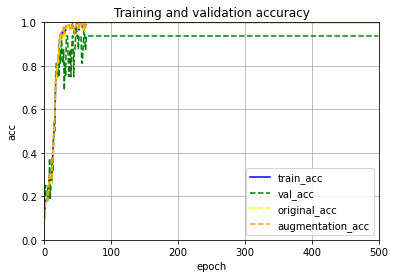

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0417, val_loss: 0.1522, val_acc: 0.1875, val_f: 0.0764
Epoch [21/500], Loss: 0.0186, val_loss: 0.0685, val_acc: 0.7500, val_f: 0.6667
Epoch [31/500], Loss: 0.0087, val_loss: 0.0368, val_acc: 0.8125, val_f: 0.7500
Epoch [41/500], Loss: 0.0043, val_loss: 0.0203, val_acc: 0.8750, val_f: 0.8333
Epoch [51/500], Loss: 0.0030, val_loss: 0.0102, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0026, val_loss: 0.0079, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0017, val_loss: 0.0103, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0009, val_loss: 0.0041, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0014, val_loss: 0.0035, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0005, val_loss: 0.0026, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0004, val_loss: 0.0019, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0004, val_loss: 0.0017, v

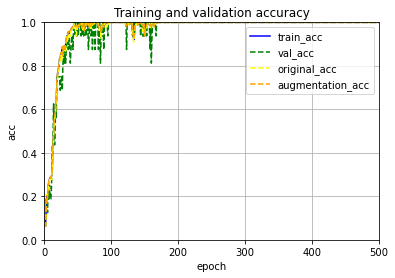

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.0625, val_f: 0.0156
Epoch [11/500], Loss: 0.0418, val_loss: 0.1529, val_acc: 0.2500, val_f: 0.1431
Epoch [21/500], Loss: 0.0168, val_loss: 0.0607, val_acc: 0.7500, val_f: 0.6667
Epoch [31/500], Loss: 0.0072, val_loss: 0.0300, val_acc: 0.8125, val_f: 0.7500
Epoch [41/500], Loss: 0.0039, val_loss: 0.0148, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0020, val_loss: 0.0082, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0018, val_loss: 0.0150, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0013, val_loss: 0.0045, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0007, val_loss: 0.0031, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0006, val_loss: 0.0025, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0005, val_loss: 0.0023, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0004, val_loss: 0.0019, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0004, val_loss: 0.0017, v

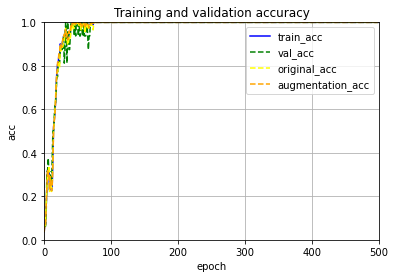

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.1250, val_f: 0.0346
Epoch [11/500], Loss: 0.0408, val_loss: 0.1485, val_acc: 0.2500, val_f: 0.1583
Epoch [21/500], Loss: 0.0185, val_loss: 0.0747, val_acc: 0.6875, val_f: 0.6042
Epoch [31/500], Loss: 0.0083, val_loss: 0.0438, val_acc: 0.8125, val_f: 0.7500
Epoch [41/500], Loss: 0.0044, val_loss: 0.0293, val_acc: 0.8125, val_f: 0.7604
Epoch [51/500], Loss: 0.0024, val_loss: 0.0190, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0015, val_loss: 0.0131, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0010, val_loss: 0.0147, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0007, val_loss: 0.0138, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0006, val_loss: 0.0133, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0005, val_loss: 0.0128, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0004, val_loss: 0.0119, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0003, val_loss: 0.0111, v

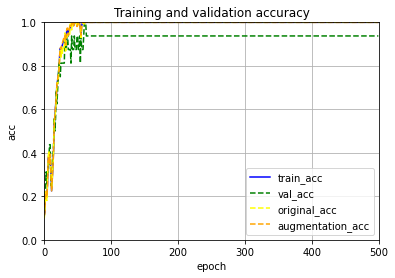

[0.9375]




Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0419, val_loss: 0.1533, val_acc: 0.2500, val_f: 0.1083
Epoch [21/500], Loss: 0.0193, val_loss: 0.0809, val_acc: 0.5625, val_f: 0.4583
Epoch [31/500], Loss: 0.0072, val_loss: 0.0574, val_acc: 0.6875, val_f: 0.5833
Epoch [41/500], Loss: 0.0034, val_loss: 0.0527, val_acc: 0.7500, val_f: 0.6667
Epoch [51/500], Loss: 0.0020, val_loss: 0.0679, val_acc: 0.6875, val_f: 0.5833
Epoch [61/500], Loss: 0.0013, val_loss: 0.0649, val_acc: 0.6875, val_f: 0.5833
Epoch [71/500], Loss: 0.0008, val_loss: 0.0656, val_acc: 0.6875, val_f: 0.5938
Epoch [81/500], Loss: 0.0014, val_loss: 0.0733, val_acc: 0.6875, val_f: 0.5938
Epoch [91/500], Loss: 0.0023, val_loss: 0.0721, val_acc: 0.7500, val_f: 0.6771
Epoch [101/500], Loss: 0.0007, val_loss: 0.0727, val_acc: 0.6875, val_f: 0.5938
Epoch [111/500], Loss: 0.0004, val_loss: 0.0734, val_acc: 0.6875, val_f: 0.5938
Epoch [121/500], Loss: 0.0004, val_loss: 0.0763, v

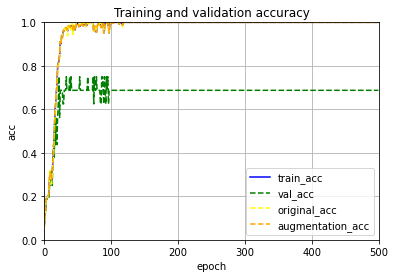

[0.6875]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.0625, val_f: 0.0125
Epoch [11/500], Loss: 0.0423, val_loss: 0.1542, val_acc: 0.3125, val_f: 0.1875
Epoch [21/500], Loss: 0.0159, val_loss: 0.0612, val_acc: 0.8750, val_f: 0.8333
Epoch [31/500], Loss: 0.0051, val_loss: 0.0171, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0034, val_loss: 0.0150, val_acc: 0.8750, val_f: 0.8333
Epoch [51/500], Loss: 0.0019, val_loss: 0.0099, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0013, val_loss: 0.0040, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0011, val_loss: 0.0165, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0012, val_loss: 0.0032, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0006, val_loss: 0.0041, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0018, val_loss: 0.0136, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0007, val_loss: 0.0044, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0010, val_loss: 0.0048, v

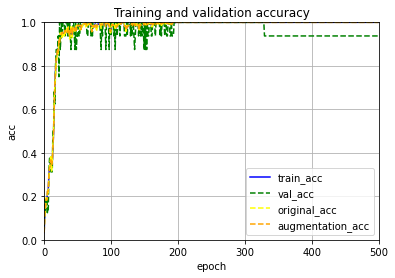

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0414, val_loss: 0.1519, val_acc: 0.2500, val_f: 0.1406
Epoch [21/500], Loss: 0.0178, val_loss: 0.0653, val_acc: 0.8125, val_f: 0.7500
Epoch [31/500], Loss: 0.0068, val_loss: 0.0278, val_acc: 0.8750, val_f: 0.8333
Epoch [41/500], Loss: 0.0036, val_loss: 0.0222, val_acc: 0.8750, val_f: 0.8333
Epoch [51/500], Loss: 0.0019, val_loss: 0.0182, val_acc: 0.8750, val_f: 0.8333
Epoch [61/500], Loss: 0.0018, val_loss: 0.0174, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0024, val_loss: 0.0191, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0011, val_loss: 0.0163, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0011, val_loss: 0.0204, val_acc: 0.8750, val_f: 0.8333
Epoch [101/500], Loss: 0.0008, val_loss: 0.0168, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0006, val_loss: 0.0176, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0006, val_loss: 0.0172, v

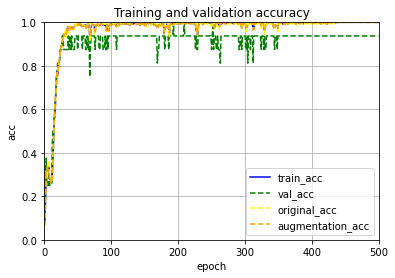

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.0625, val_f: 0.0104
Epoch [11/500], Loss: 0.0428, val_loss: 0.1571, val_acc: 0.2500, val_f: 0.1639
Epoch [21/500], Loss: 0.0206, val_loss: 0.0703, val_acc: 0.7500, val_f: 0.6917
Epoch [31/500], Loss: 0.0087, val_loss: 0.0282, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0053, val_loss: 0.0172, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0030, val_loss: 0.0106, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0026, val_loss: 0.0068, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0014, val_loss: 0.0047, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0011, val_loss: 0.0066, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0019, val_loss: 0.0123, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0013, val_loss: 0.0033, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0008, val_loss: 0.0025, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0006, val_loss: 0.0035, v

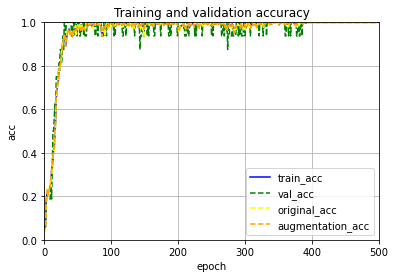

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0425, val_loss: 0.1564, val_acc: 0.2500, val_f: 0.1448
Epoch [21/500], Loss: 0.0194, val_loss: 0.0660, val_acc: 0.8125, val_f: 0.7500
Epoch [31/500], Loss: 0.0090, val_loss: 0.0277, val_acc: 0.8750, val_f: 0.8333
Epoch [41/500], Loss: 0.0041, val_loss: 0.0143, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0040, val_loss: 0.0086, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0019, val_loss: 0.0064, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0016, val_loss: 0.0043, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0013, val_loss: 0.0044, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0012, val_loss: 0.0030, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0015, val_loss: 0.0050, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0012, val_loss: 0.0029, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0010, val_loss: 0.0021, v

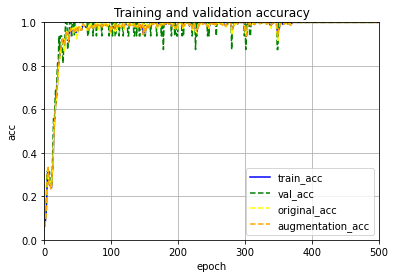

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1729, val_acc: 0.0625, val_f: 0.0096
Epoch [11/500], Loss: 0.0411, val_loss: 0.1501, val_acc: 0.1875, val_f: 0.0781
Epoch [21/500], Loss: 0.0183, val_loss: 0.0603, val_acc: 0.9375, val_f: 0.9167
Epoch [31/500], Loss: 0.0077, val_loss: 0.0335, val_acc: 0.8750, val_f: 0.8333
Epoch [41/500], Loss: 0.0050, val_loss: 0.0128, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0033, val_loss: 0.0084, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0034, val_loss: 0.0093, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0024, val_loss: 0.0100, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0021, val_loss: 0.0048, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0013, val_loss: 0.0051, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0019, val_loss: 0.0107, val_acc: 0.8750, val_f: 0.8333
Epoch [111/500], Loss: 0.0017, val_loss: 0.0035, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0015, val_loss: 0.0046, v

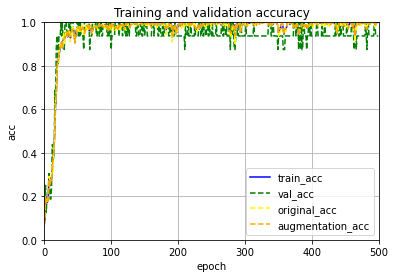

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1729, val_acc: 0.0625, val_f: 0.0096
Epoch [11/500], Loss: 0.0415, val_loss: 0.1513, val_acc: 0.4375, val_f: 0.3021
Epoch [21/500], Loss: 0.0151, val_loss: 0.0507, val_acc: 0.9375, val_f: 0.9167
Epoch [31/500], Loss: 0.0048, val_loss: 0.0217, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0031, val_loss: 0.0205, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0023, val_loss: 0.0226, val_acc: 0.8750, val_f: 0.8333
Epoch [61/500], Loss: 0.0016, val_loss: 0.0185, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0013, val_loss: 0.0190, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0013, val_loss: 0.0032, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0010, val_loss: 0.0149, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0008, val_loss: 0.0178, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0007, val_loss: 0.0177, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0008, val_loss: 0.0240, v

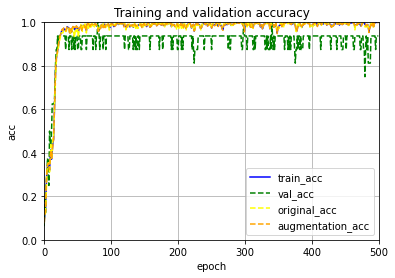

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0417, val_loss: 0.1531, val_acc: 0.2500, val_f: 0.1344
Epoch [21/500], Loss: 0.0177, val_loss: 0.0641, val_acc: 0.8125, val_f: 0.7708
Epoch [31/500], Loss: 0.0063, val_loss: 0.0249, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0032, val_loss: 0.0137, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0030, val_loss: 0.0171, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0020, val_loss: 0.0094, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0024, val_loss: 0.0097, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0015, val_loss: 0.0057, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0011, val_loss: 0.0062, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0009, val_loss: 0.0132, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0007, val_loss: 0.0022, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0009, val_loss: 0.0022, v

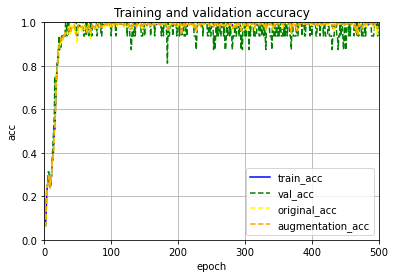

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.1250, val_f: 0.0346
Epoch [11/500], Loss: 0.0425, val_loss: 0.1567, val_acc: 0.1875, val_f: 0.1000
Epoch [21/500], Loss: 0.0185, val_loss: 0.0754, val_acc: 0.7500, val_f: 0.6667
Epoch [31/500], Loss: 0.0070, val_loss: 0.0477, val_acc: 0.7500, val_f: 0.6667
Epoch [41/500], Loss: 0.0041, val_loss: 0.0299, val_acc: 0.8750, val_f: 0.8333
Epoch [51/500], Loss: 0.0023, val_loss: 0.0128, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0025, val_loss: 0.0113, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0014, val_loss: 0.0192, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0030, val_loss: 0.0309, val_acc: 0.8750, val_f: 0.8333
Epoch [91/500], Loss: 0.0014, val_loss: 0.0039, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0009, val_loss: 0.0168, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0012, val_loss: 0.0175, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0007, val_loss: 0.0186, v

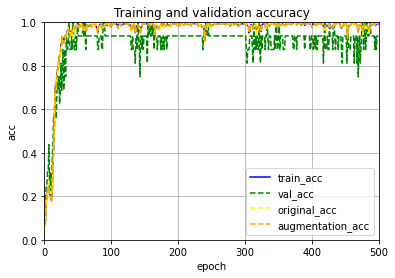

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1732, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0422, val_loss: 0.1582, val_acc: 0.3125, val_f: 0.1949
Epoch [21/500], Loss: 0.0174, val_loss: 0.0956, val_acc: 0.5625, val_f: 0.4375
Epoch [31/500], Loss: 0.0063, val_loss: 0.0679, val_acc: 0.6875, val_f: 0.5938
Epoch [41/500], Loss: 0.0033, val_loss: 0.0687, val_acc: 0.6875, val_f: 0.5938
Epoch [51/500], Loss: 0.0022, val_loss: 0.0631, val_acc: 0.6875, val_f: 0.5938
Epoch [61/500], Loss: 0.0023, val_loss: 0.0634, val_acc: 0.6875, val_f: 0.5833
Epoch [71/500], Loss: 0.0012, val_loss: 0.0683, val_acc: 0.6875, val_f: 0.5938
Epoch [81/500], Loss: 0.0010, val_loss: 0.0676, val_acc: 0.6875, val_f: 0.6146
Epoch [91/500], Loss: 0.0018, val_loss: 0.0691, val_acc: 0.6250, val_f: 0.5000
Epoch [101/500], Loss: 0.0018, val_loss: 0.0608, val_acc: 0.7500, val_f: 0.6979
Epoch [111/500], Loss: 0.0012, val_loss: 0.0609, val_acc: 0.7500, val_f: 0.6875
Epoch [121/500], Loss: 0.0009, val_loss: 0.0543, v

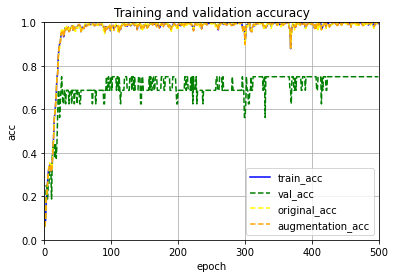

[0.75]




Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0418, val_loss: 0.1522, val_acc: 0.1875, val_f: 0.0792
Epoch [21/500], Loss: 0.0181, val_loss: 0.0746, val_acc: 0.6875, val_f: 0.6354
Epoch [31/500], Loss: 0.0066, val_loss: 0.0395, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0031, val_loss: 0.0309, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0020, val_loss: 0.0260, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0012, val_loss: 0.0264, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0006, val_loss: 0.0247, val_acc: 0.8750, val_f: 0.8333
Epoch [81/500], Loss: 0.0005, val_loss: 0.0253, val_acc: 0.8750, val_f: 0.8333
Epoch [91/500], Loss: 0.0004, val_loss: 0.0267, val_acc: 0.8750, val_f: 0.8333
Epoch [101/500], Loss: 0.0003, val_loss: 0.0273, val_acc: 0.8750, val_f: 0.8333
Epoch [111/500], Loss: 0.0003, val_loss: 0.0281, val_acc: 0.8750, val_f: 0.8333
Epoch [121/500], Loss: 0.0002, val_loss: 0.0284, v

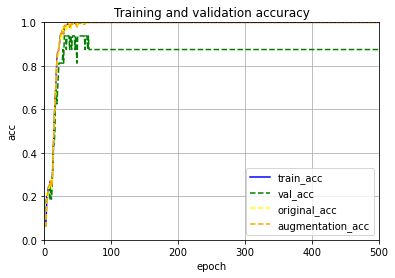

[0.875]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.0625, val_f: 0.0078
Epoch [11/500], Loss: 0.0430, val_loss: 0.1574, val_acc: 0.1875, val_f: 0.0699
Epoch [21/500], Loss: 0.0159, val_loss: 0.0536, val_acc: 1.0000, val_f: 1.0000
Epoch [31/500], Loss: 0.0047, val_loss: 0.0165, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0034, val_loss: 0.0144, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0012, val_loss: 0.0049, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0008, val_loss: 0.0034, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0006, val_loss: 0.0025, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0005, val_loss: 0.0021, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0004, val_loss: 0.0017, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0003, val_loss: 0.0014, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0002, val_loss: 0.0014, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0002, val_loss: 0.0014, v

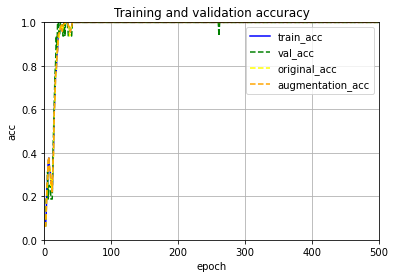

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.0625, val_f: 0.0089
Epoch [11/500], Loss: 0.0422, val_loss: 0.1537, val_acc: 0.2500, val_f: 0.1375
Epoch [21/500], Loss: 0.0190, val_loss: 0.0645, val_acc: 0.8750, val_f: 0.8438
Epoch [31/500], Loss: 0.0057, val_loss: 0.0204, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0026, val_loss: 0.0094, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0014, val_loss: 0.0050, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0009, val_loss: 0.0034, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0007, val_loss: 0.0026, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0005, val_loss: 0.0020, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0004, val_loss: 0.0016, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0003, val_loss: 0.0013, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0003, val_loss: 0.0011, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0003, val_loss: 0.0009, v

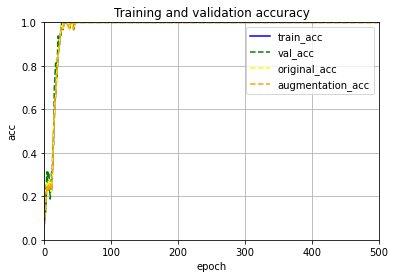

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0425, val_loss: 0.1553, val_acc: 0.3125, val_f: 0.1865
Epoch [21/500], Loss: 0.0129, val_loss: 0.0418, val_acc: 1.0000, val_f: 1.0000
Epoch [31/500], Loss: 0.0033, val_loss: 0.0140, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0020, val_loss: 0.0054, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0008, val_loss: 0.0030, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0005, val_loss: 0.0021, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0004, val_loss: 0.0016, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0003, val_loss: 0.0012, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0003, val_loss: 0.0010, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0002, val_loss: 0.0008, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0002, val_loss: 0.0007, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0002, val_loss: 0.0006, v

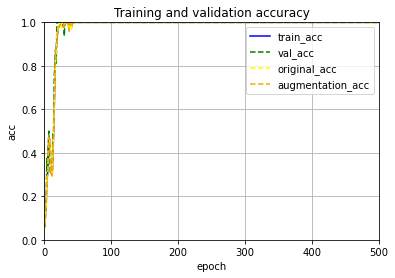

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0425, val_loss: 0.1555, val_acc: 0.5625, val_f: 0.4625
Epoch [21/500], Loss: 0.0127, val_loss: 0.0406, val_acc: 1.0000, val_f: 1.0000
Epoch [31/500], Loss: 0.0037, val_loss: 0.0110, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0026, val_loss: 0.0108, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0013, val_loss: 0.0041, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0009, val_loss: 0.0028, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0006, val_loss: 0.0019, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0004, val_loss: 0.0015, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0003, val_loss: 0.0012, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0003, val_loss: 0.0010, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0002, val_loss: 0.0009, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0002, val_loss: 0.0007, v

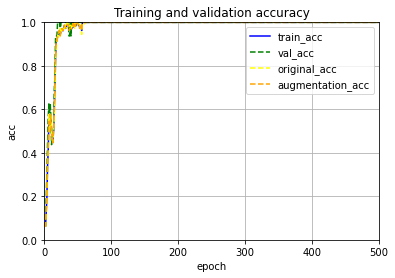

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0428, val_loss: 0.1566, val_acc: 0.3125, val_f: 0.1708
Epoch [21/500], Loss: 0.0146, val_loss: 0.0470, val_acc: 0.9375, val_f: 0.9167
Epoch [31/500], Loss: 0.0039, val_loss: 0.0127, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0015, val_loss: 0.0055, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0009, val_loss: 0.0032, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0006, val_loss: 0.0022, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0004, val_loss: 0.0016, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0003, val_loss: 0.0012, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0003, val_loss: 0.0010, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0002, val_loss: 0.0008, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0002, val_loss: 0.0007, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0001, val_loss: 0.0006, v

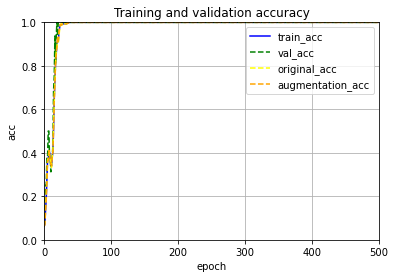

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1732, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0430, val_loss: 0.1586, val_acc: 0.3750, val_f: 0.2470
Epoch [21/500], Loss: 0.0154, val_loss: 0.0550, val_acc: 0.8125, val_f: 0.7500
Epoch [31/500], Loss: 0.0033, val_loss: 0.0139, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0012, val_loss: 0.0058, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0007, val_loss: 0.0034, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0005, val_loss: 0.0023, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0003, val_loss: 0.0019, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0003, val_loss: 0.0016, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0002, val_loss: 0.0011, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0002, val_loss: 0.0010, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0001, val_loss: 0.0008, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0001, val_loss: 0.0008, v

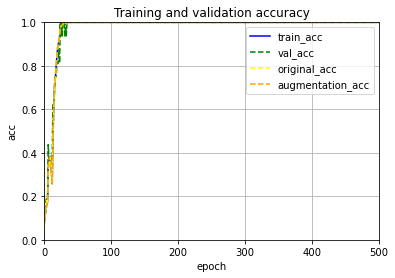

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0419, val_loss: 0.1523, val_acc: 0.3750, val_f: 0.2656
Epoch [21/500], Loss: 0.0129, val_loss: 0.0421, val_acc: 1.0000, val_f: 1.0000
Epoch [31/500], Loss: 0.0038, val_loss: 0.0137, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0019, val_loss: 0.0125, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0010, val_loss: 0.0093, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0007, val_loss: 0.0082, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0005, val_loss: 0.0076, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0004, val_loss: 0.0068, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0003, val_loss: 0.0058, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0003, val_loss: 0.0067, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0002, val_loss: 0.0075, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0002, val_loss: 0.0077, v

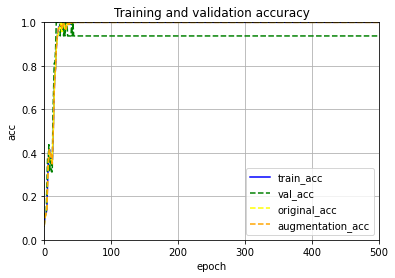

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0424, val_loss: 0.1567, val_acc: 0.4375, val_f: 0.3408
Epoch [21/500], Loss: 0.0110, val_loss: 0.0458, val_acc: 0.8125, val_f: 0.7500
Epoch [31/500], Loss: 0.0035, val_loss: 0.0173, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0013, val_loss: 0.0109, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0013, val_loss: 0.0089, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0005, val_loss: 0.0072, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0004, val_loss: 0.0061, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0003, val_loss: 0.0054, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0003, val_loss: 0.0048, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0002, val_loss: 0.0045, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0002, val_loss: 0.0036, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0002, val_loss: 0.0031, v

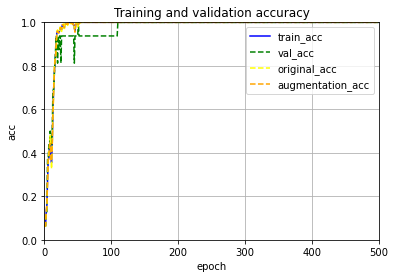

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0406, val_loss: 0.1507, val_acc: 0.2500, val_f: 0.1389
Epoch [21/500], Loss: 0.0146, val_loss: 0.0726, val_acc: 0.7500, val_f: 0.6667
Epoch [31/500], Loss: 0.0039, val_loss: 0.0361, val_acc: 0.8750, val_f: 0.8333
Epoch [41/500], Loss: 0.0016, val_loss: 0.0248, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0009, val_loss: 0.0214, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0006, val_loss: 0.0195, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0005, val_loss: 0.0187, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0004, val_loss: 0.0183, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0003, val_loss: 0.0176, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0002, val_loss: 0.0173, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0002, val_loss: 0.0178, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0002, val_loss: 0.0182, v

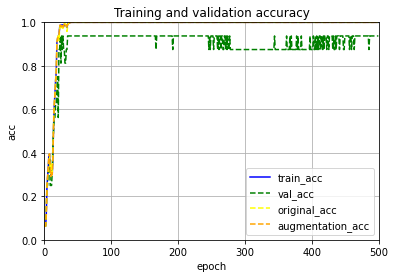

[0.9375]




Epoch [1/500], Loss: 0.0461, val_loss: 0.1728, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0410, val_loss: 0.1507, val_acc: 0.2500, val_f: 0.1637
Epoch [21/500], Loss: 0.0128, val_loss: 0.0458, val_acc: 0.9375, val_f: 0.9167
Epoch [31/500], Loss: 0.0046, val_loss: 0.0272, val_acc: 0.8750, val_f: 0.8333
Epoch [41/500], Loss: 0.0023, val_loss: 0.0265, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0015, val_loss: 0.0157, val_acc: 0.8750, val_f: 0.8333
Epoch [61/500], Loss: 0.0011, val_loss: 0.0137, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0006, val_loss: 0.0303, val_acc: 0.8125, val_f: 0.7500
Epoch [81/500], Loss: 0.0017, val_loss: 0.0093, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0008, val_loss: 0.0130, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0003, val_loss: 0.0135, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0003, val_loss: 0.0133, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0002, val_loss: 0.0139, v

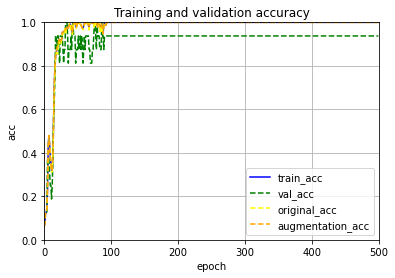

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1728, val_acc: 0.0625, val_f: 0.0208
Epoch [11/500], Loss: 0.0403, val_loss: 0.1469, val_acc: 0.1875, val_f: 0.1054
Epoch [21/500], Loss: 0.0146, val_loss: 0.0560, val_acc: 0.8750, val_f: 0.8333
Epoch [31/500], Loss: 0.0060, val_loss: 0.0340, val_acc: 0.8750, val_f: 0.8333
Epoch [41/500], Loss: 0.0032, val_loss: 0.0210, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0028, val_loss: 0.0220, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0013, val_loss: 0.0195, val_acc: 0.8750, val_f: 0.8333
Epoch [71/500], Loss: 0.0021, val_loss: 0.0233, val_acc: 0.8750, val_f: 0.8333
Epoch [81/500], Loss: 0.0018, val_loss: 0.0137, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0012, val_loss: 0.0229, val_acc: 0.8750, val_f: 0.8333
Epoch [101/500], Loss: 0.0008, val_loss: 0.0171, val_acc: 0.8750, val_f: 0.8333
Epoch [111/500], Loss: 0.0006, val_loss: 0.0224, val_acc: 0.8750, val_f: 0.8333
Epoch [121/500], Loss: 0.0006, val_loss: 0.0069, v

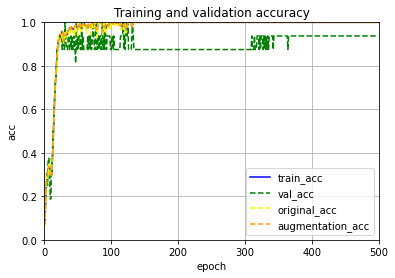

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.1250, val_f: 0.0281
Epoch [11/500], Loss: 0.0416, val_loss: 0.1522, val_acc: 0.2500, val_f: 0.1389
Epoch [21/500], Loss: 0.0172, val_loss: 0.0601, val_acc: 0.7500, val_f: 0.6667
Epoch [31/500], Loss: 0.0074, val_loss: 0.0260, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0041, val_loss: 0.0193, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0024, val_loss: 0.0142, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0014, val_loss: 0.0119, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0009, val_loss: 0.0130, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0007, val_loss: 0.0116, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0005, val_loss: 0.0138, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0004, val_loss: 0.0140, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0003, val_loss: 0.0149, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0003, val_loss: 0.0161, v

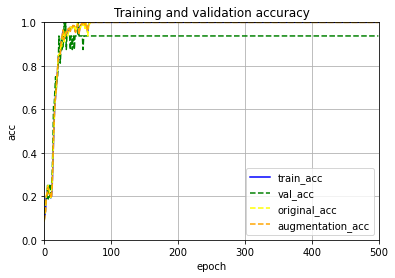

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.1250, val_f: 0.0312
Epoch [11/500], Loss: 0.0415, val_loss: 0.1513, val_acc: 0.3750, val_f: 0.2679
Epoch [21/500], Loss: 0.0146, val_loss: 0.0504, val_acc: 0.8750, val_f: 0.8333
Epoch [31/500], Loss: 0.0052, val_loss: 0.0157, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0026, val_loss: 0.0081, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0016, val_loss: 0.0047, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0009, val_loss: 0.0032, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0015, val_loss: 0.0028, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0007, val_loss: 0.0032, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0006, val_loss: 0.0018, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0003, val_loss: 0.0012, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0003, val_loss: 0.0010, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0002, val_loss: 0.0009, v

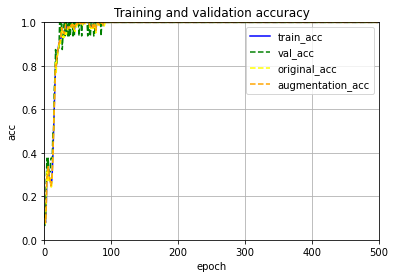

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.0625, val_f: 0.0078
Epoch [11/500], Loss: 0.0427, val_loss: 0.1569, val_acc: 0.2500, val_f: 0.1741
Epoch [21/500], Loss: 0.0167, val_loss: 0.0658, val_acc: 0.8125, val_f: 0.7500
Epoch [31/500], Loss: 0.0061, val_loss: 0.0301, val_acc: 0.8750, val_f: 0.8333
Epoch [41/500], Loss: 0.0030, val_loss: 0.0214, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0036, val_loss: 0.0244, val_acc: 0.8750, val_f: 0.8333
Epoch [61/500], Loss: 0.0028, val_loss: 0.0237, val_acc: 0.8750, val_f: 0.8333
Epoch [71/500], Loss: 0.0010, val_loss: 0.0242, val_acc: 0.8750, val_f: 0.8333
Epoch [81/500], Loss: 0.0007, val_loss: 0.0204, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0013, val_loss: 0.0221, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0006, val_loss: 0.0201, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0004, val_loss: 0.0242, val_acc: 0.8750, val_f: 0.8333
Epoch [121/500], Loss: 0.0005, val_loss: 0.0237, v

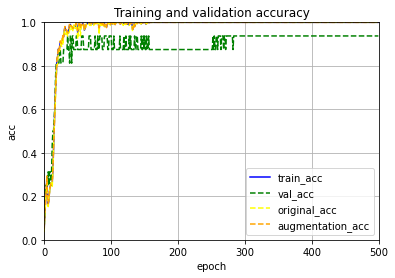

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1729, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0410, val_loss: 0.1502, val_acc: 0.3125, val_f: 0.2054
Epoch [21/500], Loss: 0.0152, val_loss: 0.0609, val_acc: 0.9375, val_f: 0.9167
Epoch [31/500], Loss: 0.0045, val_loss: 0.0348, val_acc: 0.8750, val_f: 0.8333
Epoch [41/500], Loss: 0.0019, val_loss: 0.0296, val_acc: 0.8750, val_f: 0.8333
Epoch [51/500], Loss: 0.0018, val_loss: 0.0127, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0009, val_loss: 0.0264, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0011, val_loss: 0.0384, val_acc: 0.8750, val_f: 0.8333
Epoch [81/500], Loss: 0.0005, val_loss: 0.0309, val_acc: 0.8750, val_f: 0.8333
Epoch [91/500], Loss: 0.0006, val_loss: 0.0261, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0006, val_loss: 0.0264, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0004, val_loss: 0.0252, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0002, val_loss: 0.0265, v

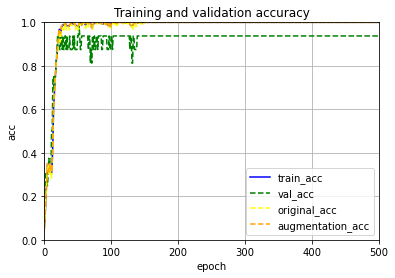

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0422, val_loss: 0.1549, val_acc: 0.2500, val_f: 0.1615
Epoch [21/500], Loss: 0.0154, val_loss: 0.0571, val_acc: 0.8125, val_f: 0.7500
Epoch [31/500], Loss: 0.0060, val_loss: 0.0290, val_acc: 0.8125, val_f: 0.7500
Epoch [41/500], Loss: 0.0033, val_loss: 0.0185, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0023, val_loss: 0.0249, val_acc: 0.8750, val_f: 0.8333
Epoch [61/500], Loss: 0.0014, val_loss: 0.0055, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0014, val_loss: 0.0039, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0016, val_loss: 0.0244, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0014, val_loss: 0.0130, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0005, val_loss: 0.0029, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0009, val_loss: 0.0201, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0004, val_loss: 0.0016, v

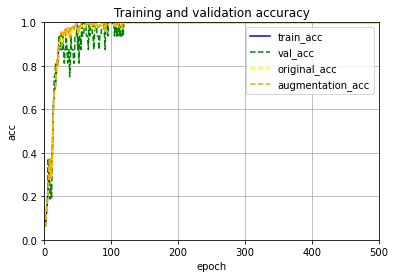

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0432, val_loss: 0.1589, val_acc: 0.2500, val_f: 0.1597
Epoch [21/500], Loss: 0.0184, val_loss: 0.0662, val_acc: 0.8125, val_f: 0.7917
Epoch [31/500], Loss: 0.0062, val_loss: 0.0264, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0033, val_loss: 0.0215, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0020, val_loss: 0.0095, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0016, val_loss: 0.0068, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0014, val_loss: 0.0058, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0010, val_loss: 0.0043, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0012, val_loss: 0.0085, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0009, val_loss: 0.0027, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0029, val_loss: 0.0107, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0007, val_loss: 0.0084, v

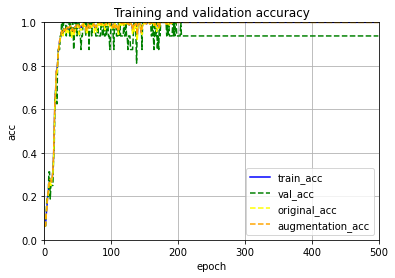

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.1250, val_f: 0.0281
Epoch [11/500], Loss: 0.0409, val_loss: 0.1499, val_acc: 0.4375, val_f: 0.3438
Epoch [21/500], Loss: 0.0147, val_loss: 0.0577, val_acc: 0.8125, val_f: 0.7500
Epoch [31/500], Loss: 0.0055, val_loss: 0.0333, val_acc: 0.8750, val_f: 0.8333
Epoch [41/500], Loss: 0.0030, val_loss: 0.0175, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0019, val_loss: 0.0140, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0012, val_loss: 0.0191, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0012, val_loss: 0.0084, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0011, val_loss: 0.0107, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0006, val_loss: 0.0044, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0012, val_loss: 0.0115, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0010, val_loss: 0.0074, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0004, val_loss: 0.0035, v

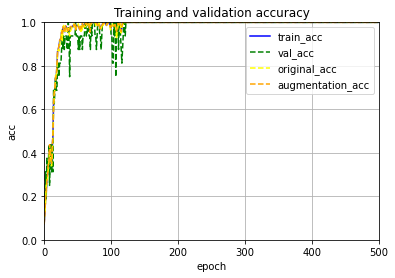

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.1250, val_f: 0.0281
Epoch [11/500], Loss: 0.0407, val_loss: 0.1506, val_acc: 0.1875, val_f: 0.0942
Epoch [21/500], Loss: 0.0154, val_loss: 0.0695, val_acc: 0.6875, val_f: 0.6042
Epoch [31/500], Loss: 0.0051, val_loss: 0.0451, val_acc: 0.8125, val_f: 0.7500
Epoch [41/500], Loss: 0.0028, val_loss: 0.0412, val_acc: 0.8750, val_f: 0.8333
Epoch [51/500], Loss: 0.0020, val_loss: 0.0372, val_acc: 0.8125, val_f: 0.7500
Epoch [61/500], Loss: 0.0013, val_loss: 0.0502, val_acc: 0.7500, val_f: 0.6667
Epoch [71/500], Loss: 0.0010, val_loss: 0.0535, val_acc: 0.7500, val_f: 0.6667
Epoch [81/500], Loss: 0.0007, val_loss: 0.0578, val_acc: 0.7500, val_f: 0.6667
Epoch [91/500], Loss: 0.0007, val_loss: 0.0567, val_acc: 0.7500, val_f: 0.6667
Epoch [101/500], Loss: 0.0015, val_loss: 0.0455, val_acc: 0.8125, val_f: 0.7500
Epoch [111/500], Loss: 0.0014, val_loss: 0.0398, val_acc: 0.8125, val_f: 0.7500
Epoch [121/500], Loss: 0.0004, val_loss: 0.0381, v

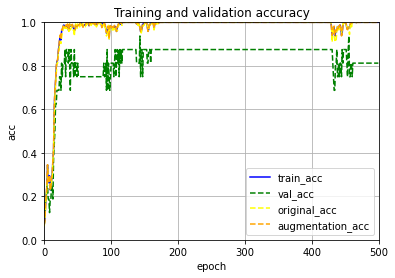

[0.8125]




Epoch [1/500], Loss: 0.0462, val_loss: 0.1729, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0414, val_loss: 0.1519, val_acc: 0.5000, val_f: 0.3646
Epoch [21/500], Loss: 0.0082, val_loss: 0.0352, val_acc: 0.9375, val_f: 0.9167
Epoch [31/500], Loss: 0.0017, val_loss: 0.0191, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0008, val_loss: 0.0190, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0005, val_loss: 0.0199, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0004, val_loss: 0.0201, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0003, val_loss: 0.0209, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0002, val_loss: 0.0221, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0002, val_loss: 0.0222, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0001, val_loss: 0.0222, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0001, val_loss: 0.0228, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0001, val_loss: 0.0234, v

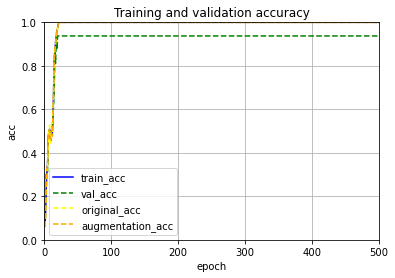

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1729, val_acc: 0.1250, val_f: 0.0281
Epoch [11/500], Loss: 0.0407, val_loss: 0.1480, val_acc: 0.4375, val_f: 0.2917
Epoch [21/500], Loss: 0.0093, val_loss: 0.0329, val_acc: 0.9375, val_f: 0.9167
Epoch [31/500], Loss: 0.0021, val_loss: 0.0084, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0010, val_loss: 0.0044, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0006, val_loss: 0.0028, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0004, val_loss: 0.0022, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0003, val_loss: 0.0017, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0003, val_loss: 0.0013, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0002, val_loss: 0.0013, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0002, val_loss: 0.0012, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0002, val_loss: 0.0010, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0001, val_loss: 0.0008, v

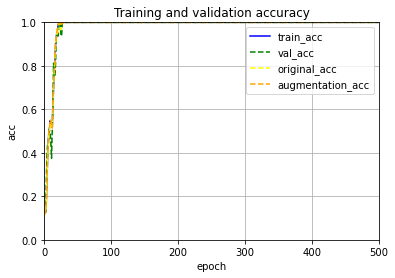

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.0000, val_f: 0.0000
Epoch [11/500], Loss: 0.0414, val_loss: 0.1510, val_acc: 0.6875, val_f: 0.5938
Epoch [21/500], Loss: 0.0067, val_loss: 0.0237, val_acc: 1.0000, val_f: 1.0000
Epoch [31/500], Loss: 0.0019, val_loss: 0.0069, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0009, val_loss: 0.0033, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0005, val_loss: 0.0022, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0004, val_loss: 0.0015, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0003, val_loss: 0.0012, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0002, val_loss: 0.0009, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0002, val_loss: 0.0008, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0002, val_loss: 0.0006, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0001, val_loss: 0.0005, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0001, val_loss: 0.0005, v

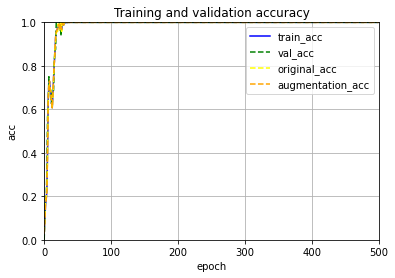

[1.0]



Epoch [1/500], Loss: 0.0461, val_loss: 0.1724, val_acc: 0.2500, val_f: 0.1302
Epoch [11/500], Loss: 0.0373, val_loss: 0.1323, val_acc: 0.5625, val_f: 0.4479
Epoch [21/500], Loss: 0.0059, val_loss: 0.0202, val_acc: 1.0000, val_f: 1.0000
Epoch [31/500], Loss: 0.0014, val_loss: 0.0053, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0007, val_loss: 0.0028, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0005, val_loss: 0.0019, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0003, val_loss: 0.0014, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0002, val_loss: 0.0011, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0002, val_loss: 0.0009, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0002, val_loss: 0.0007, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0001, val_loss: 0.0006, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0001, val_loss: 0.0005, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0001, val_loss: 0.0005, v

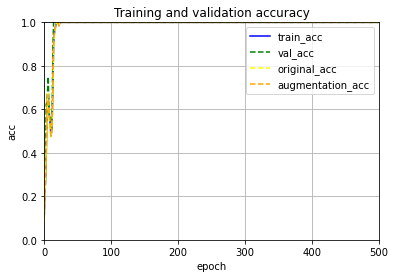

[1.0]



Epoch [1/500], Loss: 0.0461, val_loss: 0.1726, val_acc: 0.1250, val_f: 0.0281
Epoch [11/500], Loss: 0.0392, val_loss: 0.1400, val_acc: 0.5625, val_f: 0.4271
Epoch [21/500], Loss: 0.0058, val_loss: 0.0204, val_acc: 1.0000, val_f: 1.0000
Epoch [31/500], Loss: 0.0016, val_loss: 0.0068, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0008, val_loss: 0.0038, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0005, val_loss: 0.0027, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0004, val_loss: 0.0020, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0003, val_loss: 0.0016, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0002, val_loss: 0.0013, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0002, val_loss: 0.0011, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0002, val_loss: 0.0009, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0001, val_loss: 0.0008, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0001, val_loss: 0.0007, v

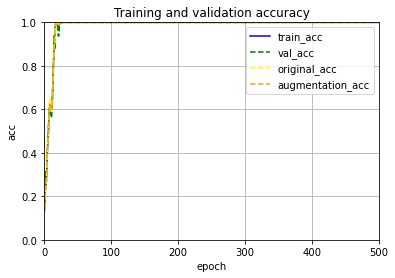

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0411, val_loss: 0.1497, val_acc: 0.4375, val_f: 0.3199
Epoch [21/500], Loss: 0.0099, val_loss: 0.0403, val_acc: 0.8125, val_f: 0.7500
Epoch [31/500], Loss: 0.0022, val_loss: 0.0173, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0010, val_loss: 0.0126, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0006, val_loss: 0.0117, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0004, val_loss: 0.0117, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0003, val_loss: 0.0117, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0003, val_loss: 0.0115, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0002, val_loss: 0.0118, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0002, val_loss: 0.0116, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0001, val_loss: 0.0120, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0001, val_loss: 0.0116, v

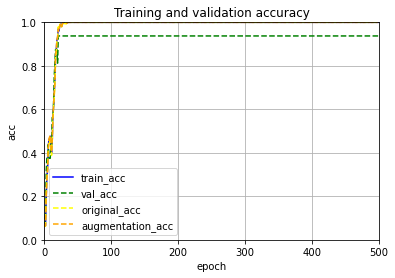

[0.9375]



Epoch [1/500], Loss: 0.0461, val_loss: 0.1726, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0407, val_loss: 0.1473, val_acc: 0.3750, val_f: 0.2500
Epoch [21/500], Loss: 0.0098, val_loss: 0.0348, val_acc: 0.9375, val_f: 0.9167
Epoch [31/500], Loss: 0.0029, val_loss: 0.0100, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0014, val_loss: 0.0052, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0008, val_loss: 0.0028, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0005, val_loss: 0.0020, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0004, val_loss: 0.0015, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0003, val_loss: 0.0012, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0003, val_loss: 0.0010, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0002, val_loss: 0.0008, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0002, val_loss: 0.0007, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0002, val_loss: 0.0006, v

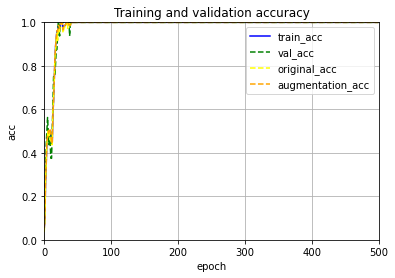

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1729, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0410, val_loss: 0.1491, val_acc: 0.5000, val_f: 0.3688
Epoch [21/500], Loss: 0.0082, val_loss: 0.0305, val_acc: 0.9375, val_f: 0.9167
Epoch [31/500], Loss: 0.0022, val_loss: 0.0085, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0010, val_loss: 0.0048, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0006, val_loss: 0.0032, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0004, val_loss: 0.0025, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0003, val_loss: 0.0021, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0003, val_loss: 0.0020, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0002, val_loss: 0.0017, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0002, val_loss: 0.0016, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0002, val_loss: 0.0016, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0001, val_loss: 0.0016, v

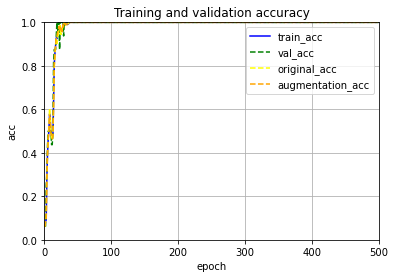

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.1250, val_f: 0.0703
Epoch [11/500], Loss: 0.0407, val_loss: 0.1472, val_acc: 0.4375, val_f: 0.3375
Epoch [21/500], Loss: 0.0086, val_loss: 0.0345, val_acc: 0.9375, val_f: 0.9167
Epoch [31/500], Loss: 0.0021, val_loss: 0.0107, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0009, val_loss: 0.0065, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0006, val_loss: 0.0050, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0004, val_loss: 0.0038, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0003, val_loss: 0.0030, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0002, val_loss: 0.0025, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0002, val_loss: 0.0023, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0002, val_loss: 0.0020, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0001, val_loss: 0.0020, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0001, val_loss: 0.0018, v

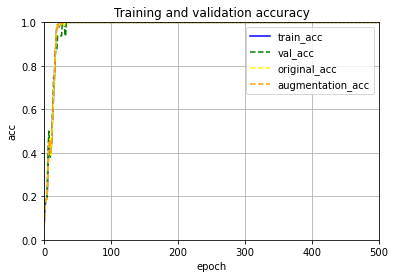

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.1250, val_f: 0.0281
Epoch [11/500], Loss: 0.0409, val_loss: 0.1514, val_acc: 0.3750, val_f: 0.2500
Epoch [21/500], Loss: 0.0064, val_loss: 0.0275, val_acc: 1.0000, val_f: 1.0000
Epoch [31/500], Loss: 0.0014, val_loss: 0.0076, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0007, val_loss: 0.0040, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0004, val_loss: 0.0025, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0003, val_loss: 0.0019, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0002, val_loss: 0.0015, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0002, val_loss: 0.0012, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0002, val_loss: 0.0010, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0001, val_loss: 0.0009, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0001, val_loss: 0.0008, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0001, val_loss: 0.0007, v

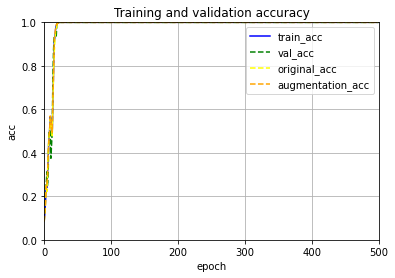

[1.0]




Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0440, val_loss: 0.1628, val_acc: 0.3125, val_f: 0.2158
Epoch [21/500], Loss: 0.0156, val_loss: 0.0659, val_acc: 0.7500, val_f: 0.6771
Epoch [31/500], Loss: 0.0060, val_loss: 0.0484, val_acc: 0.8125, val_f: 0.7708
Epoch [41/500], Loss: 0.0029, val_loss: 0.0424, val_acc: 0.8125, val_f: 0.7708
Epoch [51/500], Loss: 0.0027, val_loss: 0.0400, val_acc: 0.8125, val_f: 0.7708
Epoch [61/500], Loss: 0.0020, val_loss: 0.0434, val_acc: 0.8125, val_f: 0.7708
Epoch [71/500], Loss: 0.0014, val_loss: 0.0422, val_acc: 0.8125, val_f: 0.7708
Epoch [81/500], Loss: 0.0014, val_loss: 0.0425, val_acc: 0.8125, val_f: 0.7708
Epoch [91/500], Loss: 0.0010, val_loss: 0.0417, val_acc: 0.8125, val_f: 0.7708
Epoch [101/500], Loss: 0.0022, val_loss: 0.0445, val_acc: 0.7500, val_f: 0.6875
Epoch [111/500], Loss: 0.0007, val_loss: 0.0469, val_acc: 0.8125, val_f: 0.7708
Epoch [121/500], Loss: 0.0009, val_loss: 0.0481, v

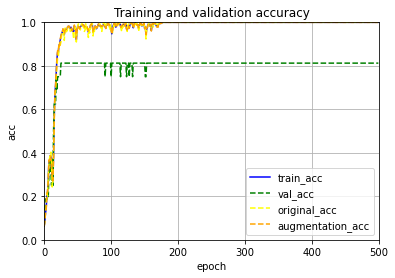

[0.8125]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.1250, val_f: 0.0281
Epoch [11/500], Loss: 0.0415, val_loss: 0.1512, val_acc: 0.2500, val_f: 0.1567
Epoch [21/500], Loss: 0.0141, val_loss: 0.0559, val_acc: 0.8750, val_f: 0.8333
Epoch [31/500], Loss: 0.0055, val_loss: 0.0226, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0032, val_loss: 0.0112, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0025, val_loss: 0.0091, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0018, val_loss: 0.0050, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0018, val_loss: 0.0057, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0017, val_loss: 0.0041, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0013, val_loss: 0.0036, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0010, val_loss: 0.0024, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0012, val_loss: 0.0029, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0010, val_loss: 0.0038, v

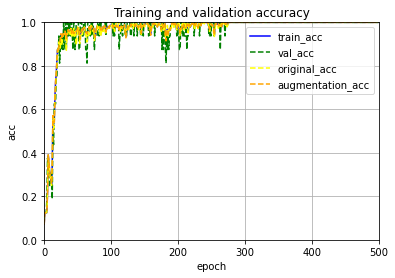

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0432, val_loss: 0.1583, val_acc: 0.2500, val_f: 0.1431
Epoch [21/500], Loss: 0.0158, val_loss: 0.0577, val_acc: 0.8125, val_f: 0.7500
Epoch [31/500], Loss: 0.0061, val_loss: 0.0337, val_acc: 0.8750, val_f: 0.8333
Epoch [41/500], Loss: 0.0036, val_loss: 0.0202, val_acc: 0.8750, val_f: 0.8333
Epoch [51/500], Loss: 0.0027, val_loss: 0.0229, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0022, val_loss: 0.0245, val_acc: 0.8750, val_f: 0.8333
Epoch [71/500], Loss: 0.0015, val_loss: 0.0054, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0019, val_loss: 0.0099, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0017, val_loss: 0.0114, val_acc: 0.8750, val_f: 0.8333
Epoch [101/500], Loss: 0.0009, val_loss: 0.0060, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0006, val_loss: 0.0030, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0006, val_loss: 0.0022, v

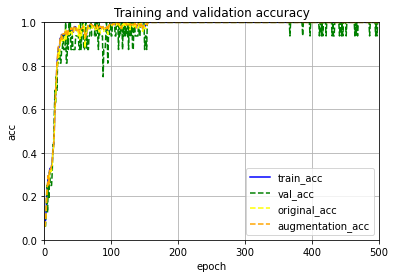

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1732, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0440, val_loss: 0.1627, val_acc: 0.3125, val_f: 0.2054
Epoch [21/500], Loss: 0.0207, val_loss: 0.0721, val_acc: 0.7500, val_f: 0.6667
Epoch [31/500], Loss: 0.0081, val_loss: 0.0306, val_acc: 0.8750, val_f: 0.8333
Epoch [41/500], Loss: 0.0046, val_loss: 0.0177, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0040, val_loss: 0.0141, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0020, val_loss: 0.0079, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0044, val_loss: 0.0133, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0037, val_loss: 0.0103, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0017, val_loss: 0.0083, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0009, val_loss: 0.0055, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0022, val_loss: 0.0135, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0013, val_loss: 0.0119, v

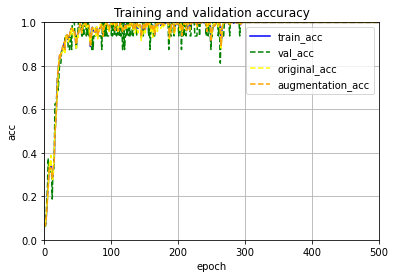

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0425, val_loss: 0.1553, val_acc: 0.4375, val_f: 0.3021
Epoch [21/500], Loss: 0.0132, val_loss: 0.0466, val_acc: 0.8750, val_f: 0.8333
Epoch [31/500], Loss: 0.0049, val_loss: 0.0198, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0031, val_loss: 0.0321, val_acc: 0.8125, val_f: 0.7500
Epoch [51/500], Loss: 0.0022, val_loss: 0.0090, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0019, val_loss: 0.0107, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0011, val_loss: 0.0102, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0012, val_loss: 0.0052, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0009, val_loss: 0.0030, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0011, val_loss: 0.0074, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0019, val_loss: 0.0071, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0006, val_loss: 0.0052, v

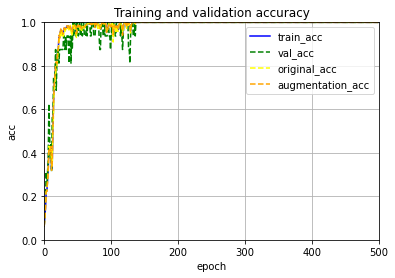

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1732, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0443, val_loss: 0.1634, val_acc: 0.3750, val_f: 0.2470
Epoch [21/500], Loss: 0.0200, val_loss: 0.0718, val_acc: 0.7500, val_f: 0.6667
Epoch [31/500], Loss: 0.0088, val_loss: 0.0330, val_acc: 0.8750, val_f: 0.8333
Epoch [41/500], Loss: 0.0054, val_loss: 0.0221, val_acc: 0.8125, val_f: 0.7500
Epoch [51/500], Loss: 0.0031, val_loss: 0.0156, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0032, val_loss: 0.0154, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0025, val_loss: 0.0133, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0021, val_loss: 0.0073, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0017, val_loss: 0.0078, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0011, val_loss: 0.0116, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0016, val_loss: 0.0100, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0009, val_loss: 0.0044, v

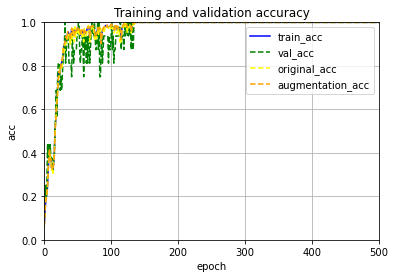

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1732, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0442, val_loss: 0.1636, val_acc: 0.3125, val_f: 0.1783
Epoch [21/500], Loss: 0.0194, val_loss: 0.0667, val_acc: 0.8125, val_f: 0.7604
Epoch [31/500], Loss: 0.0076, val_loss: 0.0268, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0050, val_loss: 0.0167, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0033, val_loss: 0.0105, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0025, val_loss: 0.0086, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0037, val_loss: 0.0137, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0016, val_loss: 0.0040, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0016, val_loss: 0.0047, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0014, val_loss: 0.0031, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0012, val_loss: 0.0038, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0014, val_loss: 0.0039, v

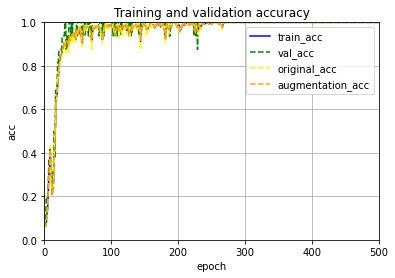

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1732, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0438, val_loss: 0.1622, val_acc: 0.4375, val_f: 0.3345
Epoch [21/500], Loss: 0.0199, val_loss: 0.0768, val_acc: 0.6875, val_f: 0.5833
Epoch [31/500], Loss: 0.0088, val_loss: 0.0462, val_acc: 0.8125, val_f: 0.7500
Epoch [41/500], Loss: 0.0049, val_loss: 0.0300, val_acc: 0.8750, val_f: 0.8333
Epoch [51/500], Loss: 0.0030, val_loss: 0.0322, val_acc: 0.8750, val_f: 0.8333
Epoch [61/500], Loss: 0.0028, val_loss: 0.0252, val_acc: 0.8750, val_f: 0.8333
Epoch [71/500], Loss: 0.0031, val_loss: 0.0412, val_acc: 0.8125, val_f: 0.7500
Epoch [81/500], Loss: 0.0020, val_loss: 0.0321, val_acc: 0.8750, val_f: 0.8333
Epoch [91/500], Loss: 0.0012, val_loss: 0.0341, val_acc: 0.8750, val_f: 0.8333
Epoch [101/500], Loss: 0.0014, val_loss: 0.0228, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0017, val_loss: 0.0258, val_acc: 0.8750, val_f: 0.8333
Epoch [121/500], Loss: 0.0008, val_loss: 0.0247, v

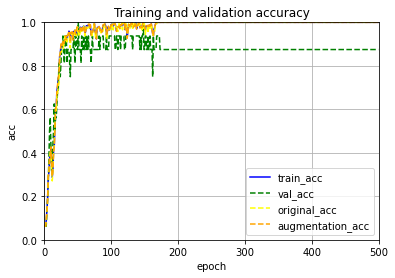

[0.875]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0426, val_loss: 0.1572, val_acc: 0.3125, val_f: 0.1958
Epoch [21/500], Loss: 0.0132, val_loss: 0.0462, val_acc: 0.8750, val_f: 0.8333
Epoch [31/500], Loss: 0.0063, val_loss: 0.0211, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0038, val_loss: 0.0130, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0024, val_loss: 0.0113, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0020, val_loss: 0.0073, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0017, val_loss: 0.0055, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0021, val_loss: 0.0057, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0027, val_loss: 0.0204, val_acc: 0.8750, val_f: 0.8333
Epoch [101/500], Loss: 0.0008, val_loss: 0.0048, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0011, val_loss: 0.0031, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0005, val_loss: 0.0023, v

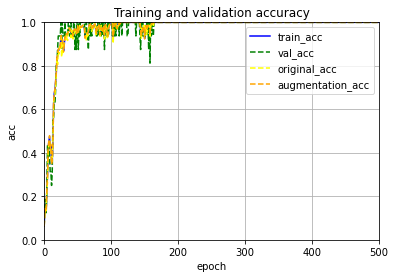

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.0625, val_f: 0.0096
Epoch [11/500], Loss: 0.0430, val_loss: 0.1607, val_acc: 0.3125, val_f: 0.2118
Epoch [21/500], Loss: 0.0183, val_loss: 0.0895, val_acc: 0.5625, val_f: 0.4625
Epoch [31/500], Loss: 0.0071, val_loss: 0.0520, val_acc: 0.5625, val_f: 0.4792
Epoch [41/500], Loss: 0.0049, val_loss: 0.0512, val_acc: 0.6875, val_f: 0.6042
Epoch [51/500], Loss: 0.0036, val_loss: 0.0523, val_acc: 0.6250, val_f: 0.5208
Epoch [61/500], Loss: 0.0024, val_loss: 0.0379, val_acc: 0.7500, val_f: 0.7083
Epoch [71/500], Loss: 0.0023, val_loss: 0.0628, val_acc: 0.6250, val_f: 0.5417
Epoch [81/500], Loss: 0.0021, val_loss: 0.0363, val_acc: 0.8750, val_f: 0.8333
Epoch [91/500], Loss: 0.0020, val_loss: 0.0392, val_acc: 0.7500, val_f: 0.6875
Epoch [101/500], Loss: 0.0014, val_loss: 0.0453, val_acc: 0.7500, val_f: 0.6875
Epoch [111/500], Loss: 0.0020, val_loss: 0.0295, val_acc: 0.8750, val_f: 0.8542
Epoch [121/500], Loss: 0.0013, val_loss: 0.0382, v

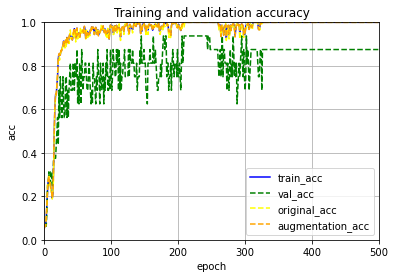

[0.875]




Epoch [1/500], Loss: 0.0462, val_loss: 0.1729, val_acc: 0.1250, val_f: 0.0312
Epoch [11/500], Loss: 0.0411, val_loss: 0.1506, val_acc: 0.5000, val_f: 0.4137
Epoch [21/500], Loss: 0.0106, val_loss: 0.0520, val_acc: 0.9375, val_f: 0.9167
Epoch [31/500], Loss: 0.0024, val_loss: 0.0314, val_acc: 0.8750, val_f: 0.8333
Epoch [41/500], Loss: 0.0011, val_loss: 0.0289, val_acc: 0.8750, val_f: 0.8333
Epoch [51/500], Loss: 0.0006, val_loss: 0.0301, val_acc: 0.8750, val_f: 0.8333
Epoch [61/500], Loss: 0.0005, val_loss: 0.0305, val_acc: 0.8750, val_f: 0.8333
Epoch [71/500], Loss: 0.0003, val_loss: 0.0315, val_acc: 0.8750, val_f: 0.8333
Epoch [81/500], Loss: 0.0003, val_loss: 0.0324, val_acc: 0.8750, val_f: 0.8333
Epoch [91/500], Loss: 0.0002, val_loss: 0.0322, val_acc: 0.8750, val_f: 0.8333
Epoch [101/500], Loss: 0.0002, val_loss: 0.0327, val_acc: 0.8750, val_f: 0.8333
Epoch [111/500], Loss: 0.0001, val_loss: 0.0330, val_acc: 0.8750, val_f: 0.8333
Epoch [121/500], Loss: 0.0001, val_loss: 0.0330, v

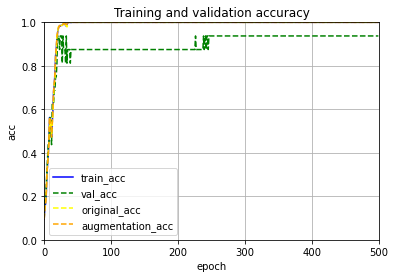

[0.9375]



Epoch [1/500], Loss: 0.0461, val_loss: 0.1727, val_acc: 0.0625, val_f: 0.0083
Epoch [11/500], Loss: 0.0390, val_loss: 0.1436, val_acc: 0.1875, val_f: 0.1014
Epoch [21/500], Loss: 0.0153, val_loss: 0.0585, val_acc: 0.8125, val_f: 0.7500
Epoch [31/500], Loss: 0.0037, val_loss: 0.0206, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0016, val_loss: 0.0093, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0009, val_loss: 0.0068, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0006, val_loss: 0.0053, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0004, val_loss: 0.0047, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0003, val_loss: 0.0045, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0003, val_loss: 0.0045, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0002, val_loss: 0.0040, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0002, val_loss: 0.0044, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0002, val_loss: 0.0052, v

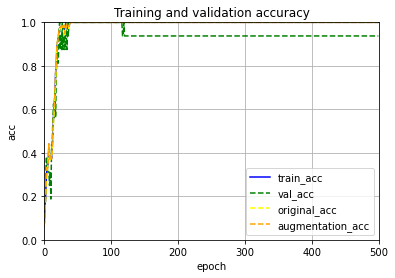

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1727, val_acc: 0.1250, val_f: 0.0750
Epoch [11/500], Loss: 0.0397, val_loss: 0.1442, val_acc: 0.5000, val_f: 0.3896
Epoch [21/500], Loss: 0.0113, val_loss: 0.0469, val_acc: 0.8125, val_f: 0.7500
Epoch [31/500], Loss: 0.0029, val_loss: 0.0175, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0011, val_loss: 0.0114, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0008, val_loss: 0.0105, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0005, val_loss: 0.0090, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0004, val_loss: 0.0082, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0003, val_loss: 0.0076, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0003, val_loss: 0.0075, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0002, val_loss: 0.0078, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0002, val_loss: 0.0076, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0002, val_loss: 0.0074, v

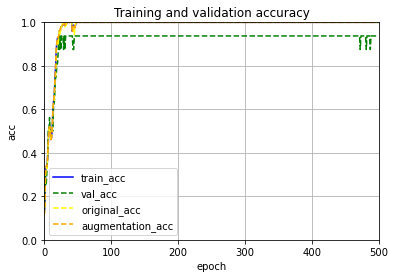

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.1250, val_f: 0.0500
Epoch [11/500], Loss: 0.0412, val_loss: 0.1502, val_acc: 0.3125, val_f: 0.1750
Epoch [21/500], Loss: 0.0134, val_loss: 0.0491, val_acc: 0.8125, val_f: 0.7500
Epoch [31/500], Loss: 0.0035, val_loss: 0.0166, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0015, val_loss: 0.0128, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0012, val_loss: 0.0128, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0006, val_loss: 0.0108, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0005, val_loss: 0.0104, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0004, val_loss: 0.0100, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0003, val_loss: 0.0095, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0002, val_loss: 0.0093, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0002, val_loss: 0.0092, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0002, val_loss: 0.0086, v

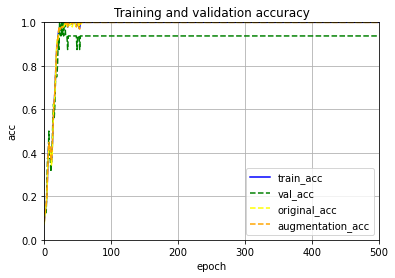

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1728, val_acc: 0.0625, val_f: 0.0089
Epoch [11/500], Loss: 0.0414, val_loss: 0.1504, val_acc: 0.5000, val_f: 0.4208
Epoch [21/500], Loss: 0.0143, val_loss: 0.0482, val_acc: 1.0000, val_f: 1.0000
Epoch [31/500], Loss: 0.0039, val_loss: 0.0178, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0017, val_loss: 0.0082, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0009, val_loss: 0.0058, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0006, val_loss: 0.0047, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0004, val_loss: 0.0038, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0003, val_loss: 0.0035, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0003, val_loss: 0.0032, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0002, val_loss: 0.0027, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0002, val_loss: 0.0025, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0002, val_loss: 0.0024, v

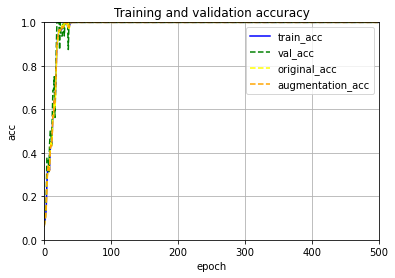

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1726, val_acc: 0.1250, val_f: 0.0708
Epoch [11/500], Loss: 0.0405, val_loss: 0.1471, val_acc: 0.3125, val_f: 0.2396
Epoch [21/500], Loss: 0.0154, val_loss: 0.0529, val_acc: 0.9375, val_f: 0.9167
Epoch [31/500], Loss: 0.0038, val_loss: 0.0186, val_acc: 0.8750, val_f: 0.8333
Epoch [41/500], Loss: 0.0017, val_loss: 0.0067, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0009, val_loss: 0.0054, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0006, val_loss: 0.0031, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0004, val_loss: 0.0020, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0004, val_loss: 0.0022, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0003, val_loss: 0.0018, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0002, val_loss: 0.0023, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0002, val_loss: 0.0020, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0002, val_loss: 0.0029, v

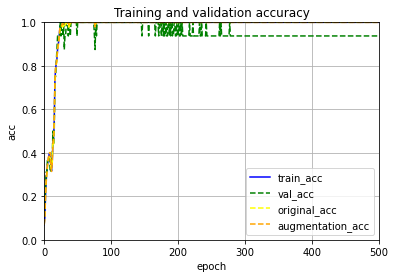

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0420, val_loss: 0.1537, val_acc: 0.6250, val_f: 0.5521
Epoch [21/500], Loss: 0.0150, val_loss: 0.0504, val_acc: 0.9375, val_f: 0.9167
Epoch [31/500], Loss: 0.0035, val_loss: 0.0119, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0015, val_loss: 0.0092, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0026, val_loss: 0.0074, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0012, val_loss: 0.0041, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0005, val_loss: 0.0093, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0004, val_loss: 0.0092, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0003, val_loss: 0.0108, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0002, val_loss: 0.0119, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0002, val_loss: 0.0115, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0002, val_loss: 0.0130, v

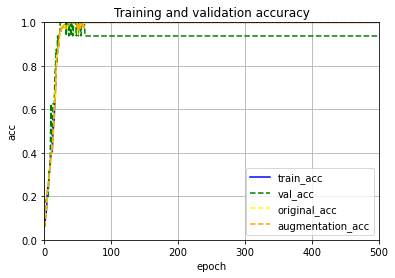

[0.9375]



Epoch [1/500], Loss: 0.0461, val_loss: 0.1725, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0393, val_loss: 0.1436, val_acc: 0.2500, val_f: 0.1719
Epoch [21/500], Loss: 0.0156, val_loss: 0.0586, val_acc: 0.8750, val_f: 0.8333
Epoch [31/500], Loss: 0.0040, val_loss: 0.0241, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0018, val_loss: 0.0122, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0009, val_loss: 0.0114, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0006, val_loss: 0.0103, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0005, val_loss: 0.0094, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0004, val_loss: 0.0097, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0003, val_loss: 0.0085, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0002, val_loss: 0.0083, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0002, val_loss: 0.0082, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0002, val_loss: 0.0074, v

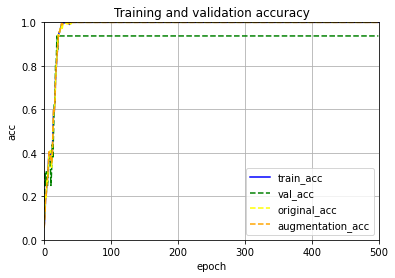

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1729, val_acc: 0.1250, val_f: 0.0506
Epoch [11/500], Loss: 0.0407, val_loss: 0.1521, val_acc: 0.3750, val_f: 0.2656
Epoch [21/500], Loss: 0.0117, val_loss: 0.0636, val_acc: 0.7500, val_f: 0.6667
Epoch [31/500], Loss: 0.0026, val_loss: 0.0384, val_acc: 0.8125, val_f: 0.7500
Epoch [41/500], Loss: 0.0010, val_loss: 0.0380, val_acc: 0.8750, val_f: 0.8333
Epoch [51/500], Loss: 0.0006, val_loss: 0.0377, val_acc: 0.8750, val_f: 0.8333
Epoch [61/500], Loss: 0.0004, val_loss: 0.0392, val_acc: 0.8750, val_f: 0.8333
Epoch [71/500], Loss: 0.0003, val_loss: 0.0385, val_acc: 0.8750, val_f: 0.8333
Epoch [81/500], Loss: 0.0003, val_loss: 0.0373, val_acc: 0.8750, val_f: 0.8333
Epoch [91/500], Loss: 0.0002, val_loss: 0.0353, val_acc: 0.8750, val_f: 0.8333
Epoch [101/500], Loss: 0.0002, val_loss: 0.0353, val_acc: 0.8750, val_f: 0.8333
Epoch [111/500], Loss: 0.0001, val_loss: 0.0359, val_acc: 0.8750, val_f: 0.8333
Epoch [121/500], Loss: 0.0001, val_loss: 0.0352, v

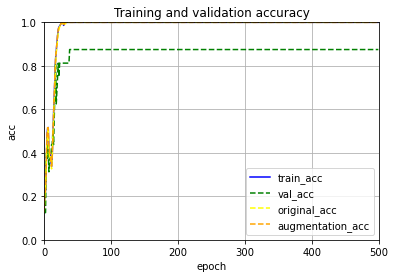

[0.875]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.0625, val_f: 0.0083
Epoch [11/500], Loss: 0.0412, val_loss: 0.1535, val_acc: 0.3125, val_f: 0.2396
Epoch [21/500], Loss: 0.0132, val_loss: 0.0720, val_acc: 0.6250, val_f: 0.5312
Epoch [31/500], Loss: 0.0033, val_loss: 0.0577, val_acc: 0.7500, val_f: 0.7083
Epoch [41/500], Loss: 0.0014, val_loss: 0.0596, val_acc: 0.6875, val_f: 0.6250
Epoch [51/500], Loss: 0.0008, val_loss: 0.0616, val_acc: 0.7500, val_f: 0.7083
Epoch [61/500], Loss: 0.0005, val_loss: 0.0625, val_acc: 0.7500, val_f: 0.7083
Epoch [71/500], Loss: 0.0004, val_loss: 0.0637, val_acc: 0.7500, val_f: 0.7083
Epoch [81/500], Loss: 0.0003, val_loss: 0.0641, val_acc: 0.7500, val_f: 0.7083
Epoch [91/500], Loss: 0.0002, val_loss: 0.0662, val_acc: 0.7500, val_f: 0.7083
Epoch [101/500], Loss: 0.0002, val_loss: 0.0663, val_acc: 0.7500, val_f: 0.7083
Epoch [111/500], Loss: 0.0002, val_loss: 0.0672, val_acc: 0.7500, val_f: 0.7083
Epoch [121/500], Loss: 0.0001, val_loss: 0.0677, v

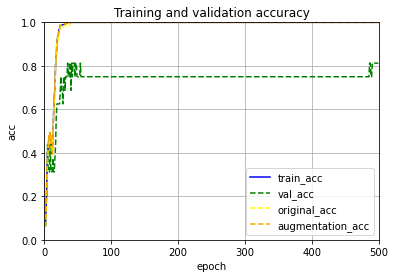

[0.8125]




Epoch [1/500], Loss: 0.0462, val_loss: 0.1729, val_acc: 0.0625, val_f: 0.0139
Epoch [11/500], Loss: 0.0419, val_loss: 0.1535, val_acc: 0.1250, val_f: 0.0317
Epoch [21/500], Loss: 0.0172, val_loss: 0.0726, val_acc: 0.6250, val_f: 0.5312
Epoch [31/500], Loss: 0.0063, val_loss: 0.0364, val_acc: 0.8750, val_f: 0.8333
Epoch [41/500], Loss: 0.0035, val_loss: 0.0273, val_acc: 0.8125, val_f: 0.7500
Epoch [51/500], Loss: 0.0021, val_loss: 0.0217, val_acc: 0.8750, val_f: 0.8333
Epoch [61/500], Loss: 0.0019, val_loss: 0.0222, val_acc: 0.8750, val_f: 0.8333
Epoch [71/500], Loss: 0.0012, val_loss: 0.0132, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0007, val_loss: 0.0192, val_acc: 0.8125, val_f: 0.7604
Epoch [91/500], Loss: 0.0006, val_loss: 0.0209, val_acc: 0.8750, val_f: 0.8333
Epoch [101/500], Loss: 0.0005, val_loss: 0.0124, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0004, val_loss: 0.0189, val_acc: 0.8750, val_f: 0.8333
Epoch [121/500], Loss: 0.0003, val_loss: 0.0187, v

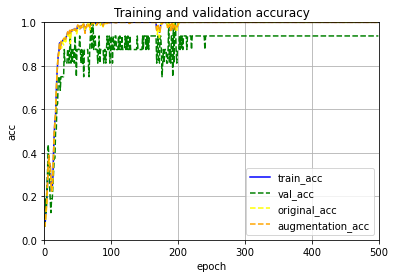

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0417, val_loss: 0.1527, val_acc: 0.3125, val_f: 0.1845
Epoch [21/500], Loss: 0.0146, val_loss: 0.0516, val_acc: 0.9375, val_f: 0.9167
Epoch [31/500], Loss: 0.0056, val_loss: 0.0202, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0036, val_loss: 0.0166, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0022, val_loss: 0.0162, val_acc: 0.8750, val_f: 0.8333
Epoch [61/500], Loss: 0.0019, val_loss: 0.0196, val_acc: 0.8750, val_f: 0.8333
Epoch [71/500], Loss: 0.0015, val_loss: 0.0108, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0016, val_loss: 0.0102, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0012, val_loss: 0.0222, val_acc: 0.8125, val_f: 0.7500
Epoch [101/500], Loss: 0.0004, val_loss: 0.0113, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0004, val_loss: 0.0132, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0003, val_loss: 0.0135, v

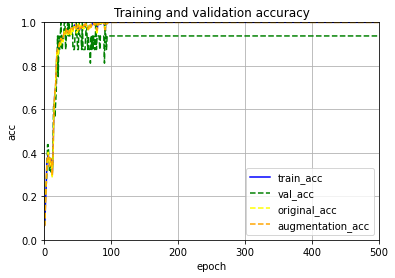

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0424, val_loss: 0.1556, val_acc: 0.4375, val_f: 0.3167
Epoch [21/500], Loss: 0.0129, val_loss: 0.0490, val_acc: 0.8125, val_f: 0.7500
Epoch [31/500], Loss: 0.0047, val_loss: 0.0287, val_acc: 0.8750, val_f: 0.8333
Epoch [41/500], Loss: 0.0025, val_loss: 0.0285, val_acc: 0.8750, val_f: 0.8333
Epoch [51/500], Loss: 0.0014, val_loss: 0.0271, val_acc: 0.8750, val_f: 0.8333
Epoch [61/500], Loss: 0.0013, val_loss: 0.0210, val_acc: 0.8750, val_f: 0.8333
Epoch [71/500], Loss: 0.0009, val_loss: 0.0304, val_acc: 0.8750, val_f: 0.8333
Epoch [81/500], Loss: 0.0011, val_loss: 0.0310, val_acc: 0.8750, val_f: 0.8333
Epoch [91/500], Loss: 0.0006, val_loss: 0.0296, val_acc: 0.8750, val_f: 0.8333
Epoch [101/500], Loss: 0.0006, val_loss: 0.0234, val_acc: 0.8750, val_f: 0.8333
Epoch [111/500], Loss: 0.0011, val_loss: 0.0362, val_acc: 0.8750, val_f: 0.8333
Epoch [121/500], Loss: 0.0008, val_loss: 0.0311, v

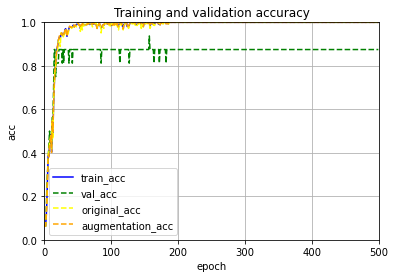

[0.875]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1729, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0414, val_loss: 0.1502, val_acc: 0.3125, val_f: 0.2056
Epoch [21/500], Loss: 0.0107, val_loss: 0.0360, val_acc: 0.9375, val_f: 0.9167
Epoch [31/500], Loss: 0.0037, val_loss: 0.0170, val_acc: 0.8750, val_f: 0.8542
Epoch [41/500], Loss: 0.0018, val_loss: 0.0116, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0013, val_loss: 0.0061, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0007, val_loss: 0.0077, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0005, val_loss: 0.0075, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0004, val_loss: 0.0063, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0003, val_loss: 0.0051, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0003, val_loss: 0.0056, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0002, val_loss: 0.0050, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0002, val_loss: 0.0041, v

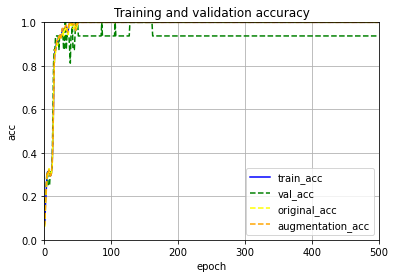

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1729, val_acc: 0.0625, val_f: 0.0089
Epoch [11/500], Loss: 0.0412, val_loss: 0.1499, val_acc: 0.1875, val_f: 0.0806
Epoch [21/500], Loss: 0.0154, val_loss: 0.0522, val_acc: 0.9375, val_f: 0.9167
Epoch [31/500], Loss: 0.0054, val_loss: 0.0205, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0032, val_loss: 0.0090, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0018, val_loss: 0.0050, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0013, val_loss: 0.0121, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0011, val_loss: 0.0031, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0012, val_loss: 0.0031, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0009, val_loss: 0.0069, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0004, val_loss: 0.0016, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0003, val_loss: 0.0014, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0003, val_loss: 0.0012, v

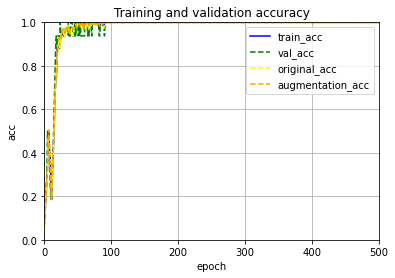

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0423, val_loss: 0.1544, val_acc: 0.3750, val_f: 0.2574
Epoch [21/500], Loss: 0.0138, val_loss: 0.0502, val_acc: 0.9375, val_f: 0.9167
Epoch [31/500], Loss: 0.0048, val_loss: 0.0225, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0024, val_loss: 0.0127, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0030, val_loss: 0.0076, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0010, val_loss: 0.0084, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0005, val_loss: 0.0020, val_acc: 1.0000, val_f: 1.0000
Epoch [81/500], Loss: 0.0004, val_loss: 0.0016, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0003, val_loss: 0.0013, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0003, val_loss: 0.0011, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0002, val_loss: 0.0009, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0002, val_loss: 0.0008, v

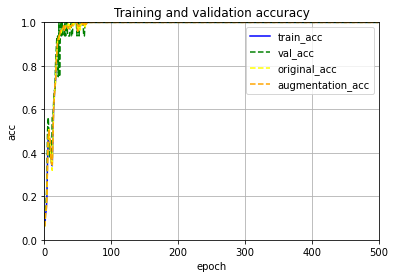

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1729, val_acc: 0.0625, val_f: 0.0104
Epoch [11/500], Loss: 0.0409, val_loss: 0.1484, val_acc: 0.4375, val_f: 0.3479
Epoch [21/500], Loss: 0.0100, val_loss: 0.0336, val_acc: 0.8750, val_f: 0.8333
Epoch [31/500], Loss: 0.0036, val_loss: 0.0123, val_acc: 1.0000, val_f: 1.0000
Epoch [41/500], Loss: 0.0024, val_loss: 0.0079, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0014, val_loss: 0.0153, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0012, val_loss: 0.0029, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0006, val_loss: 0.0128, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0004, val_loss: 0.0028, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0003, val_loss: 0.0023, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0003, val_loss: 0.0021, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0002, val_loss: 0.0021, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0002, val_loss: 0.0026, v

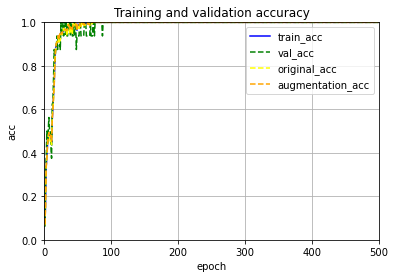

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0422, val_loss: 0.1544, val_acc: 0.2500, val_f: 0.1431
Epoch [21/500], Loss: 0.0145, val_loss: 0.0540, val_acc: 0.8125, val_f: 0.7500
Epoch [31/500], Loss: 0.0044, val_loss: 0.0232, val_acc: 0.8750, val_f: 0.8333
Epoch [41/500], Loss: 0.0023, val_loss: 0.0191, val_acc: 0.8750, val_f: 0.8333
Epoch [51/500], Loss: 0.0019, val_loss: 0.0160, val_acc: 0.8750, val_f: 0.8333
Epoch [61/500], Loss: 0.0021, val_loss: 0.0162, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0009, val_loss: 0.0154, val_acc: 0.8750, val_f: 0.8333
Epoch [81/500], Loss: 0.0010, val_loss: 0.0058, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0005, val_loss: 0.0065, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0003, val_loss: 0.0033, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0003, val_loss: 0.0031, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0002, val_loss: 0.0029, v

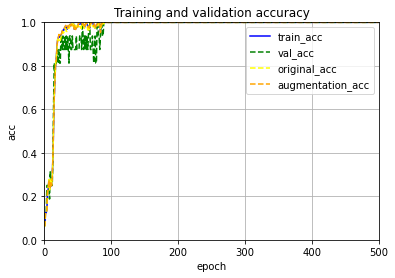

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0398, val_loss: 0.1461, val_acc: 0.1875, val_f: 0.0920
Epoch [21/500], Loss: 0.0139, val_loss: 0.0535, val_acc: 0.8750, val_f: 0.8333
Epoch [31/500], Loss: 0.0042, val_loss: 0.0241, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0024, val_loss: 0.0214, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0018, val_loss: 0.0167, val_acc: 0.8750, val_f: 0.8333
Epoch [61/500], Loss: 0.0008, val_loss: 0.0114, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0006, val_loss: 0.0105, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0004, val_loss: 0.0093, val_acc: 1.0000, val_f: 1.0000
Epoch [91/500], Loss: 0.0003, val_loss: 0.0083, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0003, val_loss: 0.0077, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0002, val_loss: 0.0072, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0002, val_loss: 0.0063, v

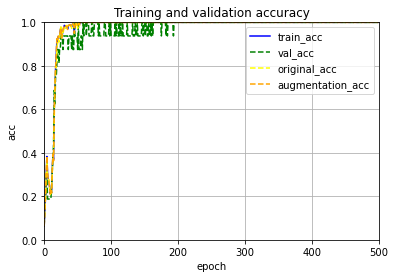

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1732, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0418, val_loss: 0.1561, val_acc: 0.3125, val_f: 0.2054
Epoch [21/500], Loss: 0.0144, val_loss: 0.0621, val_acc: 0.6875, val_f: 0.6250
Epoch [31/500], Loss: 0.0045, val_loss: 0.0473, val_acc: 0.6875, val_f: 0.6250
Epoch [41/500], Loss: 0.0029, val_loss: 0.0485, val_acc: 0.7500, val_f: 0.7083
Epoch [51/500], Loss: 0.0015, val_loss: 0.0623, val_acc: 0.6875, val_f: 0.6250
Epoch [61/500], Loss: 0.0009, val_loss: 0.0594, val_acc: 0.6875, val_f: 0.6250
Epoch [71/500], Loss: 0.0007, val_loss: 0.0638, val_acc: 0.6875, val_f: 0.6250
Epoch [81/500], Loss: 0.0005, val_loss: 0.0671, val_acc: 0.6875, val_f: 0.6250
Epoch [91/500], Loss: 0.0010, val_loss: 0.0698, val_acc: 0.6875, val_f: 0.6250
Epoch [101/500], Loss: 0.0003, val_loss: 0.0754, val_acc: 0.6875, val_f: 0.6250
Epoch [111/500], Loss: 0.0003, val_loss: 0.0768, val_acc: 0.6875, val_f: 0.6250
Epoch [121/500], Loss: 0.0002, val_loss: 0.0777, v

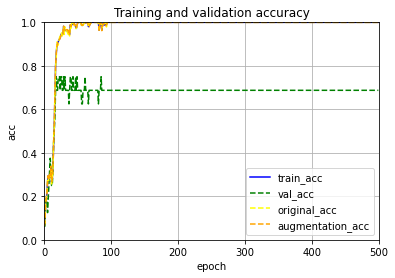

[0.6875]




Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0420, val_loss: 0.1535, val_acc: 0.3125, val_f: 0.1667
Epoch [21/500], Loss: 0.0158, val_loss: 0.0574, val_acc: 0.8750, val_f: 0.8333
Epoch [31/500], Loss: 0.0059, val_loss: 0.0290, val_acc: 0.8750, val_f: 0.8333
Epoch [41/500], Loss: 0.0038, val_loss: 0.0200, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0019, val_loss: 0.0226, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0019, val_loss: 0.0208, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0012, val_loss: 0.0190, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0008, val_loss: 0.0175, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0018, val_loss: 0.0206, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0005, val_loss: 0.0140, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0004, val_loss: 0.0165, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0003, val_loss: 0.0188, v

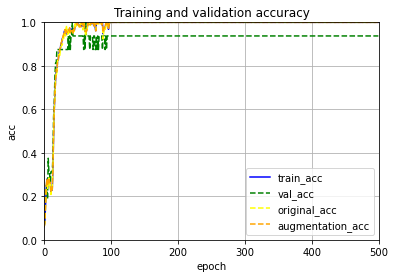

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0430, val_loss: 0.1573, val_acc: 0.1875, val_f: 0.0958
Epoch [21/500], Loss: 0.0217, val_loss: 0.0855, val_acc: 0.6875, val_f: 0.6146
Epoch [31/500], Loss: 0.0098, val_loss: 0.0505, val_acc: 0.7500, val_f: 0.6875
Epoch [41/500], Loss: 0.0051, val_loss: 0.0447, val_acc: 0.8125, val_f: 0.7708
Epoch [51/500], Loss: 0.0031, val_loss: 0.0386, val_acc: 0.8750, val_f: 0.8333
Epoch [61/500], Loss: 0.0023, val_loss: 0.0327, val_acc: 0.8750, val_f: 0.8333
Epoch [71/500], Loss: 0.0020, val_loss: 0.0356, val_acc: 0.8750, val_f: 0.8333
Epoch [81/500], Loss: 0.0018, val_loss: 0.0373, val_acc: 0.8750, val_f: 0.8333
Epoch [91/500], Loss: 0.0010, val_loss: 0.0392, val_acc: 0.8750, val_f: 0.8333
Epoch [101/500], Loss: 0.0012, val_loss: 0.0480, val_acc: 0.8125, val_f: 0.7500
Epoch [111/500], Loss: 0.0007, val_loss: 0.0368, val_acc: 0.8750, val_f: 0.8333
Epoch [121/500], Loss: 0.0013, val_loss: 0.0395, v

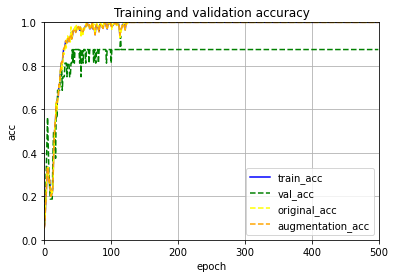

[0.875]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.0625, val_f: 0.0096
Epoch [11/500], Loss: 0.0426, val_loss: 0.1552, val_acc: 0.4375, val_f: 0.3199
Epoch [21/500], Loss: 0.0173, val_loss: 0.0722, val_acc: 0.7500, val_f: 0.6667
Epoch [31/500], Loss: 0.0073, val_loss: 0.0548, val_acc: 0.7500, val_f: 0.6875
Epoch [41/500], Loss: 0.0038, val_loss: 0.0436, val_acc: 0.8125, val_f: 0.7708
Epoch [51/500], Loss: 0.0022, val_loss: 0.0369, val_acc: 0.8125, val_f: 0.7708
Epoch [61/500], Loss: 0.0027, val_loss: 0.0374, val_acc: 0.7500, val_f: 0.6875
Epoch [71/500], Loss: 0.0015, val_loss: 0.0400, val_acc: 0.8125, val_f: 0.7708
Epoch [81/500], Loss: 0.0027, val_loss: 0.0442, val_acc: 0.8125, val_f: 0.7708
Epoch [91/500], Loss: 0.0006, val_loss: 0.0353, val_acc: 0.8125, val_f: 0.7708
Epoch [101/500], Loss: 0.0013, val_loss: 0.0435, val_acc: 0.8125, val_f: 0.7708
Epoch [111/500], Loss: 0.0005, val_loss: 0.0296, val_acc: 0.8750, val_f: 0.8333
Epoch [121/500], Loss: 0.0004, val_loss: 0.0280, v

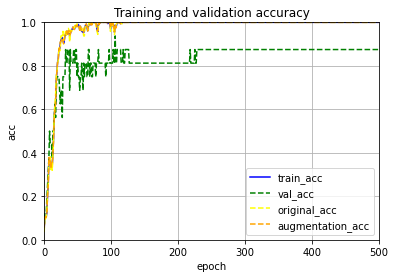

[0.875]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0420, val_loss: 0.1543, val_acc: 0.2500, val_f: 0.1437
Epoch [21/500], Loss: 0.0153, val_loss: 0.0575, val_acc: 0.8125, val_f: 0.7500
Epoch [31/500], Loss: 0.0068, val_loss: 0.0246, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0042, val_loss: 0.0134, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0027, val_loss: 0.0104, val_acc: 1.0000, val_f: 1.0000
Epoch [61/500], Loss: 0.0022, val_loss: 0.0065, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0020, val_loss: 0.0082, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0026, val_loss: 0.0159, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0010, val_loss: 0.0047, val_acc: 1.0000, val_f: 1.0000
Epoch [101/500], Loss: 0.0008, val_loss: 0.0031, val_acc: 1.0000, val_f: 1.0000
Epoch [111/500], Loss: 0.0005, val_loss: 0.0045, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0004, val_loss: 0.0026, v

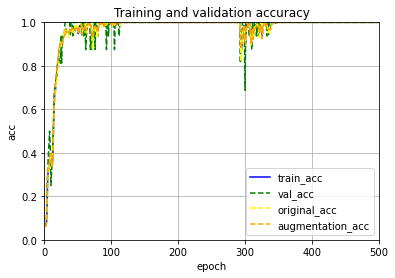

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.0625, val_f: 0.0089
Epoch [11/500], Loss: 0.0423, val_loss: 0.1587, val_acc: 0.1875, val_f: 0.0845
Epoch [21/500], Loss: 0.0163, val_loss: 0.0871, val_acc: 0.3750, val_f: 0.2750
Epoch [31/500], Loss: 0.0072, val_loss: 0.0657, val_acc: 0.5625, val_f: 0.4688
Epoch [41/500], Loss: 0.0037, val_loss: 0.0667, val_acc: 0.5625, val_f: 0.4688
Epoch [51/500], Loss: 0.0035, val_loss: 0.0489, val_acc: 0.6875, val_f: 0.6042
Epoch [61/500], Loss: 0.0016, val_loss: 0.0686, val_acc: 0.6250, val_f: 0.5417
Epoch [71/500], Loss: 0.0016, val_loss: 0.0421, val_acc: 0.6875, val_f: 0.5938
Epoch [81/500], Loss: 0.0017, val_loss: 0.0474, val_acc: 0.6875, val_f: 0.5833
Epoch [91/500], Loss: 0.0011, val_loss: 0.0536, val_acc: 0.6875, val_f: 0.5833
Epoch [101/500], Loss: 0.0006, val_loss: 0.0617, val_acc: 0.6875, val_f: 0.5833
Epoch [111/500], Loss: 0.0004, val_loss: 0.0688, val_acc: 0.6875, val_f: 0.5833
Epoch [121/500], Loss: 0.0004, val_loss: 0.0672, v

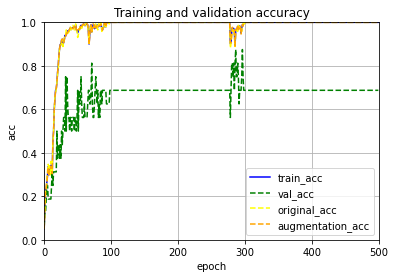

[0.6875]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1729, val_acc: 0.1875, val_f: 0.0647
Epoch [11/500], Loss: 0.0424, val_loss: 0.1546, val_acc: 0.1875, val_f: 0.0972
Epoch [21/500], Loss: 0.0161, val_loss: 0.0568, val_acc: 0.8125, val_f: 0.7500
Epoch [31/500], Loss: 0.0064, val_loss: 0.0264, val_acc: 0.8750, val_f: 0.8333
Epoch [41/500], Loss: 0.0038, val_loss: 0.0114, val_acc: 1.0000, val_f: 1.0000
Epoch [51/500], Loss: 0.0026, val_loss: 0.0107, val_acc: 0.9375, val_f: 0.9167
Epoch [61/500], Loss: 0.0026, val_loss: 0.0083, val_acc: 1.0000, val_f: 1.0000
Epoch [71/500], Loss: 0.0018, val_loss: 0.0172, val_acc: 0.8750, val_f: 0.8542
Epoch [81/500], Loss: 0.0017, val_loss: 0.0075, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0008, val_loss: 0.0104, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0009, val_loss: 0.0096, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0016, val_loss: 0.0045, val_acc: 1.0000, val_f: 1.0000
Epoch [121/500], Loss: 0.0005, val_loss: 0.0066, v

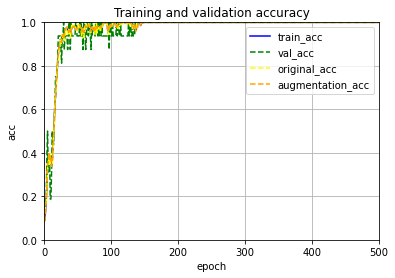

[1.0]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1731, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0425, val_loss: 0.1566, val_acc: 0.3125, val_f: 0.2056
Epoch [21/500], Loss: 0.0176, val_loss: 0.0676, val_acc: 0.8125, val_f: 0.7500
Epoch [31/500], Loss: 0.0075, val_loss: 0.0308, val_acc: 0.9375, val_f: 0.9167
Epoch [41/500], Loss: 0.0044, val_loss: 0.0204, val_acc: 0.9375, val_f: 0.9167
Epoch [51/500], Loss: 0.0027, val_loss: 0.0196, val_acc: 0.8750, val_f: 0.8542
Epoch [61/500], Loss: 0.0018, val_loss: 0.0141, val_acc: 0.9375, val_f: 0.9167
Epoch [71/500], Loss: 0.0025, val_loss: 0.0198, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0013, val_loss: 0.0126, val_acc: 0.9375, val_f: 0.9167
Epoch [91/500], Loss: 0.0007, val_loss: 0.0115, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0006, val_loss: 0.0121, val_acc: 0.9375, val_f: 0.9167
Epoch [111/500], Loss: 0.0005, val_loss: 0.0118, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0004, val_loss: 0.0124, v

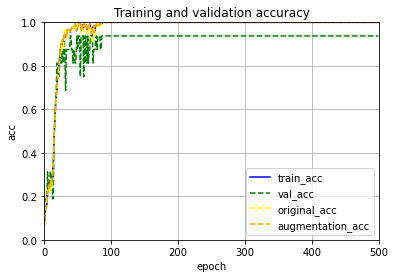

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1732, val_acc: 0.0625, val_f: 0.0139
Epoch [11/500], Loss: 0.0434, val_loss: 0.1594, val_acc: 0.2500, val_f: 0.1583
Epoch [21/500], Loss: 0.0203, val_loss: 0.0852, val_acc: 0.5625, val_f: 0.4479
Epoch [31/500], Loss: 0.0099, val_loss: 0.0566, val_acc: 0.6875, val_f: 0.6042
Epoch [41/500], Loss: 0.0052, val_loss: 0.0443, val_acc: 0.8750, val_f: 0.8333
Epoch [51/500], Loss: 0.0037, val_loss: 0.0433, val_acc: 0.7500, val_f: 0.6667
Epoch [61/500], Loss: 0.0019, val_loss: 0.0271, val_acc: 0.8750, val_f: 0.8333
Epoch [71/500], Loss: 0.0017, val_loss: 0.0176, val_acc: 0.9375, val_f: 0.9167
Epoch [81/500], Loss: 0.0022, val_loss: 0.0251, val_acc: 0.8750, val_f: 0.8333
Epoch [91/500], Loss: 0.0008, val_loss: 0.0198, val_acc: 0.9375, val_f: 0.9167
Epoch [101/500], Loss: 0.0017, val_loss: 0.0361, val_acc: 0.7500, val_f: 0.6667
Epoch [111/500], Loss: 0.0005, val_loss: 0.0196, val_acc: 0.9375, val_f: 0.9167
Epoch [121/500], Loss: 0.0004, val_loss: 0.0182, v

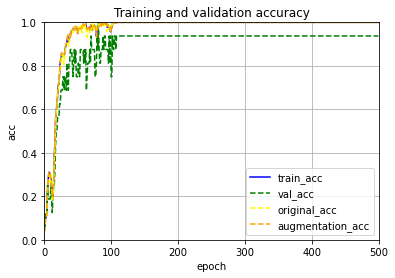

[0.9375]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1730, val_acc: 0.1250, val_f: 0.0295
Epoch [11/500], Loss: 0.0420, val_loss: 0.1553, val_acc: 0.3125, val_f: 0.2292
Epoch [21/500], Loss: 0.0189, val_loss: 0.0784, val_acc: 0.6250, val_f: 0.5312
Epoch [31/500], Loss: 0.0084, val_loss: 0.0508, val_acc: 0.6875, val_f: 0.6042
Epoch [41/500], Loss: 0.0046, val_loss: 0.0372, val_acc: 0.7500, val_f: 0.6667
Epoch [51/500], Loss: 0.0028, val_loss: 0.0340, val_acc: 0.7500, val_f: 0.6667
Epoch [61/500], Loss: 0.0017, val_loss: 0.0242, val_acc: 0.8750, val_f: 0.8333
Epoch [71/500], Loss: 0.0016, val_loss: 0.0306, val_acc: 0.8750, val_f: 0.8333
Epoch [81/500], Loss: 0.0014, val_loss: 0.0222, val_acc: 0.8750, val_f: 0.8333
Epoch [91/500], Loss: 0.0010, val_loss: 0.0325, val_acc: 0.8125, val_f: 0.7500
Epoch [101/500], Loss: 0.0015, val_loss: 0.0245, val_acc: 0.8750, val_f: 0.8333
Epoch [111/500], Loss: 0.0008, val_loss: 0.0239, val_acc: 0.8750, val_f: 0.8333
Epoch [121/500], Loss: 0.0010, val_loss: 0.0380, v

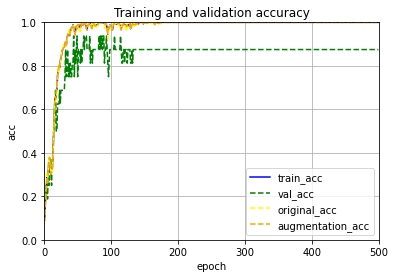

[0.875]



Epoch [1/500], Loss: 0.0462, val_loss: 0.1733, val_acc: 0.0625, val_f: 0.0074
Epoch [11/500], Loss: 0.0432, val_loss: 0.1639, val_acc: 0.2500, val_f: 0.1823
Epoch [21/500], Loss: 0.0206, val_loss: 0.0957, val_acc: 0.5000, val_f: 0.3958
Epoch [31/500], Loss: 0.0091, val_loss: 0.0853, val_acc: 0.4375, val_f: 0.3125
Epoch [41/500], Loss: 0.0047, val_loss: 0.0566, val_acc: 0.6875, val_f: 0.5938
Epoch [51/500], Loss: 0.0032, val_loss: 0.0692, val_acc: 0.6875, val_f: 0.5833
Epoch [61/500], Loss: 0.0022, val_loss: 0.0499, val_acc: 0.6875, val_f: 0.5938
Epoch [71/500], Loss: 0.0012, val_loss: 0.0529, val_acc: 0.5625, val_f: 0.4792
Epoch [81/500], Loss: 0.0016, val_loss: 0.0517, val_acc: 0.6875, val_f: 0.6042
Epoch [91/500], Loss: 0.0018, val_loss: 0.0409, val_acc: 0.7500, val_f: 0.6667
Epoch [101/500], Loss: 0.0008, val_loss: 0.0455, val_acc: 0.6875, val_f: 0.6042
Epoch [111/500], Loss: 0.0005, val_loss: 0.0401, val_acc: 0.6250, val_f: 0.5208
Epoch [121/500], Loss: 0.0007, val_loss: 0.0576, v

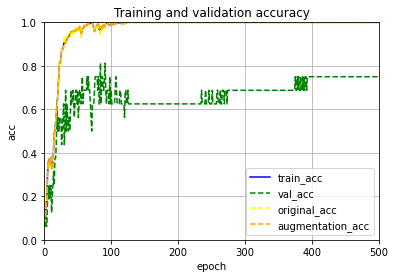

[0.75]


Wall time: 10h 14min 57s
Parser   : 297 ms


In [69]:
%%time

SEED = 0
fix_seed(SEED)

aug_times = 5
dtw_type= ""
method='rgw'

model_name = 'lstm'
# LSTM
num_epochs = 500
hidden_size = 512
batch_size = 60
num_layers = 3
is_bi = True
mabiki_interval = 8

# num_epochs =400
# hidden_size = 500
# batch_size = 60
# num_layers = 2
# is_bi = True
# mabiki_interval = 8

# CNN
conv_size = 20


metric = "dtw" # "dtw" or "eq"
# moving_average_size_list = [1, 5, 10, 15, 20]
moving_average_size_list = [30]

window_size = 20
overlap_size = 10

nSplit = 10

all_acc_list = []
for moving_average_size in tqdm(moving_average_size_list):

    # prep_list = ['平均0', '最初0']
    # feats_num_list = [16, 40]
    # INPUT_FOLDER_list = ['nagasima_split', 'Sub.5_split', 'hirayama_split', 'tabuchi_split', 'okamotomasa_split', 'yosida_split', 'okuda_split', 'okamotomarina_split']

    prep_list = ['生']
    gesutures_num_list = ['houkou16'] # 5or10or20
    feats_num_list = [16]

    INPUT_FOLDER_list = ['yamashita_split', 'Sub.5_split', 'hirayama_split', 'tabuchi_split', 
                     'okamotomasa_split', 'yosida_split', 'okuda_split', 
                     'okamotomarina_split', 'nagasima_split', 'isobe_split', 
                    'igarashi_split', 'hotta_split', 'watanabe_split', 
                     'takayama_split']
    # INPUT_FOLDER_list = ['nagasima_split', 'hirayama_split', 'tabuchi_split', 'okamotomasa_split', 'yosida_split', 'okuda_split', 'okamotomarina_split']
#     INPUT_FOLDER_list = ['okamotomasa_split']
#     INPUT_FOLDER_list = ['Sub.5_split']
#     INPUT_FOLDER_list = ['okuda_split']


    for INPUT_FOLDER in INPUT_FOLDER_list:
        for gesutures_num in gesutures_num_list:
            for prep in prep_list:
                for feats_num in feats_num_list:

                    DATA_PATH = '.' + "./data_split/" + INPUT_FOLDER + "/3. STEP3/3-1 条件(照明：普通、表情：無、振動：静止)、タスク：ジェスチャ"
                    list_df = make_input_data(DATA_PATH, moving_average_size, metric)
                    

                    if model_name=='knn':
                        DIR_OUT = './' + 'ジェスチャ通常環境' + '/' + INPUT_FOLDER.replace('_split', '') + '/交差検証' + '/１普通状態_' + str(gesutures_num) + 'G_' + str(feats_num) + 'feats_' + prep + '_' + str(moving_average_size)+'sma' + '_'+model_name+metric
                    else:
                        DIR_OUT = './' + 'ジェスチャ通常環境' + '/' + INPUT_FOLDER.replace('_split', '') + '/交差検証' + '/１普通状態_' + str(gesutures_num) + 'G_' + str(feats_num) + 'feats_' + prep + '_' + str(moving_average_size)+'sma' + '_'+model_name
                    os.makedirs(DIR_OUT, exist_ok=True)


                    df = list_df[0]
                    class_num = len(set(df["Label"]))

                    
                    if model_name == 'knn':
                        def DTW(a, b):
                            return fastdtw(a, b)[0]

                    #     clf = Pipeline([("scaler", StandardScaler()), ("svc", SVC())])
                    #     clf = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=5, n_jobs=-1))])

                        if metric == "eq":
                            clf = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)
                    #         , weights='distance'
                        elif metric == "dtw":
                            clf = KNeighborsTimeSeriesClassifier(n_neighbors=7, metric="dtw", n_jobs=-1)
                    #         , weights='distance'
                    #         clf = KNeighborsClassifier(metric=DTW, n_neighbors=11, n_jobs=-1)
                        else:
                            print('metricがおかしいです')
                            sys.exit()

                    #     param_grid = [{'knn__n_neighbors': [3]}]


                    # kf = KFold(n_splits=nSplit, shuffle=False)
                    # kf_grid = KFold(n_splits=nSplit_grid, shuffle=True)
                    # kf_grid = KFold(n_splits=nSplit-1)

                    kf = GroupKFold(n_splits=nSplit)
                    kf_grid = GroupKFold(n_splits=nSplit-1)


                    param_list = []
                    accuracy_list = []
                    test_df_list = []

                    # テスト
                    for count, (train_index, test_index) in enumerate(tqdm(kf.split(df.drop(['Label', 'Trial', 'Label_Trial'], axis=1), df['Label'], df['Trial']), total=nSplit)):                    

                        if model_name != 'knn':
                            # train, test分割   
                            train_list_df = []
                            test_list_df = []
                            for df in list_df:
                                train_list_df.append(df.iloc[train_index])
                                test_list_df.append(df.iloc[test_index])

                                # l_p_df用、エラー出さないため
                                test_df = df.iloc[test_index]

        #                     tmp_Y_pred, tmp_Y_test, tmp_best_eval_acc = pipeline(train_list_df, test_list_df, DIR_OUT, count)
                            
                            train_list_df = augmentation(train_list_df, aug_times, dtw_type=dtw_type, method=method)
#                             aaa
                            
                            pre_best_eval_acc = 0
                            best_eval_acc_list = []
                            for random_counter in range(1):
                                if model_name == 'cnn':
                                    tmp_Y_pred, tmp_Y_test, tmp_best_eval_acc = pipeline_cnn(train_list_df, test_list_df, 
                                                                                         DIR_OUT, count, pre_best_eval_acc, 
                                                                                        conv_size)
                                elif model_name == 'lstm':
                                    tmp_Y_pred, tmp_Y_test, tmp_best_eval_acc = pipeline_lstm(train_list_df, test_list_df, 
                                                                                         DIR_OUT, count, pre_best_eval_acc, 
                                                                                        num_epochs, hidden_size, batch_size, 
                                                                                        num_layers, is_bi, mabiki_interval)
                                if tmp_best_eval_acc > pre_best_eval_acc:
                                    best_eval_acc = tmp_best_eval_acc
                                    Y_pred = copy.copy(tmp_Y_pred)
                                    Y_test = copy.copy(tmp_Y_test)
                                best_eval_acc_list.append(tmp_best_eval_acc)
                                pre_best_eval_acc = tmp_best_eval_acc
                            print(best_eval_acc_list) 

                            test_df_list.append(test_df)
#                             aaa
                            
                        elif model_name == 'knn':
                            Y_proba = np.zeros((len(test_index), class_num))
                            for df in tqdm(list_df):
                                train_df = df.iloc[train_index]
                                test_df = df.iloc[test_index]
                                data_train = train_df.drop(['Label', 'Trial', 'Label_Trial'], axis=1)
                                label_train = train_df.loc[:, 'Label']
                                group_train = train_df.loc[:, 'Trial']
                                data_test = test_df.drop(['Label', 'Trial', 'Label_Trial'], axis=1)
                                label_test = test_df.loc[:, 'Label']

                                if model_name == 'knn':
                                    clf.fit(data_train, label_train)
                        #             Y_pred = clf.predict(data_test)
                                    Y_proba += clf.predict_proba(data_test.values)

                            Y_pred = Y_proba.argmax(axis = 1).astype(object)
                            for class_i in range(class_num):
                                np.putmask(Y_pred, Y_pred == class_i, clf.classes_[class_i])
                            Y_test = label_test
                            test_df_list.append(test_df)
                        
                        
                        
                        warnings.filterwarnings('ignore')
                        recall = recall_score(Y_test, Y_pred, average="weighted")
                        precision = precision_score(Y_test, Y_pred, average="weighted")
                        fMeasure = f1_score(Y_test, Y_pred, average="weighted")
                        labels = natsorted(list(set(Y_test)))
                        cmx_data = confusion_matrix(Y_test, Y_pred, labels=labels)
                        df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
                        report = classification_report(Y_test, Y_pred, target_names=labels, labels=labels, output_dict=True)
                        df_report = pd.DataFrame(report)

                        if count == 0:
                            mean_df_report = df_report
                            sum_df_cmx = df_cmx
                            all_Y_pred = Y_pred
                        else:
                            mean_df_report += df_report
                            sum_df_cmx += df_cmx
                            all_Y_pred = np.append(all_Y_pred, Y_pred)

                        os.makedirs(DIR_OUT, exist_ok=True)
                        df_report.to_csv(DIR_OUT + "/" + "trial" + str(count+1) + ".csv", encoding='utf-8')
                        df_cmx.to_csv(DIR_OUT + "/" + "trial" + str(count+1) + "_cmx.csv", encoding='utf-8')
                        plt.figure(figsize=(10, 7))
                    #     sns.set(font='MS Gothic') #ラベルが日本語の場合
                        sns.heatmap(df_cmx, annot=True, cmap='Blues', fmt='g')
                        #plt.show()
                        plt.savefig(DIR_OUT + "/" + "trial" + str(count+1) + "_cmx.png", bbox_inches='tight')
                        plt.close()
                        #df_report.to_csv(DIR_OUT + "/" + "trial" + str(count+1) + ".csv", encoding='utf-8',mode='x')

                    mean_df_report /= count+1
                    mean_df_report.to_csv(DIR_OUT + "/" + "trialAll.csv", encoding='utf-8')

#                     with open(DIR_OUT + '/F1score.txt', mode='w') as f:
#                         s = str(mean_df_report.loc['f1-score', 'macro avg'])
#                         f.write(s)
#                     with open("./ジェスチャ通常環境" + '/' + 'ジェスチャ通常環境' + 'F1score.txt', mode='a') as f:
#                         s = DIR_OUT + '\n'
#                         s += str(mean_df_report.loc['f1-score', 'macro avg']) + '\n\n'
#                         f.write(s)
                    with open(DIR_OUT + '/accuracy.txt', mode='w') as f:
                        s = str(mean_df_report.loc['f1-score', 'accuracy'])
                        f.write(s)
                    all_acc_list.append(mean_df_report.loc['f1-score', 'accuracy'])
                    with open("./ジェスチャ通常環境" + '/' + 'ジェスチャ通常環境' + 'accuracy.txt', mode='a') as f:
                        s = DIR_OUT + '\n'
                        s += str(mean_df_report.loc['f1-score', 'accuracy']) + '\n\n'
                        f.write(s)

                    # result_list.append(mean_df_report['macro avg'].loc['precision'])
                    # result_list.append(mean_df_report['macro avg'].loc['recall'])
                    # result_list.append(mean_df_report['macro avg'].loc['f1-score'])

                    plt.figure(figsize=(10, 7))
                    sns.heatmap(sum_df_cmx, annot=True, cmap='Blues', fmt='g')
                    plt.savefig(DIR_OUT + "/" + "trialAll_cmx.png", bbox_inches='tight')
                    plt.close()
                    sum_df_cmx.to_csv(DIR_OUT + "/" + "trialAll_cmx.csv", encoding='utf-8')

#                     if model_name != 'knn':
#                         with open(DIR_OUT + '/param.txt', mode='w') as f:
#                             for i in range(nSplit):
#                                 s = "trial" + str(i+1) + '\n' + 'param : ' + str(param_list[i]) + '\n' + 'accuracy : ' + str(accuracy_list[i]) + '\n\n'
#                                 f.write(s)

                    l_p_df = pd.concat(test_df_list, sort=False)
                    label = l_p_df['Label']
                    l_p_df = l_p_df.drop('Label', axis=1)
                    l_p_df.insert(2, 'Label', label)
                    l_p_df.insert(3, 'prediction_label', all_Y_pred)
                    l_p_df.to_csv(DIR_OUT + "/" + "prediction.csv", encoding='utf-8')



with open("./ジェスチャ通常環境" + '/' + 'ジェスチャ通常環境' + 'accuracy.txt', mode='a') as f:
    s = 'all_mean' + '\n'
    s += str(np.mean(all_acc_list)) + '\n\n'
    f.write(s)